This notebook contains code for analyzing detector occupancies from background and signal events. 

The code can be used to plot either all the hits in the selected detectors (`H1B/T, H2B/T, H4B/T, H1L/R, H2L/R, H4Y1L/R, H4Y2L/R`), or to plot all the hits in these detectors after imposing cuts on the data.

When imposing a cut, an event is classified as valid if and only if *all* hits in the event lie within a given x-range in `H1B/T`, `H2B/T`, and/or `H4B/T`. If there are hits outside of this range, the event is not valid. One or multiple cuts can be imposed on the data to achieve the best signal acceptance and background rejection. 

**Note:** The first iteration of this code required a valid hit only to have at least one hit in the given x-range. This resulted in far lower background rejection for very little increase in signal acceptance. Imposing stricter cuts by requiring that an event have hits *only* within the desired range results in a drastic improvement in both signal acceptance and background rejection.

**Main Methods:**
* **`layer4BG()`, `layer4Sim()`**: These two methods read a given ROOT file and return a multi-dimensional array with the hodoscope occupancies after either 0,1,2, or 3 cuts imposed

* **`plot_BG`, `plot_Sim`**: These two methods plot the occupancies returned by the `layer4` methods. The plots can be weighted (hits/event) or unweighted (total hits)

* **`plot_overlay`**: This method plots the hodoscope occupancies from background and up to two different signals. If not making any cuts, specify `layer=[0]` in the `layer` methods and `noCuts=True` in this method. Else, `noCuts=False`.

* **`efficiencies`**: Impose one or multiple cuts on the data which gradually narrow to determine the signal efficiency (acceptance) and background rejection after each cut. Returns a multidimensional array of SE and BR for each station after the cut

* **`plot_efficiencies`**: plot the ROC curve of SE vs BR 

**Notebook Overview:**
1. Importing necessary modules

2. Files
     * concatenating all tracklet files using uproot (`hadd`-ing didn't work)
    * Getting the names of all the sim files for parsing later in plots
    
3. Masks
    * making masks for the hodoscopes and one drift chamber
    * DC2 is the only drift chamber with data for both tracklet files and sim files
    
4. Background Data
    * Methods for getting detector occupancies with background data
    * Method for plotting background 
    * cuts can be applied to the data and plotted

5. Signal Data
    * Same as above
    
6. Comparing Signal to Background
    * Plotting the signal and background
    * cuts can be applied 
    
7. Examples
    * Example plots showing the functionality of the various analysis and plotting methods. 
    * After looking at some cases of imposing cuts, it seems clear that the best cut to impose would be on station 1 only, and there is little to gain by imposing further cuts on the downrange stations
    
8. ROC Curve
    * Code for generating and plotting the SE/BR ratio for specific cuts on various detectors

# Imports

In [1]:
import uproot4   # concatenate bkg data (hadd in directory didnt work for some reason??)
import uproot
import awkward1 as ak
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import                                                                                                                  
import mplhep as hep
plt.style.use(hep.style.ROOT)   # ROOT defaults to CMS style

# Files

Background

In [2]:
root = uproot4.concatenate("../2017Data/combined_data/track_*.root:save/rawEvent",["fTriggerBits","fAllHits.pos","fAllHits.driftDistance","fAllHits.detectorID"],library="ak",how="zip")

Signal - names of simulation files

In [3]:
# Names
Brem003 = "../electrons/sim_eval_Brem_0.033428_z500_600_eps_-5.2.root"
Brem047 = "../electrons/sim_eval_Brem_0.470915_z500_600_eps_-6.root"
Eta001 = "../electrons/sim_eval_Eta_0.019564_z500_600_eps_-5.2.root"
Eta054 = "../electrons/sim_eval_Eta_0.540000_z500_600_eps_-6.root"

# Detector Masks

Masks for each of the detectors of interest. Data argument must be specified (signal/background) when calling each method

In [4]:
def H1BT(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 31) & (arr.detectorID <= 32)
    else:
        mask = (arr.detID >= 31) & (arr.detID <= 32)
    return mask

def H1LR(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 33) & (arr.detectorID <= 34)
    else:
        mask = (arr.detID >= 33) & (arr.detID <= 34)
    return mask

def H2BT(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 37) & (arr.detectorID <= 38)
    else:
        mask = (arr.detID >= 37) & (arr.detID <= 37)
    return mask

def H2LR(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 35) & (arr.detectorID <= 36)
    else:
        mask = (arr.detID >= 35) & (arr.detID <= 36)
    return mask

def H4BT(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 45) & (arr.detectorID <= 46)
    else:
        mask = (arr.detID >= 45) & (arr.detID <= 46)
    return mask

def H4Y1LR(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 41) & (arr.detectorID <= 42)
    else:
        mask = (arr.detID >= 41) & (arr.detID <= 42)
    return mask

def H4Y2LR(arr, data="Background"):
    if (data=="Background"):
        mask = (arr.detectorID >= 43) & (arr.detectorID <= 44)
    else:
        mask = (arr.detID >= 43) & (arr.detID <= 44)
    return mask

def DC2X(arr, data="Background"):
    '''
    x view of Drift Chamber 2
    only DC that has data for both signal and background
    '''
    if (data=="Background"):
        mask = (arr.detectorID >= 15) & (arr.detectorID <= 16)
    else:
        mask = (arr.detID >= 15) & (arr.detID <= 16)
    return mask

Helper function for performing cuts

In [8]:
def inside(hits, cut, data="Background"):
    '''
    returns an array of the indices of events in which there are hits
    ONLY within the region of interest, specified for each det layer
    hits = all hits in the given detector
    cut = (lower,upper) - inclusive
    data = Background/Signal
    
    returns array of indices of events which have hits ONLY in the given xrange
    '''
    if (data == "Background"):
        all_events = np.arange(0,677)     # stand-in for total events after TriggerBits selection
        outside = (hits.pos < cut[0]) | (hits.pos > cut[1])
    else:
        all_events = np.arange(0,10000)   # stand-in for all eventIDs
        outside = (hits.truthx < cut[0]) | (hits.truthx > cut[1])
    idx = np.where(ak.any(outside,axis=1))   # indices of events meeting above criteria
    diff = np.setdiff1d(all_events,idx)
    
    return diff

# Get Background Data

In [9]:
def get_BackgroundData(root):
    bg_events = ak.zip({"Hits":ak.zip({
                                        "detectorID": root.fAllHits["detectorID"],
                                        "pos": root.fAllHits["pos"]
                                      })
                       }, depth_limit=1)
    return bg_events

In [10]:
def layer4BG(root, layer=[1], cut1=(-10,10), cut2=(-10,10), cut4=(-10,10)):
    '''
    root = background data ROOT file
    layer = layer(s) on which to cut 
        -> [1], [2], [4]
        -> [1, 2], [1, 4], [2, 4]
        -> [1, 2, 4]
    cut_ = x-positions between which to cut at each respective station
    '''
    # get all events
    allHits = get_BackgroundData(root)["Hits"]
    # get all valid events based on TriggerBits criteria (random trigger)
    validEvent_fTriggerBits = (root.fTriggerBits==65) | (root.fTriggerBits==67)
    # now mask all events by TriggerBits
    hitsBG = allHits[validEvent_fTriggerBits]
    
    # get L/R hodo data - needed for all cases
    # mask for these detectors
    h1lr = H1LR(hitsBG)
    h2lr = H2LR(hitsBG)
    h4y1lr = H4Y1LR(hitsBG)
    h4y2lr = H4Y2LR(hitsBG)
    # get hits in these detectors
    h1lr_hits = hitsBG[h1lr]
    h2lr_hits = hitsBG[h2lr]
    h4y1lr_hits = hitsBG[h4y1lr]
    h4y2lr_hits = hitsBG[h4y2lr]
    
    # now determine which cut(s) we are performing
    
    # we are only cutting on one layer
    if (len(layer)==1):
        # perform NO cuts
        if (layer[0]==0):
            h1_mask = H1BT(hitsBG)
            h1_hits = hitsBG[h1_mask]
            
            h2_mask = H2BT(hitsBG)
            h2_hits = hitsBG[h2_mask]
            
            h4_mask = H4BT(hitsBG)
            h4_hits = hitsBG[h4_mask]
            
            # grab drift chamber 2 as well (only for uncut data)
            dc2_mask = DC2X(hitsBG)
            dc2_hits = hitsBG[dc2_mask]
            
            assert(len(h1_hits)==len(h2_hits)==len(h4_hits)==len(dc2_hits)==677)
            
            # return array of arrays containing ONLY [all hits, nevents]
            # this is different from occasions where you impose cuts
            return [[h1_hits.pos,     677], # H1BT
                    [h2_hits.pos,     677], # H2BT
                    [h4_hits.pos,     677], # H4BT
                    [h1lr_hits.pos,   677], # H1LR
                    [h2lr_hits.pos,   677], # H2LR
                    [h4y1lr_hits.pos, 677], # H4Y1LR
                    [h4y2lr_hits.pos, 677], # H4Y2LR
                    [dc2_hits.pos,    677]] # DC2x
        
        # perform cut on station 1 ONLY
        if (layer[0]==1):
            h1_mask = H1BT(hitsBG)
            h1_hits = hitsBG[h1_mask]
            x1_mask = inside(h1_hits, cut1)   # get the indices of events meeting st1 criteria
            n1 = len(x1_mask)

            # get data from station 2 (only events meeting st1 criteria)
            h2_mask = H2BT(hitsBG)
            h2_hits = hitsBG[h2_mask]
            n2 = len(h2_hits[x1_mask])   # should be equal to n1, n4
            
            # get data from station 4 (only events meeting st1 criteria)
            h4_mask = H4BT(hitsBG)
            h4_hits = hitsBG[h4_mask]
            n4 = len(h4_hits[x1_mask])  # should be equl to n1, n2
            
            # debug
            assert(n1==n2==n4)
            
            # return array of arrays containing [all hits, hits after cut(s), nevents]
            return [[h1_hits.pos,     h1_hits[x1_mask].pos,     n1], # H1BT
                    [h2_hits.pos,     h2_hits[x1_mask].pos,     n2], # H2BT
                    [h4_hits.pos,     h4_hits[x1_mask].pos,     n4], # H4BT
                    [h1lr_hits.pos,   h1lr_hits[x1_mask].pos,   n1], # H1LR
                    [h2lr_hits.pos,   h2lr_hits[x1_mask].pos,   n2], # H2LR
                    [h4y1lr_hits.pos, h4y1lr_hits[x1_mask].pos, n4], # H4Y1LR
                    [h4y2lr_hits.pos, h4y2lr_hits[x1_mask].pos, n4]] # H4Y2LR
        
        # perform cut on station 2 ONLY
        if (layer[0]==2):
            h1_mask = H1BT(hitsBG)
            h1_hits = hitsBG[h1_mask]   # we're done with this layer, return all hits here
            n1 = len(h1_hits)           # n1 == 677 - we have no cut here, so no events rejected
            
            # get data from station 2
            h2_mask = H2BT(hitsBG)
            h2_hits = hitsBG[h2_mask]
            x2_mask = inside(h2_hits, cut2)
            n2 = len(h2_hits[x2_mask])
            
            # get data from station 4
            h4_mask = H4BT(hitsBG)
            h4_hits = hitsBG[h4_mask]
            n4 = len(h4_hits[x2_mask])   # should be equal to n2
            
            #debug
            assert(n2==n4)
            
            return [[h1_hits.pos,     h1_hits.pos,              n1], # H1BT
                    [h2_hits.pos,     h2_hits[x2_mask].pos,     n2], # H2BT
                    [h4_hits.pos,     h4_hits[x2_mask].pos,     n4], # H4BT
                    [h1lr_hits.pos,   h1lr_hits.pos,            n1], # H1LR
                    [h2lr_hits.pos,   h2lr_hits[x2_mask].pos,   n2], # H2LR
                    [h4y1lr_hits.pos, h4y1lr_hits[x2_mask].pos, n4], # H4Y1LR
                    [h4y2lr_hits.pos, h4y2lr_hits[x2_mask].pos, n4]] # H4Y2LR
        
        # perform cut on station 4 ONLY
        if (layer[0]==4):
            h1_mask = H1BT(hitsBG)
            h1_hits = hitsBG[h1_mask]   # we're done with this layer, return all hits here
            n1 = len(h1_hits)   # n1 == 677 - we have no cut here, so no events rejected
            
            h2_mask = H2BT(hitsBG)
            h2_hits = hitsBG[h2_mask]
            n2 = len(h2_hits)  # n1==n2==677 - again, no cuts here so all events kept
            
            # station 4 data - make cut
            h4_mask = H4BT(hitsBG)
            h4_hits = hitsBG[h4_mask]
            x4_mask = inside(h4_hits, cut4)
            n4 = len(h4_hits[x4_mask])
            
            # debug 
            assert(n1==n2)
            
            return [[h1_hits.pos,     h1_hits.pos,               n1], # H1BT
                    [h2_hits.pos,     h2_hits.pos,               n2], # H2BT
                    [h4_hits.pos,     h4_hits[x4_mask].pos,      n4], # H4BT
                    [h1lr_hits.pos,   h1lr_hits.pos,             n1], # H1LR
                    [h2lr_hits.pos,   h2lr_hits.pos,             n2], # H2LR
                    [h4y1lr_hits.pos, h4y1lr_hits[x4_mask].pos,  n4], # H4Y1LR
                    [h4y2lr_hits.pos, h4y2lr_hits[x4_mask].pos,  n4]] # H4Y2LR
            
    
    # we are cutting on 2 layers [1,2], [2,4], [1,4]
    # when performing sequential cuts, we need to plot the data only in the desired cut range
    # and only for events which have passed all prior selection criteria ******important******
    elif (len(layer)==2):
        if ((layer==[1,2]) or (layer==[2,1])):
            h1_mask = H1BT(hitsBG)
            h1_hits = hitsBG[h1_mask]
            x1_mask = inside(h1_hits, cut1)   # indices of events meetings st1 criteria
            n1 = len(h1_hits[x1_mask])

            h2_mask = H2BT(hitsBG)
            h2_hits = hitsBG[h2_mask]
            x2_mask = inside(h2_hits, cut2)   # indices of events meeting st2 criteria
            x1x2 = np.intersect1d(x1_mask, x2_mask)   # indices of events meeting both criteria
            n2 = len(x1x2)
            assert(len(x1x2)==len(h2_hits[x1x2]))
            
            # no cut on h4
            h4_mask = H4BT(hitsBG)
            h4_hits = hitsBG[h4_mask]
            n4 = len(h4_hits[x1x2])
            
            assert(n2==n4)
            
            return [[h1_hits.pos,     h1_hits[x1_mask].pos,  n1], # H1BT
                    [h2_hits.pos,     h2_hits[x1x2].pos,     n2], # H2BT
                    [h4_hits.pos,     h4_hits[x1x2].pos,     n4], # H4BT
                    [h1lr_hits.pos,   h1lr_hits[x1x2].pos,   n1], # H1LR
                    [h2lr_hits.pos,   h2lr_hits[x1x2].pos,   n2], # H2LR
                    [h4y1lr_hits.pos, h4y1lr_hits[x1x2].pos, n4], # H4Y1LR
                    [h4y2lr_hits.pos, h4y2lr_hits[x1x2].pos, n4]] # H4Y2LR
    
        if ((layer==[2,4]) or (layer==[4,2])):
            h1_mask = H1BT(hitsBG)
            h1_hits = hitsBG[h1_mask]
            n1 = len(h1_hits)   # n1 == 677 - no cuts applied on st1, so all events kept
            
            h2_mask = H2BT(hitsBG)
            h2_hits = hitsBG[h2_mask]
            x2_mask = inside(h2_hits, cut2)
            n2 = len(h2_hits[x2_mask])
            assert(n2 == len(x2_mask))
            
            h4_mask = H4BT(hitsBG)
            h4_hits = hitsBG[h4_mask]
            x4_mask = inside(h4_hits, cut4)
            x2x4 = np.intersect1d(x2_mask,x4_mask)
            n4 = len(h4_hits[x2x4])
            assert(n4 == len(x2x4))
            
            return [[h1_hits.pos,     h1_hits.pos,            n1], # H1BT
                    [h2_hits.pos,     h2_hits[x2_mask].pos,   n2], # H2BT
                    [h4_hits.pos,     h4_hits[x2x4].pos,      n4], # H4BT
                    [h1lr_hits.pos,   h1lr_hits.pos,          n1], # H1LR
                    [h2lr_hits.pos,   h2lr_hits[x2_mask].pos, n2], # H2LR
                    [h4y1lr_hits.pos, h4y1lr_hits[x2x4].pos,  n4], # H4Y1LR
                    [h4y2lr_hits.pos, h4y2lr_hits[x2x4].pos,  n4]] # H4Y2LR
            
        if ((layer==[1,4]) or (layer==[4,1])):
            h1_mask = H1BT(hitsBG)
            h1_hits = hitsBG[h1_mask]
            x1_mask = inside(h1_hits, cut1)
            n1 = len(h1_hits[x1_mask])
            assert(n1 == len(x1_mask))
            
            # NO cut applied here 
            h2_mask = H2BT(hitsBG)
            h2_hits = hitsBG[h1_mask]
            n2 = len(h2_hits[x1_mask])
            assert(n1==n2)
            
            h4_mask = H4BT(hitsBG)
            h4_hits = hitsBG[h4_mask]
            x4_mask = inside(h4_hits, x4)
            x1x4 = np.intersect1d(x1_mask, x4_mask)
            n4 = len(h4_hits[x1x4])
            assert(n4 == len(x1x4))
            
            return [[h1_hits.pos,     h1_hits[x1_mask].pos,   n1], # H1BT
                    [h2_hits.pos,     h2_hits[x1_mask].pos,   n2], # H2BT
                    [h4_hits.pos,     h4_hits[x1x4].pos,      n4], # H4BT
                    [h1lr_hits.pos,   h1lr_hits[x1_mask].pos, n1], # H1LR
                    [h2lr_hits.pos,   h2lr_hits[x1_mask].pos, n2], # H2LR
                    [h4y1lr_hits.pos, h4y1lr_hits[x1x4].pos,  n4], # H4Y1LR
                    [h4y2lr_hits.pos, h4y2lr_hits[x1x4].pos,  n4]] # H4Y2LR
            
    # finally, three sequential cuts (layer==[1,2,4])
    elif (len(layer)==3):
        # perform the cut on station 1
        h1_mask = H1BT(hitsBG)
        h1_hits = hitsBG[h1_mask]
        x1_mask = inside(h1_hits, cut1)
        n1 = len(h1_hits[x1_mask])
        assert(n1 == len(x1_mask))
        
        # perform the cut on station 2
        h2_mask = H2BT(hitsBG)
        h2_hits = hitsBG[h2_mask]
        x2_mask = inside(h2_hits, cut2)
        x1x2 = np.intersect1d(x1_mask, x2_mask)
        n2 = len(h2_hits[x1x2])
        assert(n2 == len(x1x2))
        
        # perform final cut on station 4
        h4_mask = H4BT(hitsBG)
        h4_hits = hitsBG[h4_mask]
        x4_mask = inside(h4_hits, cut4)
        x1x2x4 = np.intersect1d(x1x2, x4_mask)
        n4 = len(h4_hits[x1x2x4])
        assert(n4==len(x1x2x4))

        return [[h1_hits.pos,     h1_hits[x1_mask].pos,    n1], # H1BT
                [h2_hits.pos,     h2_hits[x1x2].pos,       n2], # H2BT
                [h4_hits.pos,     h4_hits[x1x2x4].pos,     n4], # H4BT
                [h1lr_hits.pos,   h1lr_hits[x1_mask].pos,  n1], # H1LR
                [h2lr_hits.pos,   h2lr_hits[x1x2].pos,     n2], # H2LR
                [h4y1lr_hits.pos, h4y1lr_hits[x1x2x4].pos, n4], # H4Y1LR
                [h4y2lr_hits.pos, h4y2lr_hits[x1x2x4].pos, n4]] # H4Y2LR
        
    else:
        print("not a valid cut selection")

Plot the background data (helpful for debugging)

In [11]:
def plotBG(hists, weighted=False):
    '''use to plot only Background data with cuts'''
    bins_range = [(46, (-162.008,162.008), "H1BT"),
                  (32, (-203.38,203.38), "H2BT"),
                  (32, (-304.518,304.518), "H4BT"),
                  (40, (-140.117,140.117), "H1LR"),
                  (38, (-241.285,241.285), "H2LR"),
                  (32, (-365.797,365.797), "H4Y1LR"),
                  (32, (-365.797,365.797), "H4Y2LR")]
    
    #(112*2, (-235.2,235.2), "DC2")
    if (len(hists)==8):
        if (weighted==True):
            for i in range(len(hists)):  # len = 8
                ws = np.ones_like(ak.to_numpy(ak.flatten(hists[i][0])))/hists[i][1]   # hists[i][1]==677
                if (i==2) or (i==5) or (i==6):
                    ws /= 2
                plt.clf()
                if (i<7):
                    plt.hist(ak.flatten(hists[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',weights=ws)
                    plt.title("Hits/Event in {}".format(bins_range[i][2]))
                else:
                    plt.hist(ak.flatten(hists[i][0]),bins=112*2,range=(-233,233),histtype='step',weights=ws)
                    plt.title("Hits/Event in DC2")
                plt.ylabel("Hits/Event")
                if ((i<3) or (i==7)):
                    plt.xlabel("x [cm]")
                else:
                    plt.xlabel("y [cm]")
                plt.show()
        else:
            for i in range(len(hists)):
                plt.clf()
                if (i<7):
                    plt.hist(ak.flatten(hists[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step')
                    plt.title("Total Hits in {}".format(bins_range[i][2])) 
                else:
                    plt.hist(ak.flatten(hists[i][0]),bins=112*2,range=(-233,233),histtype='step')
                    plt.title("Total Hits in DC2")
                plt.ylabel("Total Hits")
                if ((i<3) or (i==7)):
                    plt.xlabel("x [cm]")
                else:
                    plt.xlabel("y [cm]")
                #plt.savefig("2017_hits_{}".format(bins_range[i][2]))
                plt.show()
    
    else:
        for i in range(len(hists)):
            # weighting
            if (weighted==True):
                ws_uncut = np.ones_like(ak.to_numpy(ak.flatten(hists[i][0])))/677   # hard code (number of valid events after fTriggerBits selection)
                ws_cut = np.ones_like(ak.to_numpy(ak.flatten(hists[i][1])))/hists[i][2]
                if (i==2) or (i==5) or (i==6):
                    ws_uncut /= 2
                    ws_cut /= 2
            plt.clf()
            if (weighted==True):
                plt.hist(ak.flatten(hists[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="uncut",weights=ws_uncut)
                plt.hist(ak.flatten(hists[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="cut",weights=ws_cut)
                plt.ylabel("Hits/Event")
                plt.title("Hits/Event in {}".format(bins_range[i][2]))
            else:
                plt.hist(ak.flatten(hists[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="uncut")
                plt.hist(ak.flatten(hists[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="cut")
                plt.ylabel("Total Hits")
                plt.title("Total Hits in {}".format(bins_range[i][2]))
            if (i<3):
                plt.xlabel("x [cm]")
            else:
                plt.xlabel("y [cm]")
            plt.legend()
            plt.show()

# Get Signal Data

In [12]:
# Thank you Cristina!
def getDataSim(fname="", procName="Truth"):
    dq_dict = uproot.open(fname)["Truth"]
    dq_events = ak.zip({"Hits":ak.zip({
                                      "detID":   dq_dict["hit_detID"].array(),
                                      "edep":    dq_dict["hit_edep"].array(),
                                      "elmID":   dq_dict["hit_elmID"].array(),
                                      "truthx":  dq_dict["hit_truthx"].array(),
                                      "truthy":  dq_dict["hit_truthy"].array(),
                                      "truthz":  dq_dict["hit_truthz"].array(),
                                      })
                        }, depth_limit=1)
    
    return dq_events

Open the actual simulation ROOT files w/ uproot

In [13]:
# ROOT files
Truth003 = getDataSim(Brem003)["Hits"]
Truth047 = getDataSim(Brem047)["Hits"]
Truth001 = getDataSim(Eta001)["Hits"]
Truth054 = getDataSim(Eta054)["Hits"]

In [14]:
def layer4Sim(root, layer=[1], cut1=(-10,10), cut2=(-10,10), cut4=(-10,10)):
    '''
    root = background data ROOT file
    layer = layer(s) on which to cut 
        -> [1], [2], [4]
        -> [1, 2], [1, 4], [2, 4]
        -> [1, 2, 4]
    cut_ = x-positions between which to cut at each respective station
    '''
    # get L/R hodo data - needed for all cases
    # mask for these detectors
    h1lr = H1LR(root,data="signal")
    h2lr = H2LR(root,data="signal")
    h4y1lr = H4Y1LR(root,data="signal")
    h4y2lr = H4Y2LR(root,data="signal")
    # get hits in these detectors
    h1lr_hits = root[h1lr]
    h2lr_hits = root[h2lr]
    h4y1lr_hits = root[h4y1lr]
    h4y2lr_hits = root[h4y2lr]
    
    # now determine which cut(s) we are performing
    
    # we are only cutting on one layer
    if (len(layer)==1):
        
        # perform NO cuts
        if (layer[0]==0):
            h1_mask = H1BT(root,data="signal")
            h1_hits = root[h1_mask]
            
            h2_mask = H2BT(root,data="signal")
            h2_hits = root[h2_mask]
            
            h4_mask = H4BT(root,data="signal")
            h4_hits = root[h4_mask]
            
            # grab drift chamber 2 data
            dc2_mask = DC2X(root,data="signal")
            dc2_hits = root[dc2_mask]
            
            assert(len(h1_hits)==len(h2_hits)==len(h4_hits)==len(dc2_hits)==10000)
            
            # return array of arrays containing ONLY [all hits, nevents]
            # this is different from occasions where you impose cuts
            return [[h1_hits.truthx,     10000], # H1BT
                    [h2_hits.truthx,     10000], # H2BT
                    [h4_hits.truthx,     10000], # H4BT
                    [h1lr_hits.truthy,   10000], # H1LR
                    [h2lr_hits.truthy,   10000], # H2LR
                    [h4y1lr_hits.truthy, 10000], # H4Y1LR
                    [h4y2lr_hits.truthy, 10000], # H4Y2LR
                    [dc2_hits.truthx,    10000]]  # DC2      
        
        # perform cut on station 1 ONLY
        if (layer[0]==1):
            h1_mask = H1BT(root,data="signal")
            h1_hits = root[h1_mask]
            x1_mask = inside(h1_hits, cut1, data="signal")
            n1 = len(h1_hits[x1_mask])
            assert(n1 == len(x1_mask))
            
            h2_mask = H2BT(root,data="signal")
            h2_hits = root[h2_mask]
            n2 = len(h2_hits[x1_mask])
            assert(n2 == len(x1_mask))
            
            h4_mask = H4BT(root,data="signal")
            h4_hits = root[h4_mask]
            n4 = len(h4_hits[x1_mask])
            assert(n4 == len(x1_mask))

            assert(n1==n2==n4)
            
            # return array of arrays containing [all hits, hits after cut(s), nevents]
            return [[h1_hits.truthx,     h1_hits[x1_mask].truthx,     n1], # H1BT
                    [h2_hits.truthx,     h2_hits[x1_mask].truthx,     n2], # H2BT
                    [h4_hits.truthx,     h4_hits[x1_mask].truthx,     n4], # H4BT
                    [h1lr_hits.truthy,   h1lr_hits[x1_mask].truthy,   n1], # H1LR
                    [h2lr_hits.truthy,   h2lr_hits[x1_mask].truthy,   n2], # H2LR
                    [h4y1lr_hits.truthy, h4y1lr_hits[x1_mask].truthy, n4], # H4Y1LR
                    [h4y2lr_hits.truthy, h4y2lr_hits[x1_mask].truthy, n4]] # H4Y2LR
        
        # perform cut on station 2 ONLY
        if (layer[0]==2):
            h1_mask = H1BT(root,data="signal")
            h1_hits = root[h1_mask]   # we're done with this layer, return all hits here
            n1 = len(h1_hits)   # n1 == 677 - we have no cut here, so no events rejected
            
            # get data from station 2
            h2_mask = H2BT(root,data="signal")
            h2_hits = root[h2_mask]
            x2_mask = inside(h2_hits, cut2, data="signal")
            n2 = len(h2_hits[x2_mask])
            assert(n2 == len(x2_mask))
            
            # get data from station 4
            h4_mask = H4BT(root,data="signal")
            h4_hits = root[h4_mask]
            n4 = len(h4_hits[x2_mask])
            assert(n4 == len(x2_mask))
            
            #debug
            assert(n2==n4)
            
            return [[h1_hits.truthx,     h1_hits.truthx,              n1], # H1BT
                    [h2_hits.truthx,     h2_hits[x2_mask].truthx,     n2], # H2BT
                    [h4_hits.truthx,     h4_hits[x2_mask].truthx,     n4], # H4BT
                    [h1lr_hits.truthy,   h1lr_hits.truthy,            n1], # H1LR
                    [h2lr_hits.truthy,   h2lr_hits[x2_mask].truthy,   n2], # H2LR
                    [h4y1lr_hits.truthy, h4y1lr_hits[x2_mask].truthy, n4], # H4Y1LR
                    [h4y2lr_hits.truthy, h4y2lr_hits[x2_mask].truthy, n4]] # H4Y2LR
        
        # perform cut on station 4 ONLY
        if (layer[0]==4):
            h1_mask = H1BT(root,data="signal")
            h1_hits = root[h1_mask]   # we're done with this layer, return all hits here
            n1 = len(h1_hits)   # n1 == 677 - we have no cut here, so no events rejected
            
            h2_mask = H2BT(root,data="signal")
            h2_hits = root[h2_mask]
            n2 = len(h2_hits)  # n1==n2==677 - again, no cuts here so all events kept
            
            # station 4 data - make cut
            h4_mask = H4BT(root,data="signal")
            h4_hits = root[h4_mask]
            x4_mask = inside(h4_hits, cut4, data="signal")
            n4 = len(h4_hits[x4_mask])
            assert(n4==len(x4_mask))
            
            assert(n1==n2)
            
            return [[h1_hits.truthx,     h1_hits.truthx,              n1], # H1BT
                    [h2_hits.truthx,     h2_hits.truthx,              n2], # H2BT
                    [h4_hits.truthx,     h4_hits[x4_mask].truthx,     n4], # H4BT
                    [h1lr_hits.truthy,   h1lr_hits.truthy,            n1], # H1LR
                    [h2lr_hits.truthy,   h2lr_hits.truthy,            n2], # H2LR
                    [h4y1lr_hits.truthy, h4y1lr_hits[x4_mask].truthy, n4], # H4Y1LR
                    [h4y2lr_hits.truthy, h4y2lr_hits[x4_mask].truthy, n4]] # H4Y2LR
            
    
    # we are cutting on 2 layers [1,2], [2,4], [1,4]
    # when performing sequential cuts, we need to plot the data only in the desired cut range
    # and only for events which have passed all prior selection criteria ******important******
    elif (len(layer)==2):
        if ((layer==[1,2]) or (layer==[2,1])):
            h1_mask = H1BT(root,data="signal")
            h1_hits = root[h1_mask]
            x1_mask = inside(h1_hits, cut1, data="signal")
            n1 = len(h1_hits[x1_mask])
            assert(n1 == len(x1_mask))
            
            h2_mask = H2BT(root,data="signal")
            h2_hits = root[h2_mask]
            x2_mask = inside(h2_hits, cut2, data="signal")
            x1x2 = np.intersect1d(x1_mask, x2_mask)
            n2 = len(x1x2)
            assert(n2 == len(h2_hits[x1x2]))
            
            # no cut on h4
            h4_mask = H4BT(root,data="signal")
            h4_hits = root[h4_mask]
            n4 = len(h4_hits[x1x2])   # number of valid events after final cut (st2)
            assert(n4==len(x1x2))
            
            return [[h1_hits.truthx,     h1_hits[x1_mask].truthx,   n1], # H1BT
                    [h2_hits.truthx,     h2_hits[x1x2].truthx,      n2], # H2BT
                    [h4_hits.truthx,     h4_hits[x1x2].truthx,      n4], # H4BT
                    [h1lr_hits.truthy,   h1lr_hits[x1_mask].truthy, n1], # H1LR
                    [h2lr_hits.truthy,   h2lr_hits[x1x2].truthy,    n2], # H2LR
                    [h4y1lr_hits.truthy, h4y1lr_hits[x1x2].truthy,  n4], # H4Y1LR
                    [h4y2lr_hits.truthy, h4y2lr_hits[x1x2].truthy,  n4]] # H4Y2LR
    
        if ((layer==[2,4]) or (layer==[4,2])):
            h1_mask = H1BT(root,data="signal")
            h1_hits = root[h1_mask]
            n1 = len(h1_hits)   # n1 == 677 - no cuts applied on st1, so all events kept
            
            h2_mask = H2BT(root,data="signal")
            h2_hits = root[h2_mask]
            x2_mask = inside(h2_hits, cut2, data="signal")
            n2 = len(h2_hits[x2_mask])
            assert(n2 == len(x2_mask))
            
            h4_mask = H4BT(root,data="signal")
            h4_hits = root[h4_mask]
            x4_mask = inside(h4_hits, cut4, data="signal")
            x2x4 = np.intersect1d(x2_mask, x4_mask)
            n4 = len(x2x4)
            assert(n4 == len(h4_hits[x2x4]))
            
            return [[h1_hits.truthx,     h1_hits.truthx,            n1], # H1BT
                    [h2_hits.truthx,     h2_hits[x2_mask].truthx,   n2], # H2BT
                    [h4_hits.truthx,     h4_hits[x2x4].truthx,      n4], # H4BT
                    [h1lr_hits.truthy,   h1lr_hits.truthy,          n1], # H1LR
                    [h2lr_hits.truthy,   h2lr_hits[x2_mask].truthy, n2], # H2LR
                    [h4y1lr_hits.truthy, h4y1lr_hits[x2x4].truthy,  n4], # H4Y1LR
                    [h4y2lr_hits.truthy, h4y2lr_hits[x2x4].truthy,  n4]] # H4Y2LR
            
        if ((layer==[1,4]) or (layer==[4,1])):
            h1_mask = H1BT(root,data="signal")
            h1_hits = root[h1_mask]
            x1_mask = inside(h1_hits, cut1, data="signal")
            n1 = len(x1_mask)
            assert(x1==len(h1_hits[x1_mask]))
            
            # NO cut applied here 
            h2_mask = H2BT(root,data="signal")
            h2_hits = root[h1_mask]
            n2 = len(x1_mask)
            assert(n2==len(h2_hits[x1_mask]))
            
            assert(n1==n2)
            
            h4_mask = H4BT(root,data="signal")
            h4_hits = root[h4_mask]
            x4_mask = inside(h4_hits, cut4, data="signal")
            x1x4 = np.intersect1d(x1_mask, x4_mask)
            n4 = len(x1x4)
            assert(n4 == len(h4_hits[x1x4]))
            
            return [[h1_hits.truthx,     h1_hits[x1_mask].truthx,   n1], # H1BT
                    [h2_hits.truthx,     h2_hits[x1_mask].truthx,   n2], # H2BT
                    [h4_hits.truthx,     h4_hits[x1x4].truthx,      n4], # H4BT
                    [h1lr_hits.truthy,   h1lr_hits[x1_mask].truthy, n1], # H1LR
                    [h2lr_hits.truthy,   h2lr_hits[x1_mask].truthy, n2], # H2LR
                    [h4y1lr_hits.truthy, h4y1lr_hits[x1x4].truthy,  n4], # H4Y1LR
                    [h4y2lr_hits.truthy, h4y2lr_hits[x1x4].truthy,  n4]] # H4Y2LR
            
    # finally, three sequential cuts (layer==[1,2,4])
    elif (len(layer)==3):
        # perform the cut on station 1
        h1_mask = H1BT(root,data="signal")
        h1_hits = root[h1_mask]
        x1_mask = inside(h1_hits, cut1, data="signal")
        n1 = len(x1_mask)
        assert(n1 == len(h1_hits[x1_mask]))
        
        # perform the cut on station 2
        h2_mask = H2BT(root,data="signal")
        h2_hits = root[h2_mask]
        x2_mask = inside(h2_hits, cut2, data="signal")
        x1x2 = np.intersect1d(x1_mask, x2_mask)
        n2 = len(x1x2)
        assert(n2 == len(h2_hits[x1x2]))
        
        # perform final cut on station 4
        h4_mask = H4BT(root,data="signal")
        h4_hits = root[h4_mask]
        x4_mask = inside(h4_hits, cut4, data="signal")
        x1x2x4 = np.intersect1d(x1x2, x4_mask)
        n4 = len(x1x2x4)
        assert(n4 == len(h4_hits[x1x2x4]))
        
        return [[h1_hits.truthx,     h1_hits[x1_mask].truthx,       n1], # H1BT
                [h2_hits.truthx,     h2_hits[x1x2].truthx,          n2], # H2BT
                [h4_hits.truthx,     h4_hits[x1x2x4].truthx,        n4], # H4BT
                [h1lr_hits.truthy,   h1lr_hits[x1_mask].truthy,     n1], # H1LR
                [h2lr_hits.truthy,   h2lr_hits[x1x2].truthy,        n2], # H2LR
                [h4y1lr_hits.truthy, h4y1lr_hits[x1x2x4].truthy,    n4], # H4Y1LR
                [h4y2lr_hits.truthy, h4y2lr_hits[x1x2x4].truthy,    n4]] # H4Y2LR
        
    else:
        print("not a valid cut selection")

Plot just the sim data

In [15]:
def plot_Sim(hists, weighted=False):
    '''Use to plot only simulation data w/ cuts'''
    bins_range = [(46, (-162.008,162.008), "H1BT"),
                  (32, (-203.38,203.38), "H2BT"),
                  (32, (-304.518,304.518), "H4BT"),
                  (40, (-140.117,140.117), "H1LR"),
                  (38, (-241.285,241.285), "H2LR"),
                  (32, (-365.797,365.797), "H4Y1LR"),
                  (32, (-365.797,365.797), "H4Y2LR")]
    
    if (len(hists)==8):
        if (weighted==True):
            for i in range(len(hists)):
                ws = np.ones_like(ak.to_numpy(ak.flatten(hists[i][0])))/hists[i][1]   # hists[i][1]=10000
                if (i==2) or (i==5) or (i==6):
                    ws /= 2
                plt.clf()
                if (i<7):
                    plt.hist(ak.flatten(hists[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',weights=ws)
                    plt.title("Hits/Event in {}".format(bins_range[i][2]))
                else:
                    plt.hist(ak.flatten(hists[i][0]),bins=112*2,range=(-233,233),histtype='step',weights=ws)
                    plt.title("Hits/Event in DC2")
                plt.ylabel("Hits/Event")
                if ((i<3) or (i==7)):
                    plt.xlabel("x [cm]")
                else:
                    plt.xlabel("y [cm]")
                #plt.savefig("sim_hits_{}".format(bins_range[i][2]))
                plt.show()
        else:
            for i in range(len(hists)):
                plt.clf()
                if (i<7):
                    plt.hist(ak.flatten(hists[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step')
                    plt.title("Total Hits in {}".format(bins_range[i][2])) 
                else:
                    plt.hist(ak.flatten(hists[i][0]),bins=112*2,range=(-233,233),histtype='step')
                    plt.title("Total Hits in DC2")
                plt.ylabel("Total Hits")
                if ((i<3) or (i==7)):
                    plt.xlabel("x [cm]")
                else:
                    plt.xlabel("y [cm]")
                #plt.savefig("sim_hits_{}".format(bins_range[i][2]))
                plt.show()
                    
    else:
        for i in range(len(hists)):
            # weighting
            if (weighted==True):
                ws_uncut = np.ones_like(ak.to_numpy(ak.flatten(hists[i][0])))/10000   # hard code (10,000 sim evts)
                ws_cut = np.ones_like(ak.to_numpy(ak.flatten(hists[i][1])))/hists[i][2]
                if (i==2) or (i==5) or (i==6):
                    ws_uncut /= 2
                    ws_cut /= 2
            plt.clf()
            if (weighted==True):
                plt.hist(ak.flatten(hists[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="uncut",weights=ws_uncut)
                plt.hist(ak.flatten(hists[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="cut",weights=ws_cut)
                plt.ylabel("Hits/Event")
                plt.title("Hits/Event in {}".format(bins_range[i][2]))
            else:
                plt.hist(ak.flatten(hists[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="uncut")
                plt.hist(ak.flatten(hists[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="cut")
                plt.ylabel("Total Hits")
                plt.title("Total Hits in {}".format(bins_range[i][2]))
            if (i<3):
                plt.xlabel("x [cm]")
            else:
                plt.xlabel("y [cm]")
            plt.legend()
            plt.show()

# Comparing Signal to Background

If plotting uncut data (`layer=[0]` in the `layer_` methods), pass `noCuts=True` here. Else, pass `noCuts=False`

In [17]:
def plot_overlay(bg, sim, name, sim2=False, name2=False, weighted=False, noCuts=False):
    '''
    bg, sim are the respective histogram lists generated by layer4_ function
    '''
    # get process names and masses
    mass = str(float(name.split("_")[3][0:6])*1000) + " MeV"
    proc = name.split("_")[2]
    if (sim2 != False):
        mass2 = str(float(name2.split("_")[3][0:6])*1000) + " MeV"
        proc2 = name2.split("_")[2]
        
    bins_range = [(46, (-162.008,162.008), "H1BT"),
                  (32, (-203.38,203.38), "H2BT"),
                  (32, (-304.518,304.518), "H4BT"),
                  (40, (-140.117,140.117), "H1LR"),
                  (38, (-241.285,241.285), "H2LR"),
                  (32, (-365.797,365.797), "H4Y1LR"),
                  (32, (-365.797,365.797), "H4Y2LR")]
    
    if (noCuts != False):
        if (weighted==True):
            for i in range(8):   # we are plotting drift chamber 2 as well
                ws_bg = np.ones_like(ak.to_numpy(ak.flatten(bg[i][0])))/bg[i][1]
                ws_sim = np.ones_like(ak.to_numpy(ak.flatten(sim[i][0])))/sim[i][1]
                if (sim2 != False):
                    ws_sim2 = np.ones_like(ak.to_numpy(ak.flatten(sim2[i][0])))/sim2[i][1]
                if (i==2) or (i==5) or (i==6):
                    ws_bg /= 2
                    ws_sim /= 2
                    if (sim2 != False):
                        ws_sim2 /= 2
                plt.clf()
                plt.figure(dpi=300)
                plt.ylabel("Hits/Event")
                if (i<7):
                    plt.hist(ak.flatten(bg[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="2017 data",weights=ws_bg)
                    plt.hist(ak.flatten(sim[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label=mass,weights=ws_sim)
                    if (sim2 != False):
                        plt.hist(ak.flatten(sim2[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label=mass2,weights=ws_sim2)
                    if ((i<3)):
                        plt.xlabel("x [cm]")
                    else:
                        plt.xlabel("y [cm]")
                    plt.title("Hits/Event in {} ({})".format(bins_range[i][2],proc))
                    plt.legend(prop={'size':15})
                    #plt.savefig("signal_data_overlay_{}_{}".format(proc,bins_range[i][2]))
                    plt.show()
                    
                else:   # plotting DC2
                    plt.hist(ak.flatten(bg[i][0]),bins=112*2,range=(-233,233),histtype='step',label="2017 data",weights=ws_bg)
                    plt.hist(ak.flatten(sim[i][0]),bins=112*2,range=(-233,233),histtype='step',label=mass,weights=ws_sim)
                    if (sim2 != False):
                        plt.hist(ak.flatten(sim2[i][0]),bins=112*2,range=(-233,233),histtype='step',label=mass2,weights=ws_sim2)
                    plt.title("Hits/Event in DC2 ({})".format(proc))
                    plt.xlabel("x [cm]")
                    plt.legend(prop={'size':15})
                    #plt.savefig("signal_data_overlay_{}_DC2".format(proc))
                    plt.show()
                
        else:   # unweighted
            for i in range(8):
                plt.clf()
                plt.figure(dpi=300)
                plt.ylabel("Total Hits")
                if (i<7):
                    plt.hist(ak.flatten(bg[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="2017 data")
                    plt.hist(ak.flatten(sim[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label=mass)
                    if (sim2 != False):
                        plt.hist(ak.flatten(sim2[i][0]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label=mass2)
                    if (i<3):
                        plt.xlabel("x [cm]")
                    else:
                        plt.xlabel("y [cm]")
                    plt.title("Total Hits in {} ({})".format(bins_range[i][2],proc))
                    plt.legend(prop={'size':15})
                    #plt.savefig("signal_data_overlay_{}_{}".format(proc,bins_range[i][2]))
                    plt.show()
                    
                else:
                    plt.hist(ak.flatten(bg[i][0]),bins=112*2,range=(-233,233),histtype='step',label="2017 data")
                    plt.hist(ak.flatten(sim[i][0]),bins=112*2,range=(-233,233),histtype='step',label=mass)
                    if (sim2 != False):
                        plt.hist(ak.flatten(sim2[i][0]),bins=112*2,range=(-233,233),histtype='step',label=mass2)
                    plt.title("Total Hits in DC2 ({})".format(proc))
                    plt.xlabel("x [cm]")
                    plt.legend(prop={'size':15})
                    #plt.savefig("signal_data_overlay_{}_DC2".format(proc))
                    plt.show()

    else:
        # the histogram lists are both in the form:
        # [uncut, cut, nevents] (nevents = number of valid events after st4 cut)
        for i in range(7):
            # weighting
            if (weighted==True):
                ws_bg = np.ones_like(ak.to_numpy(ak.flatten(bg[i][1])))/bg[i][2]
                ws_sim = np.ones_like(ak.to_numpy(ak.flatten(sim[i][1])))/sim[i][2]
                if (i==2) or (i==5) or (i==6):
                    ws_bg /= 2
                    ws_sim /= 2
                if (sim2 != False):
                    ws_sim2 = np.ones_like(ak.to_numpy(ak.flatten(sim2[i][1])))/sim2[i][2]
                    if (i==2) or (i==5) or (i==6):
                        ws_sim2 /= 2

            # getting signal acceptance and bkg rej
            SA = sim[i][2]/10000
            BR = 1 - bg[i][2]/677
            if (sim2 != False):
                SA2 = sim2[i][2]/10000

            plt.clf()
            plt.figure(dpi=300)
            if (weighted==True):
                plt.hist(ak.flatten(bg[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="background",weights=ws_bg)
                plt.hist(ak.flatten(sim[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label=mass,weights=ws_sim)
                plt.ylabel("Hits/Event")
                plt.title("Hits/Event in {} ({})".format(bins_range[i][2],proc))
                if (sim2 != False):
                    plt.hist(ak.flatten(sim2[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label=mass2,weights=ws_sim2)    

            else:
                plt.hist(ak.flatten(bg[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label="background")
                plt.hist(ak.flatten(sim[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label=mass)
                plt.ylabel("Total Hits")
                plt.title("Total Hits in {} ({})".format(bins_range[i][2],proc))
                if (sim2 != False):
                    plt.hist(ak.flatten(sim2[i][1]),bins=bins_range[i][0],range=bins_range[i][1],histtype='step',label=mass2,weights=ws_sim2)
            if (i<3):
                plt.xlabel("x [cm]")
                plt.text(0.05, 0.95, 'BR {:04.2f}\nSA {:04.2f}'.format(BR,SA),
                         horizontalalignment='left',
                         verticalalignment='top',
                         transform=plt.gca().transAxes)
                if (sim2 != False):
                    plt.text(0.05, 0.95, 'BR  {:04.2f}\nSA  {:04.2f}\nSA2 {:04.2f}'.format(BR,SA,SA2),
                             horizontalalignment='left',
                             verticalalignment='top',
                             transform=plt.gca().transAxes)

            else:
                plt.xlabel("y [cm]")
                
            plt.legend(prop={'size':15})
            #plt.savefig("{}_{}".format(bins_range[i][2],proc))
            plt.show()

# Examples

First, let's look at the occupancies from signal and background without any cuts. Signal = 2 electrons, 540 MeV, Eta decay process

<Figure size 720x720 with 0 Axes>

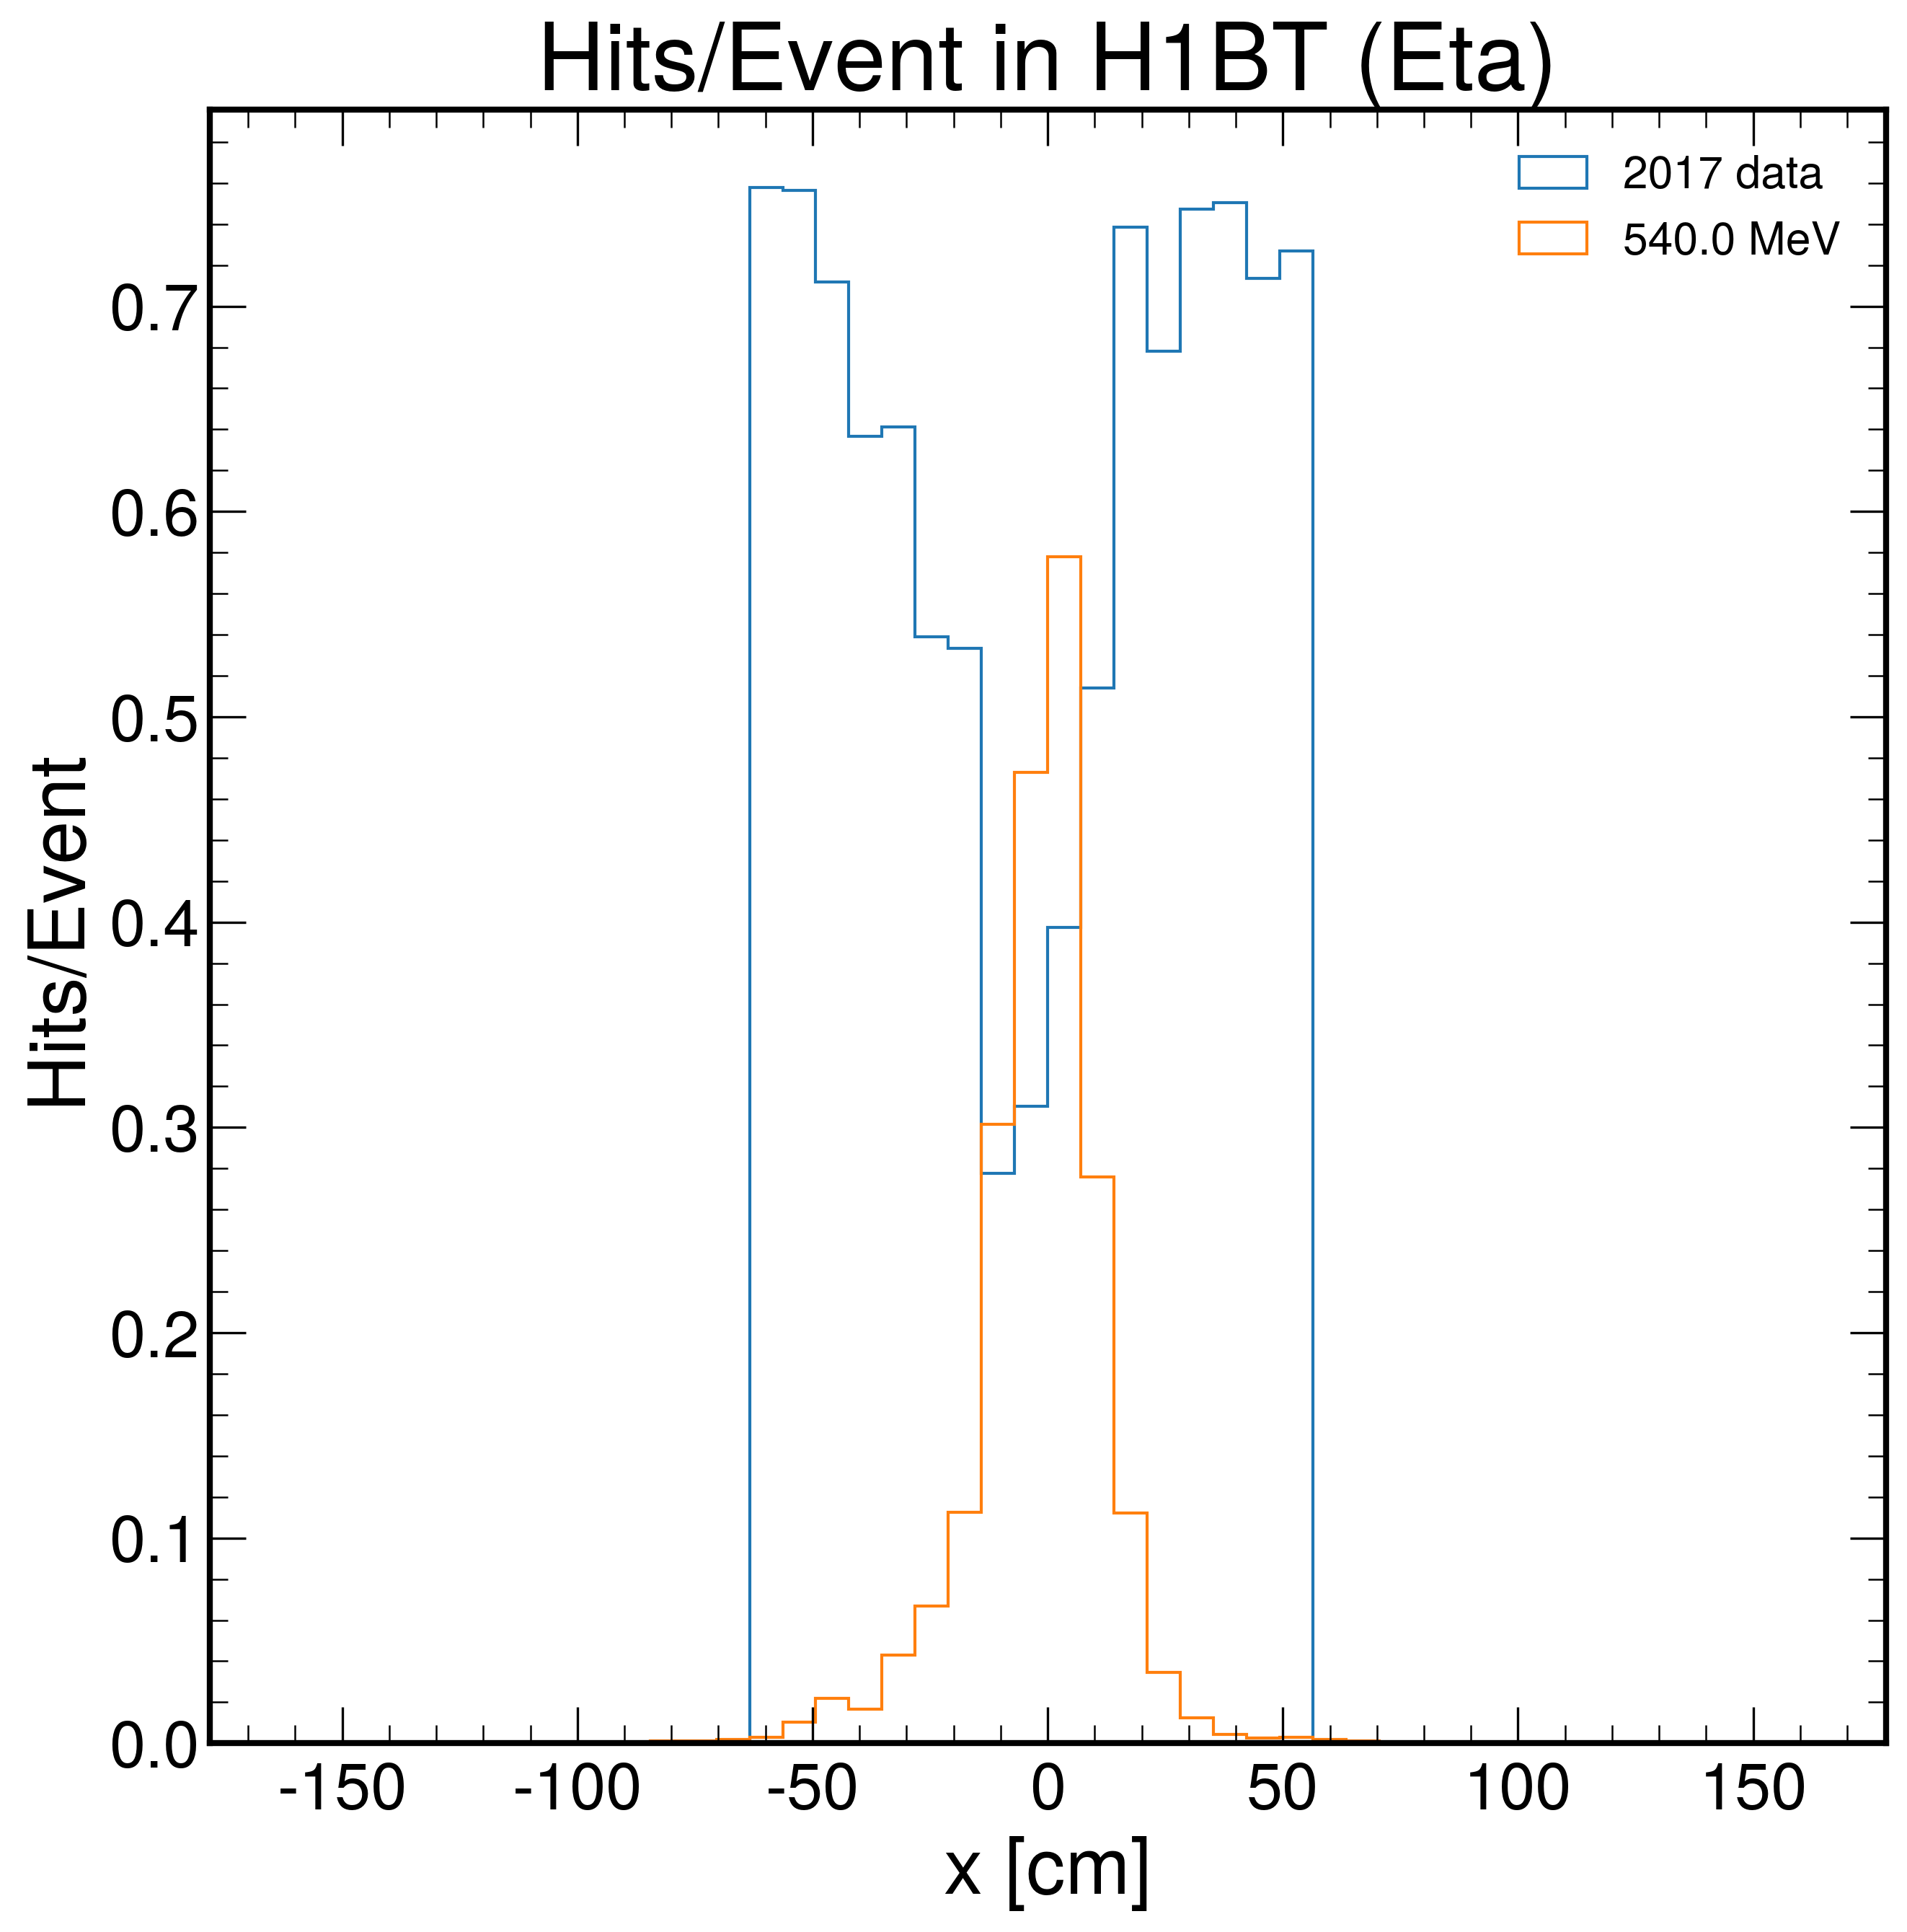

<Figure size 720x720 with 0 Axes>

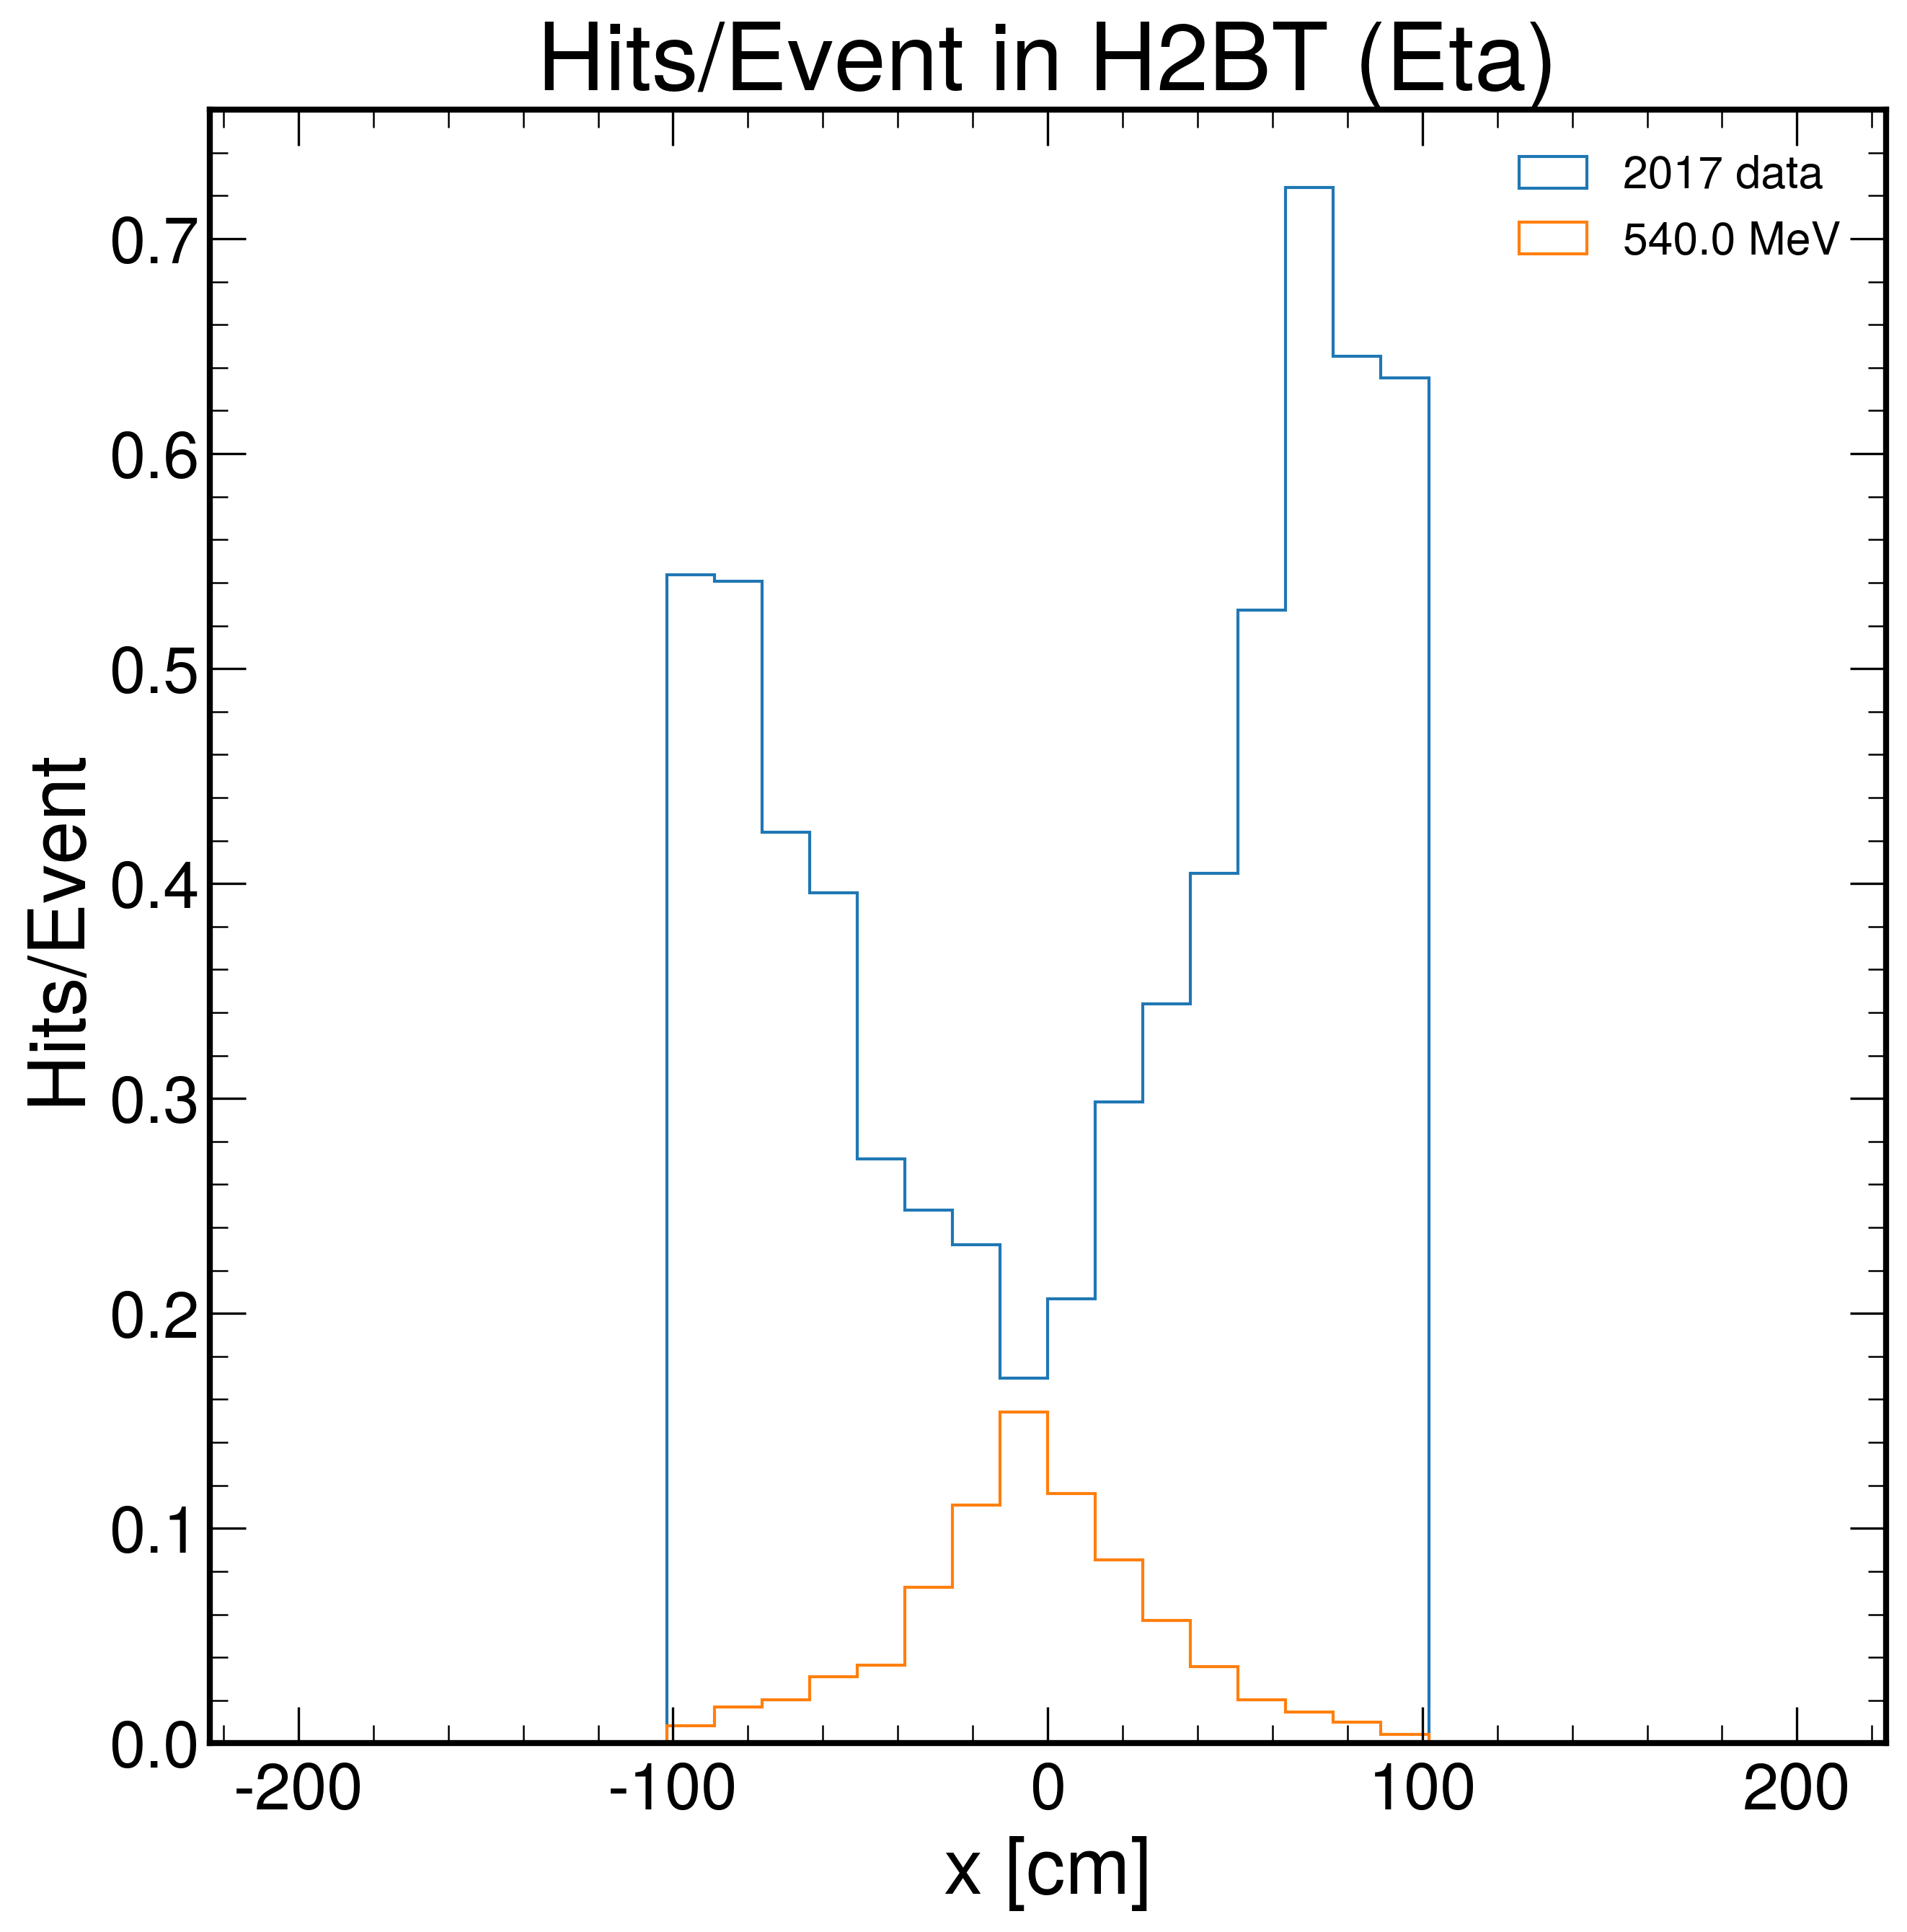

<Figure size 720x720 with 0 Axes>

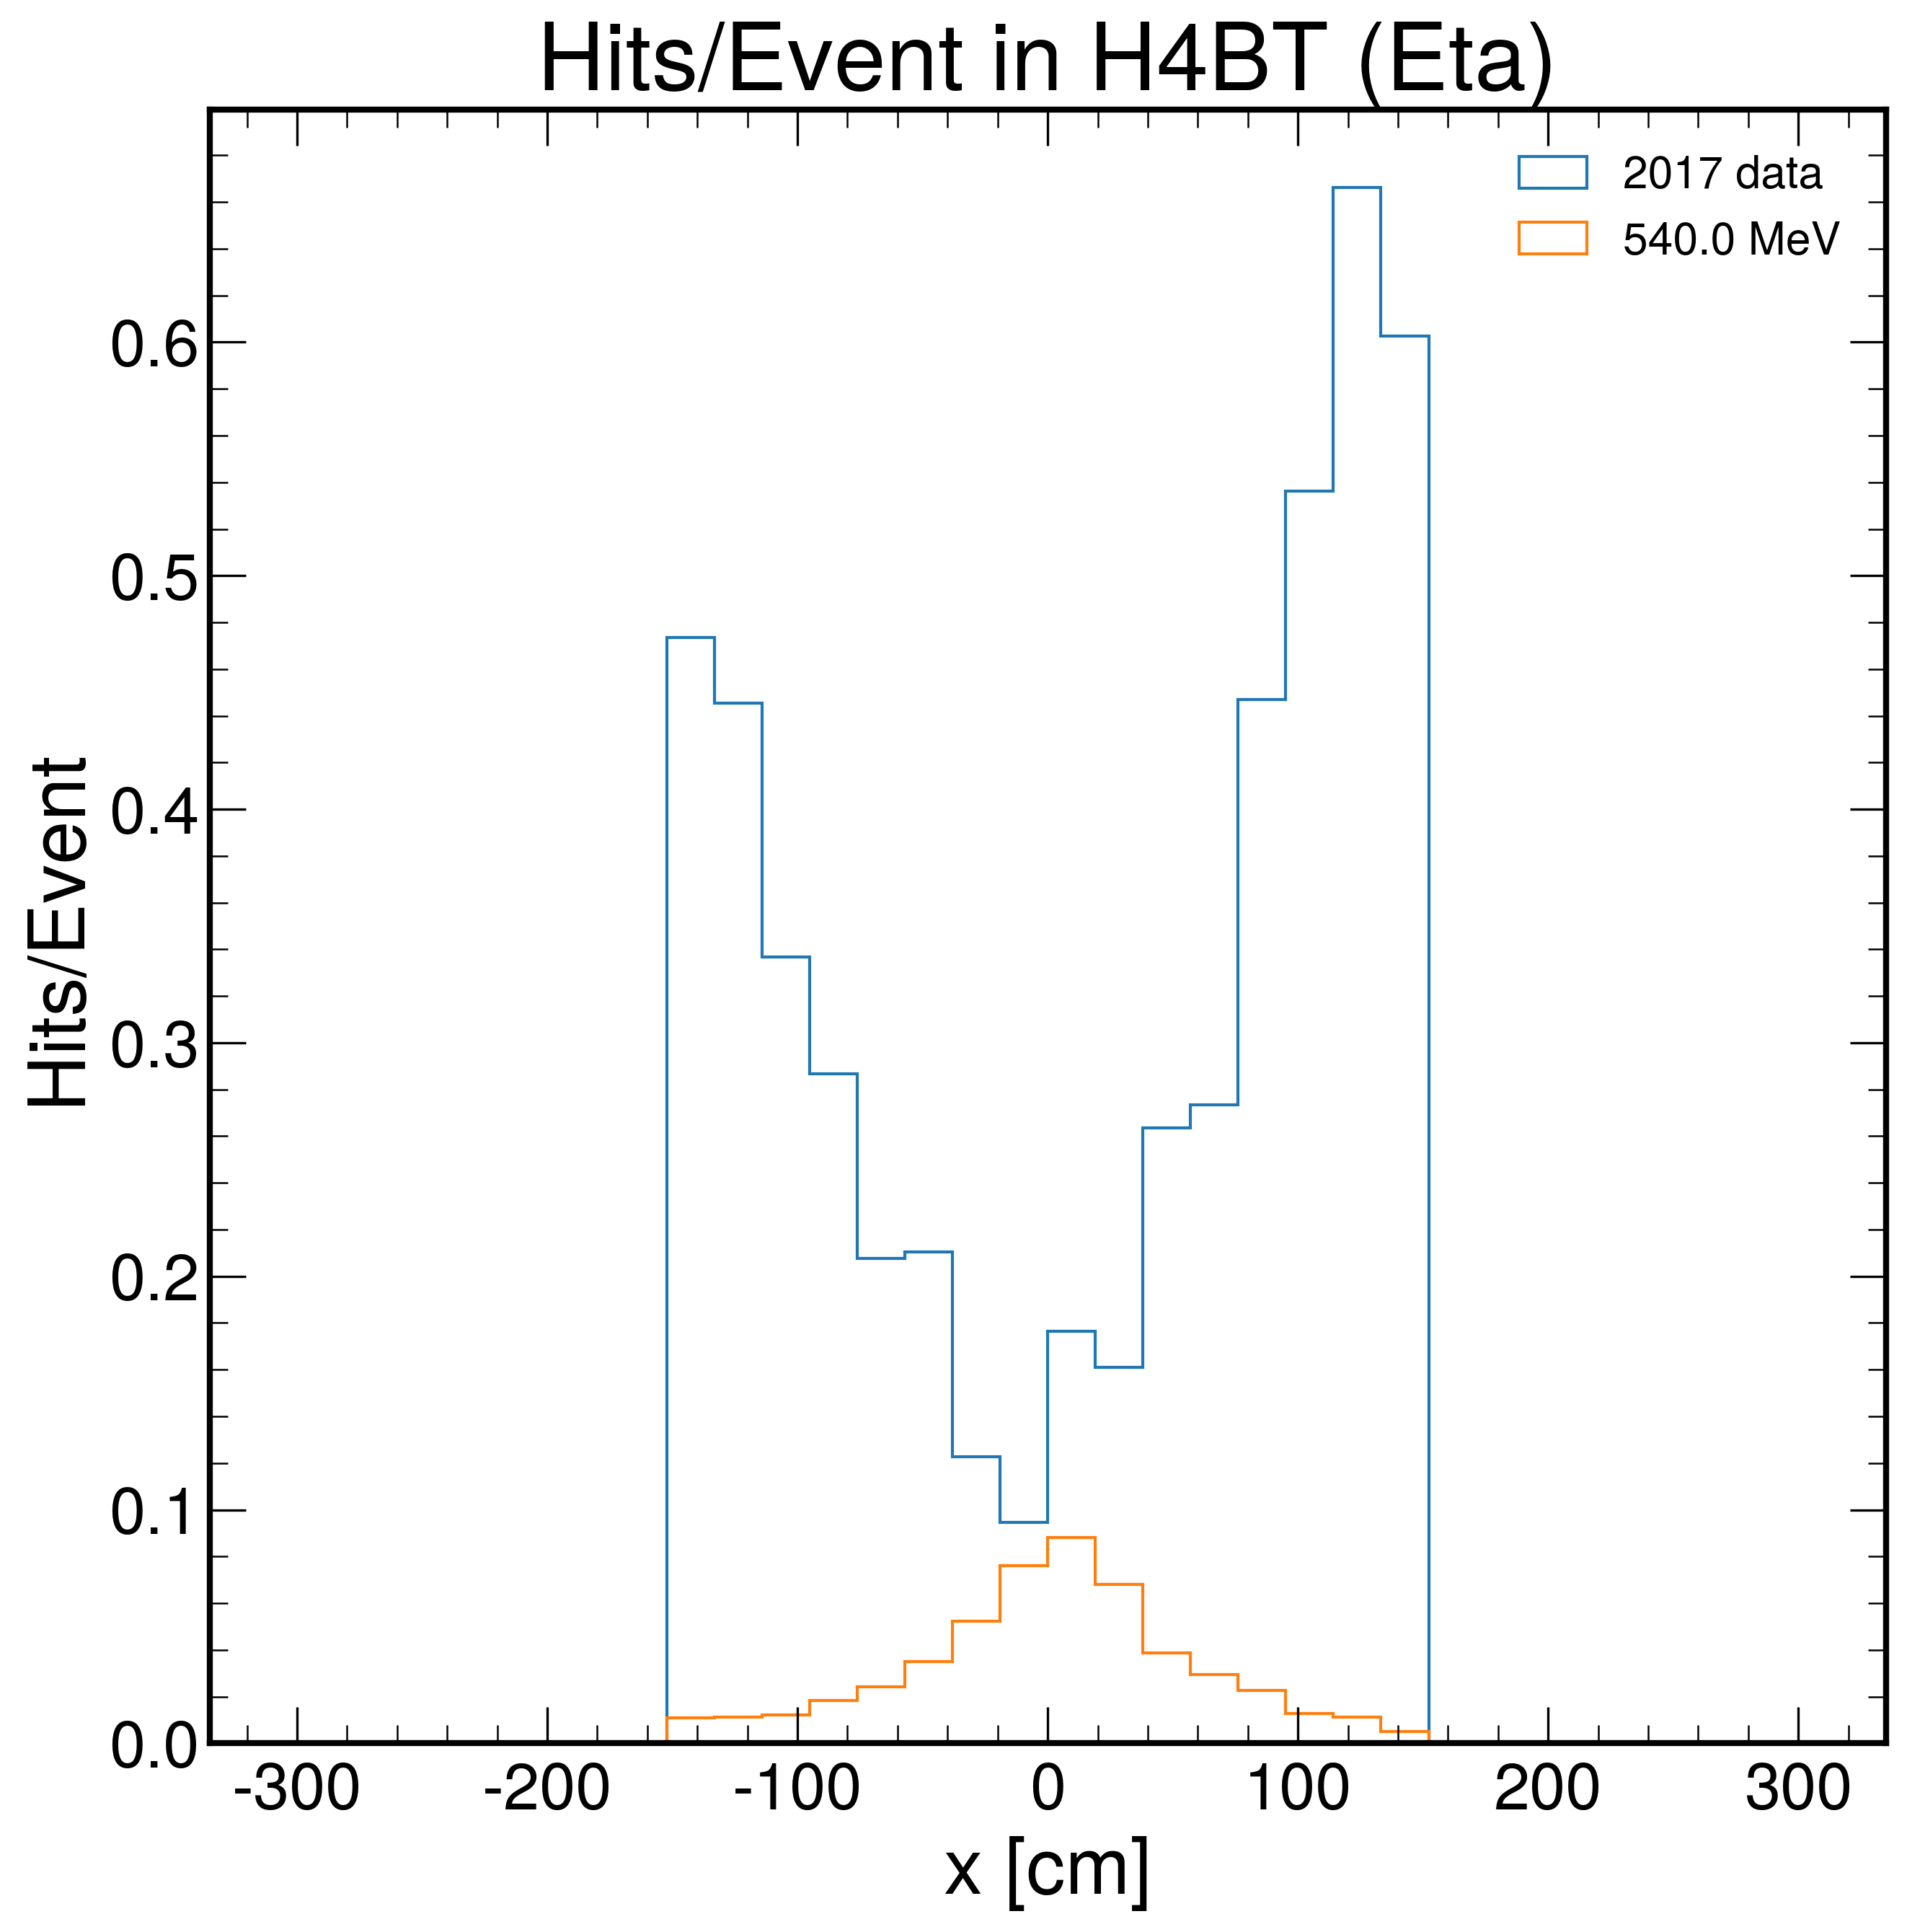

/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 720x720 with 0 Axes>

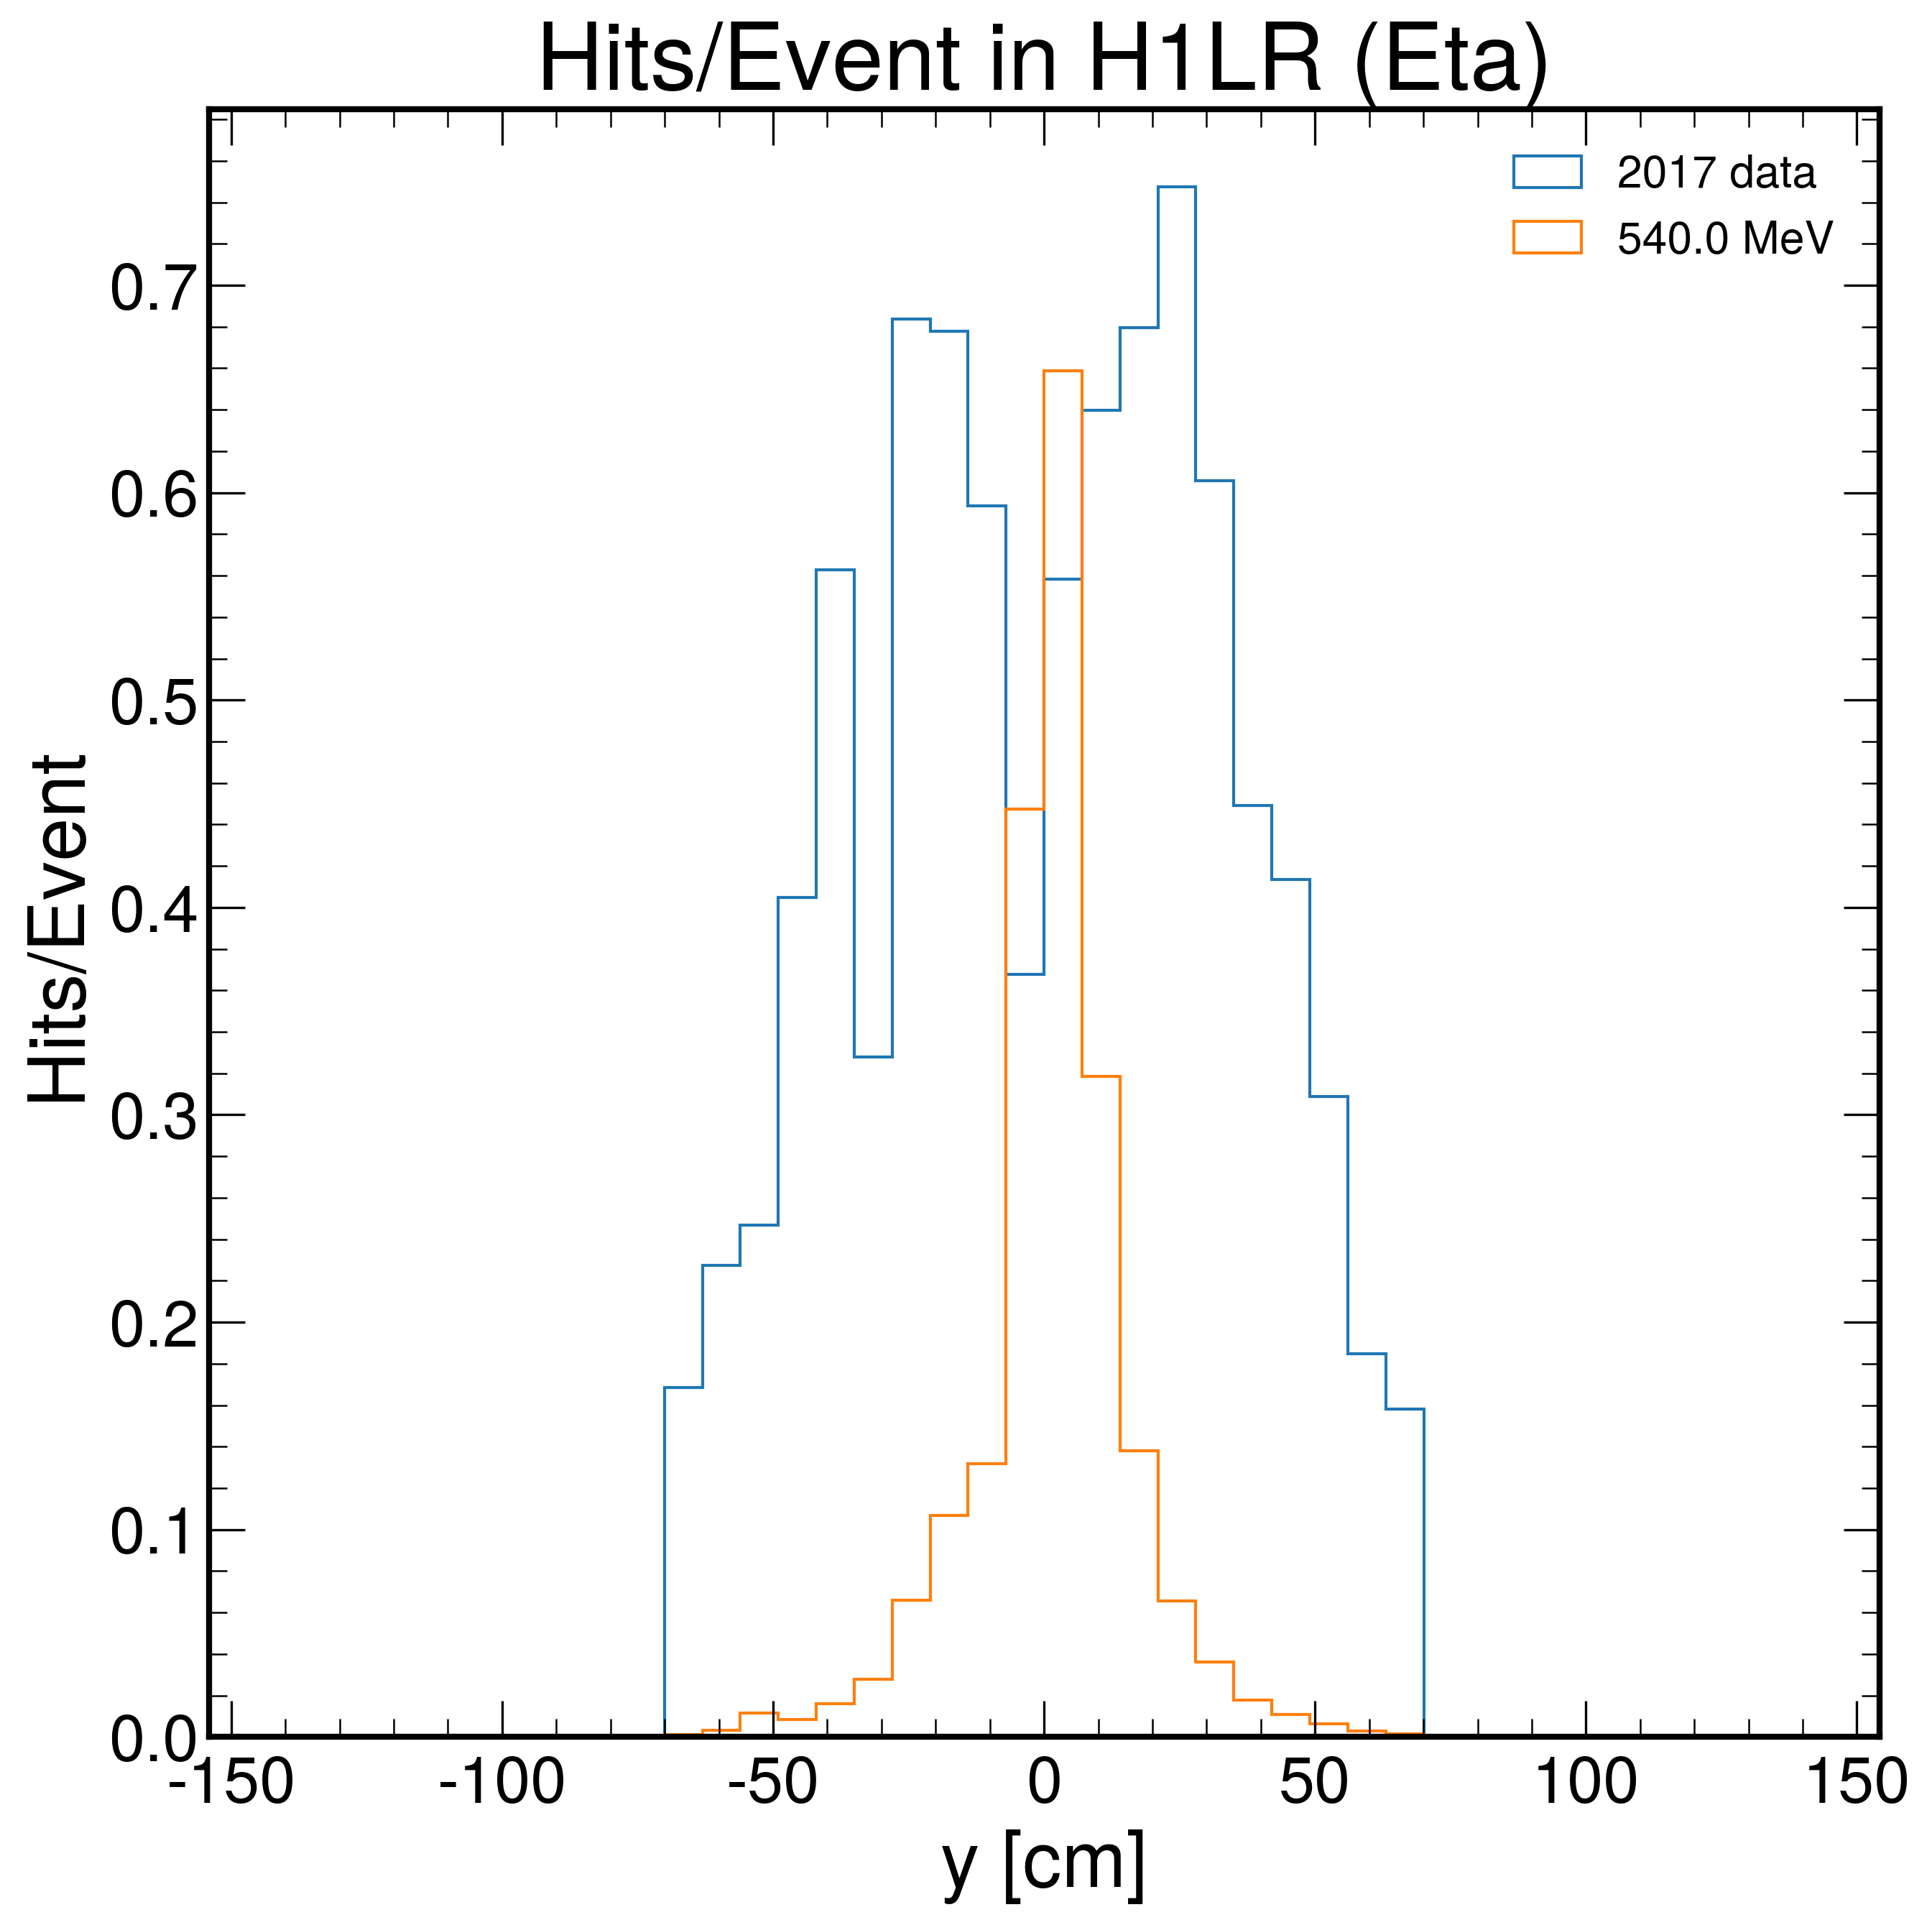

<Figure size 720x720 with 0 Axes>

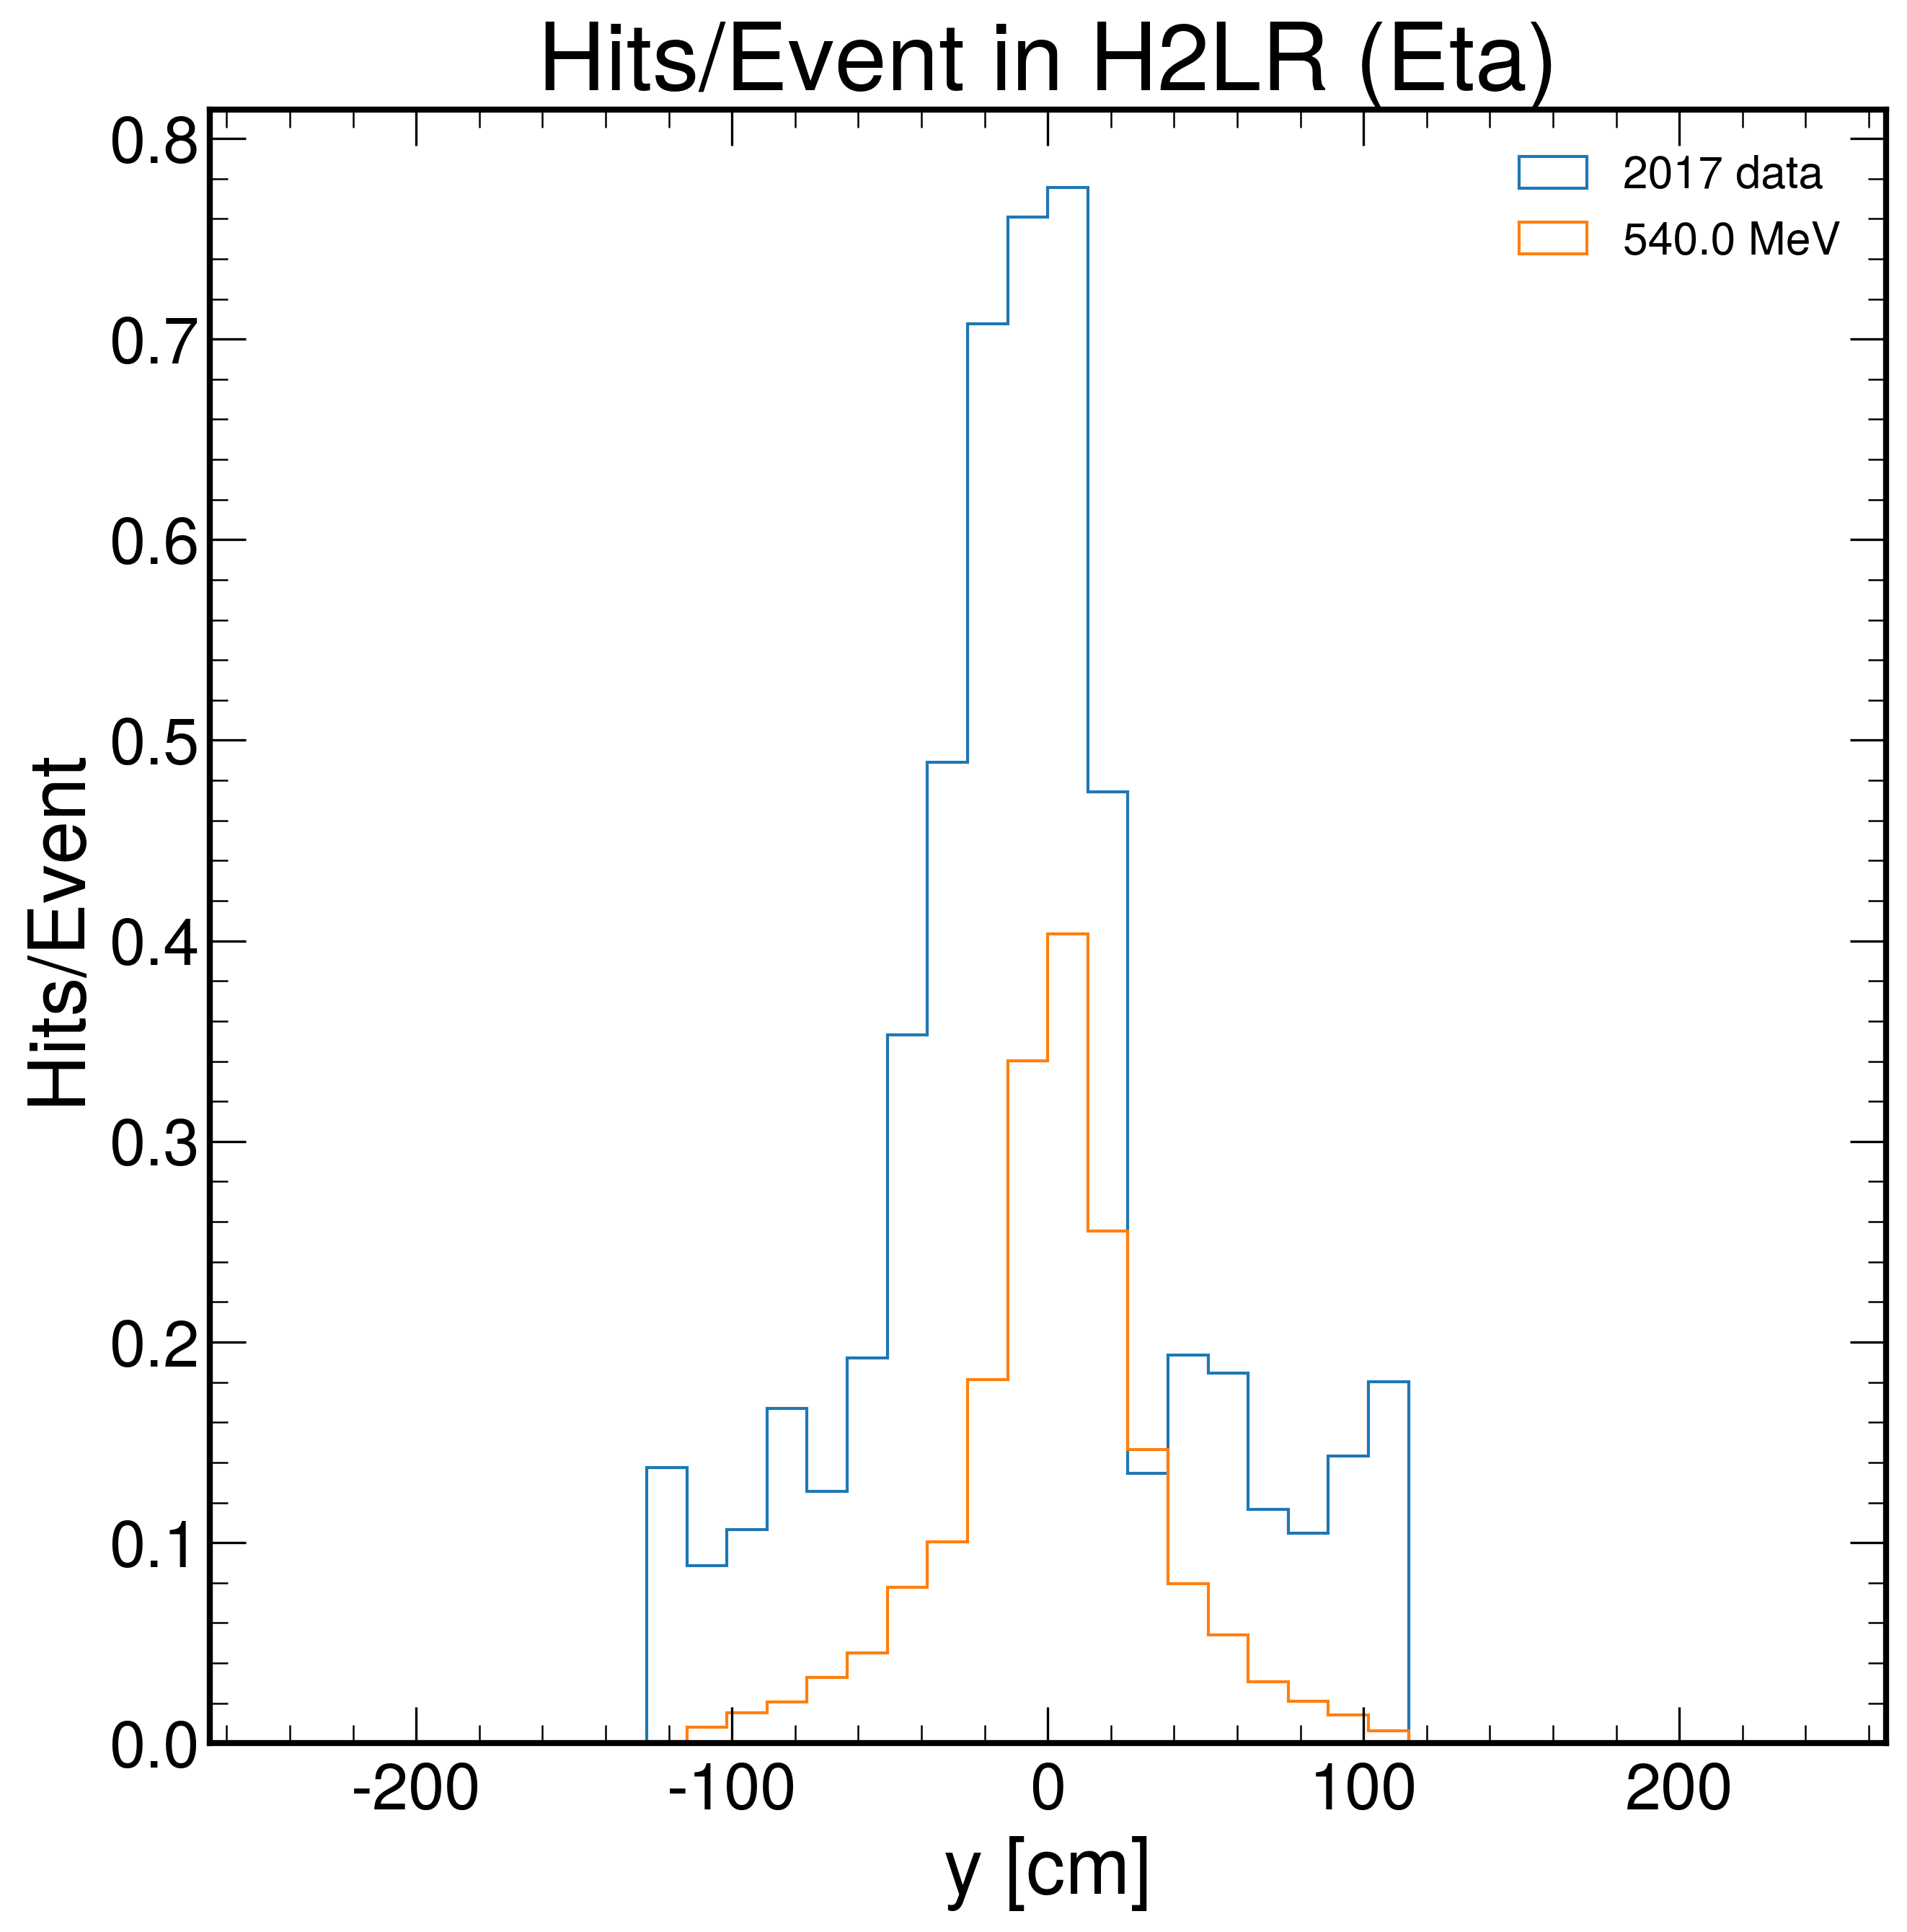

/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 720x720 with 0 Axes>

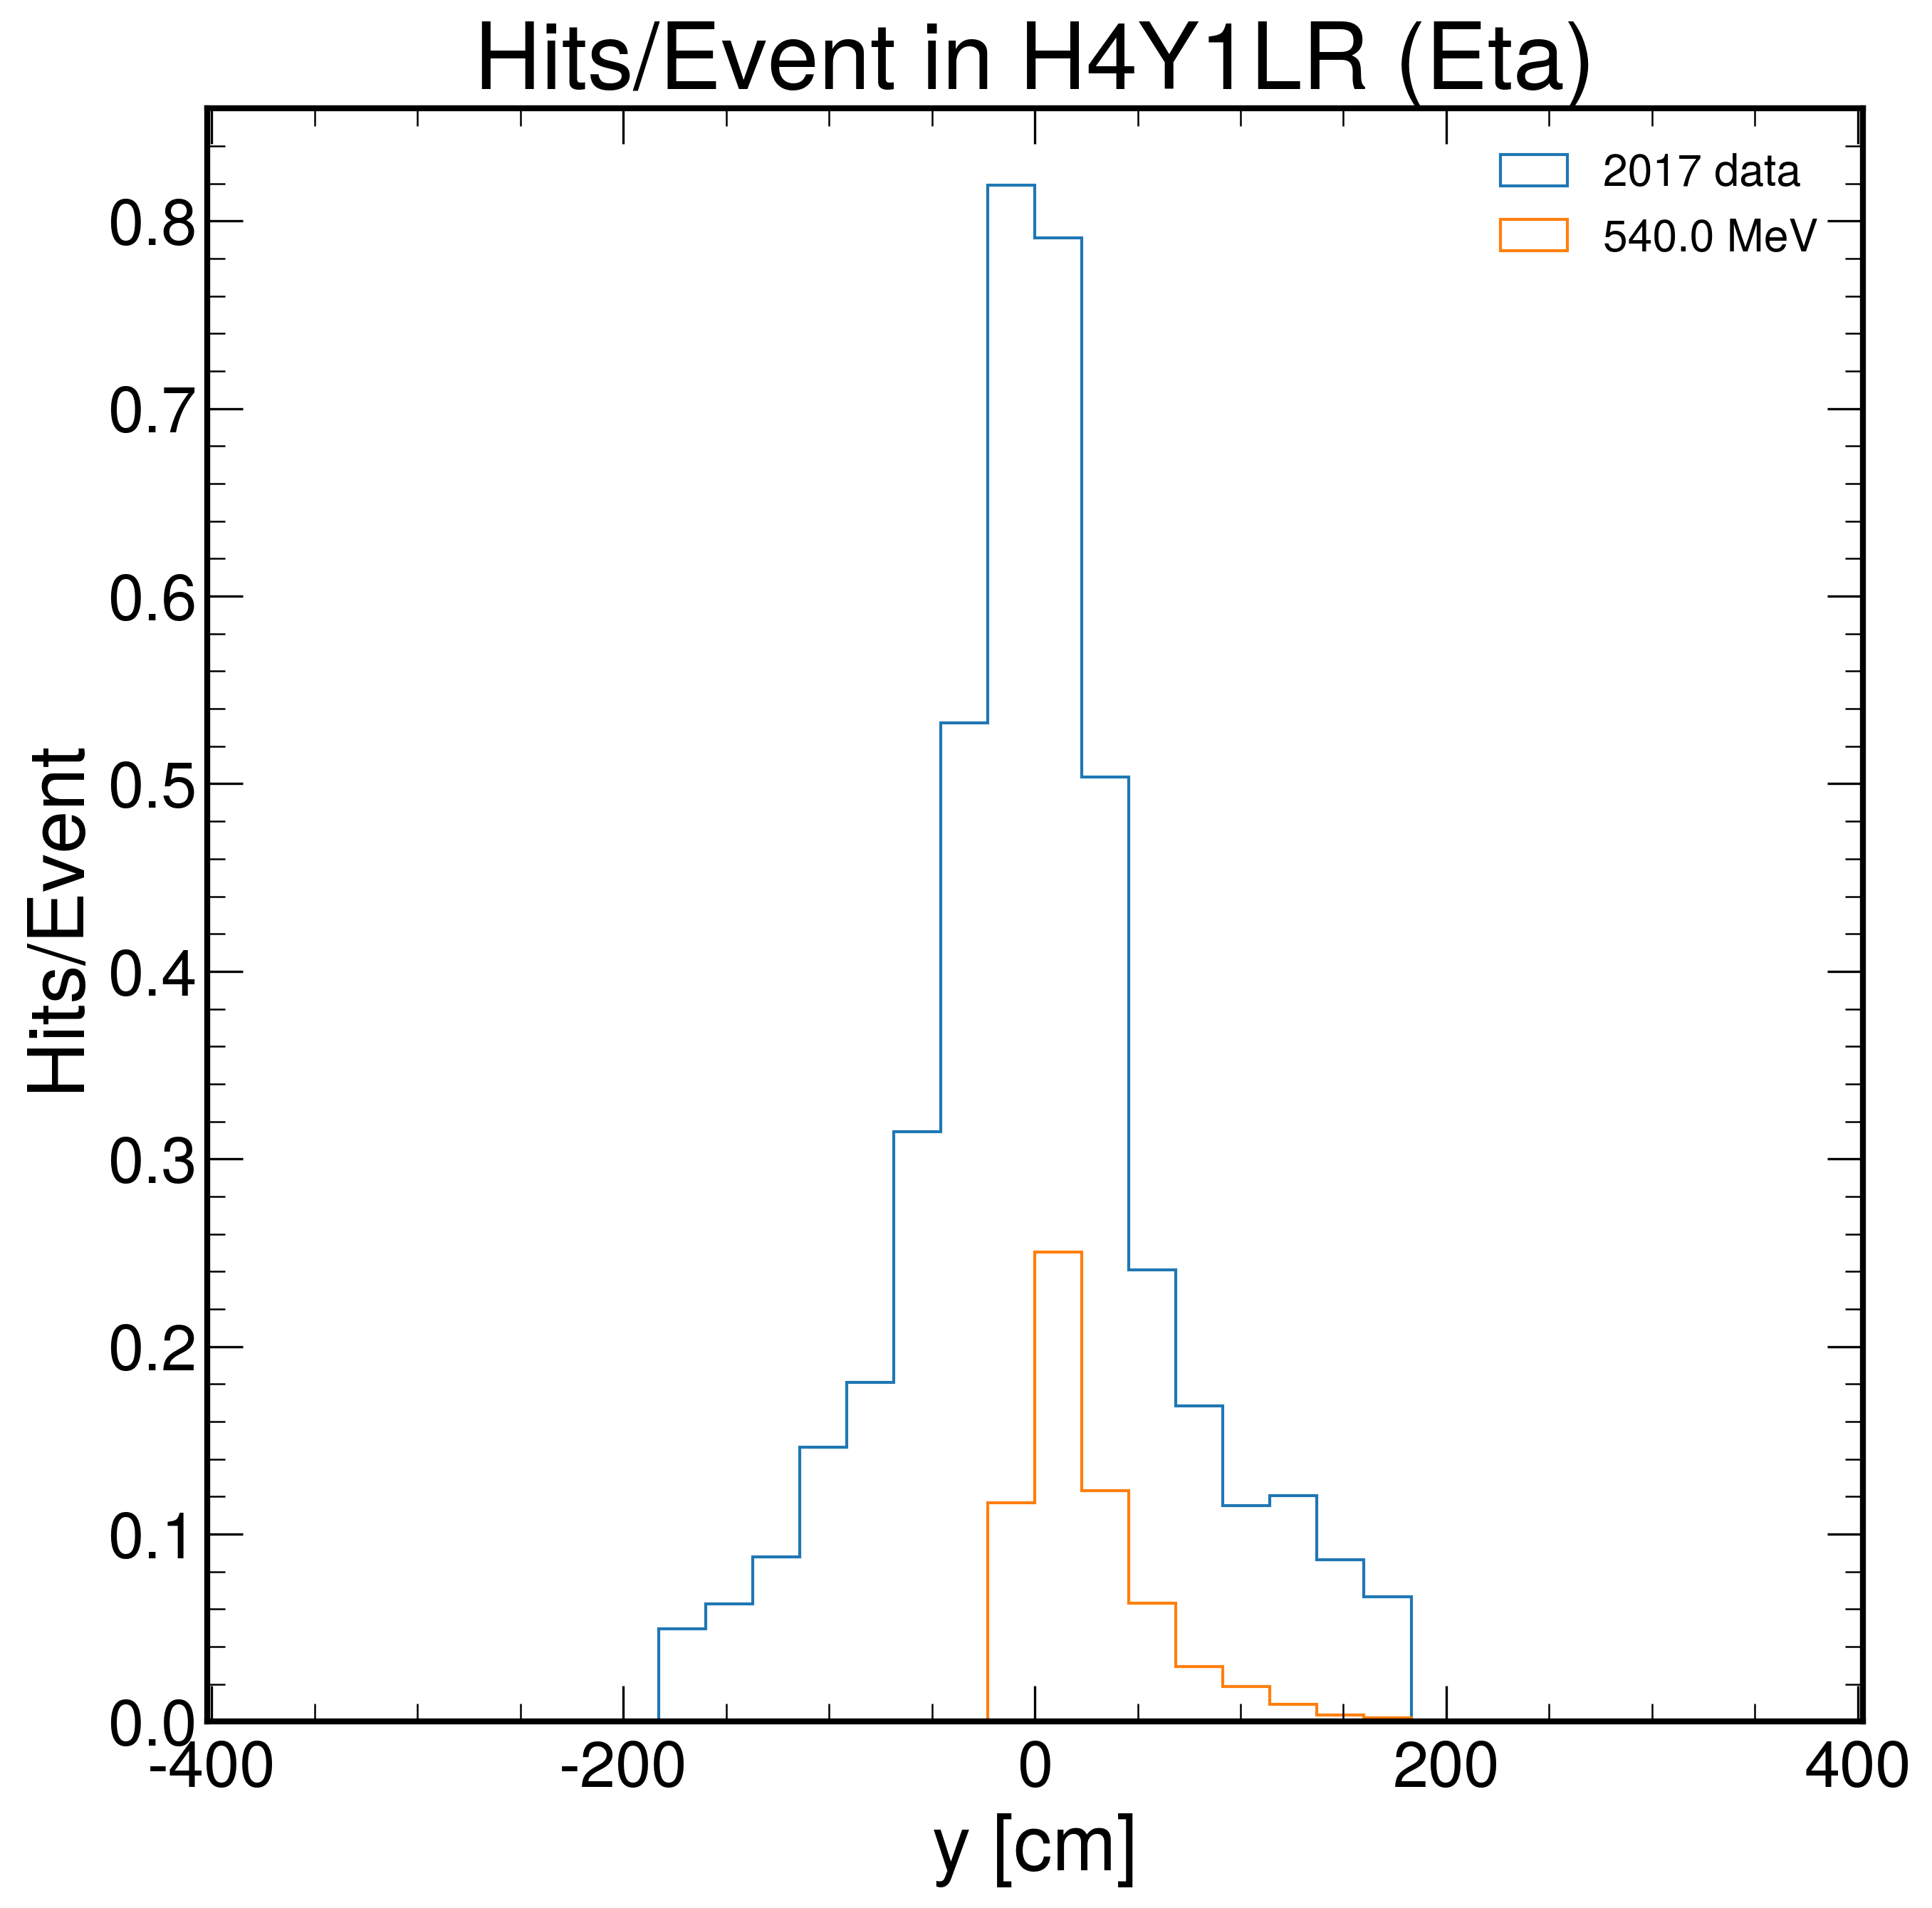

<Figure size 720x720 with 0 Axes>

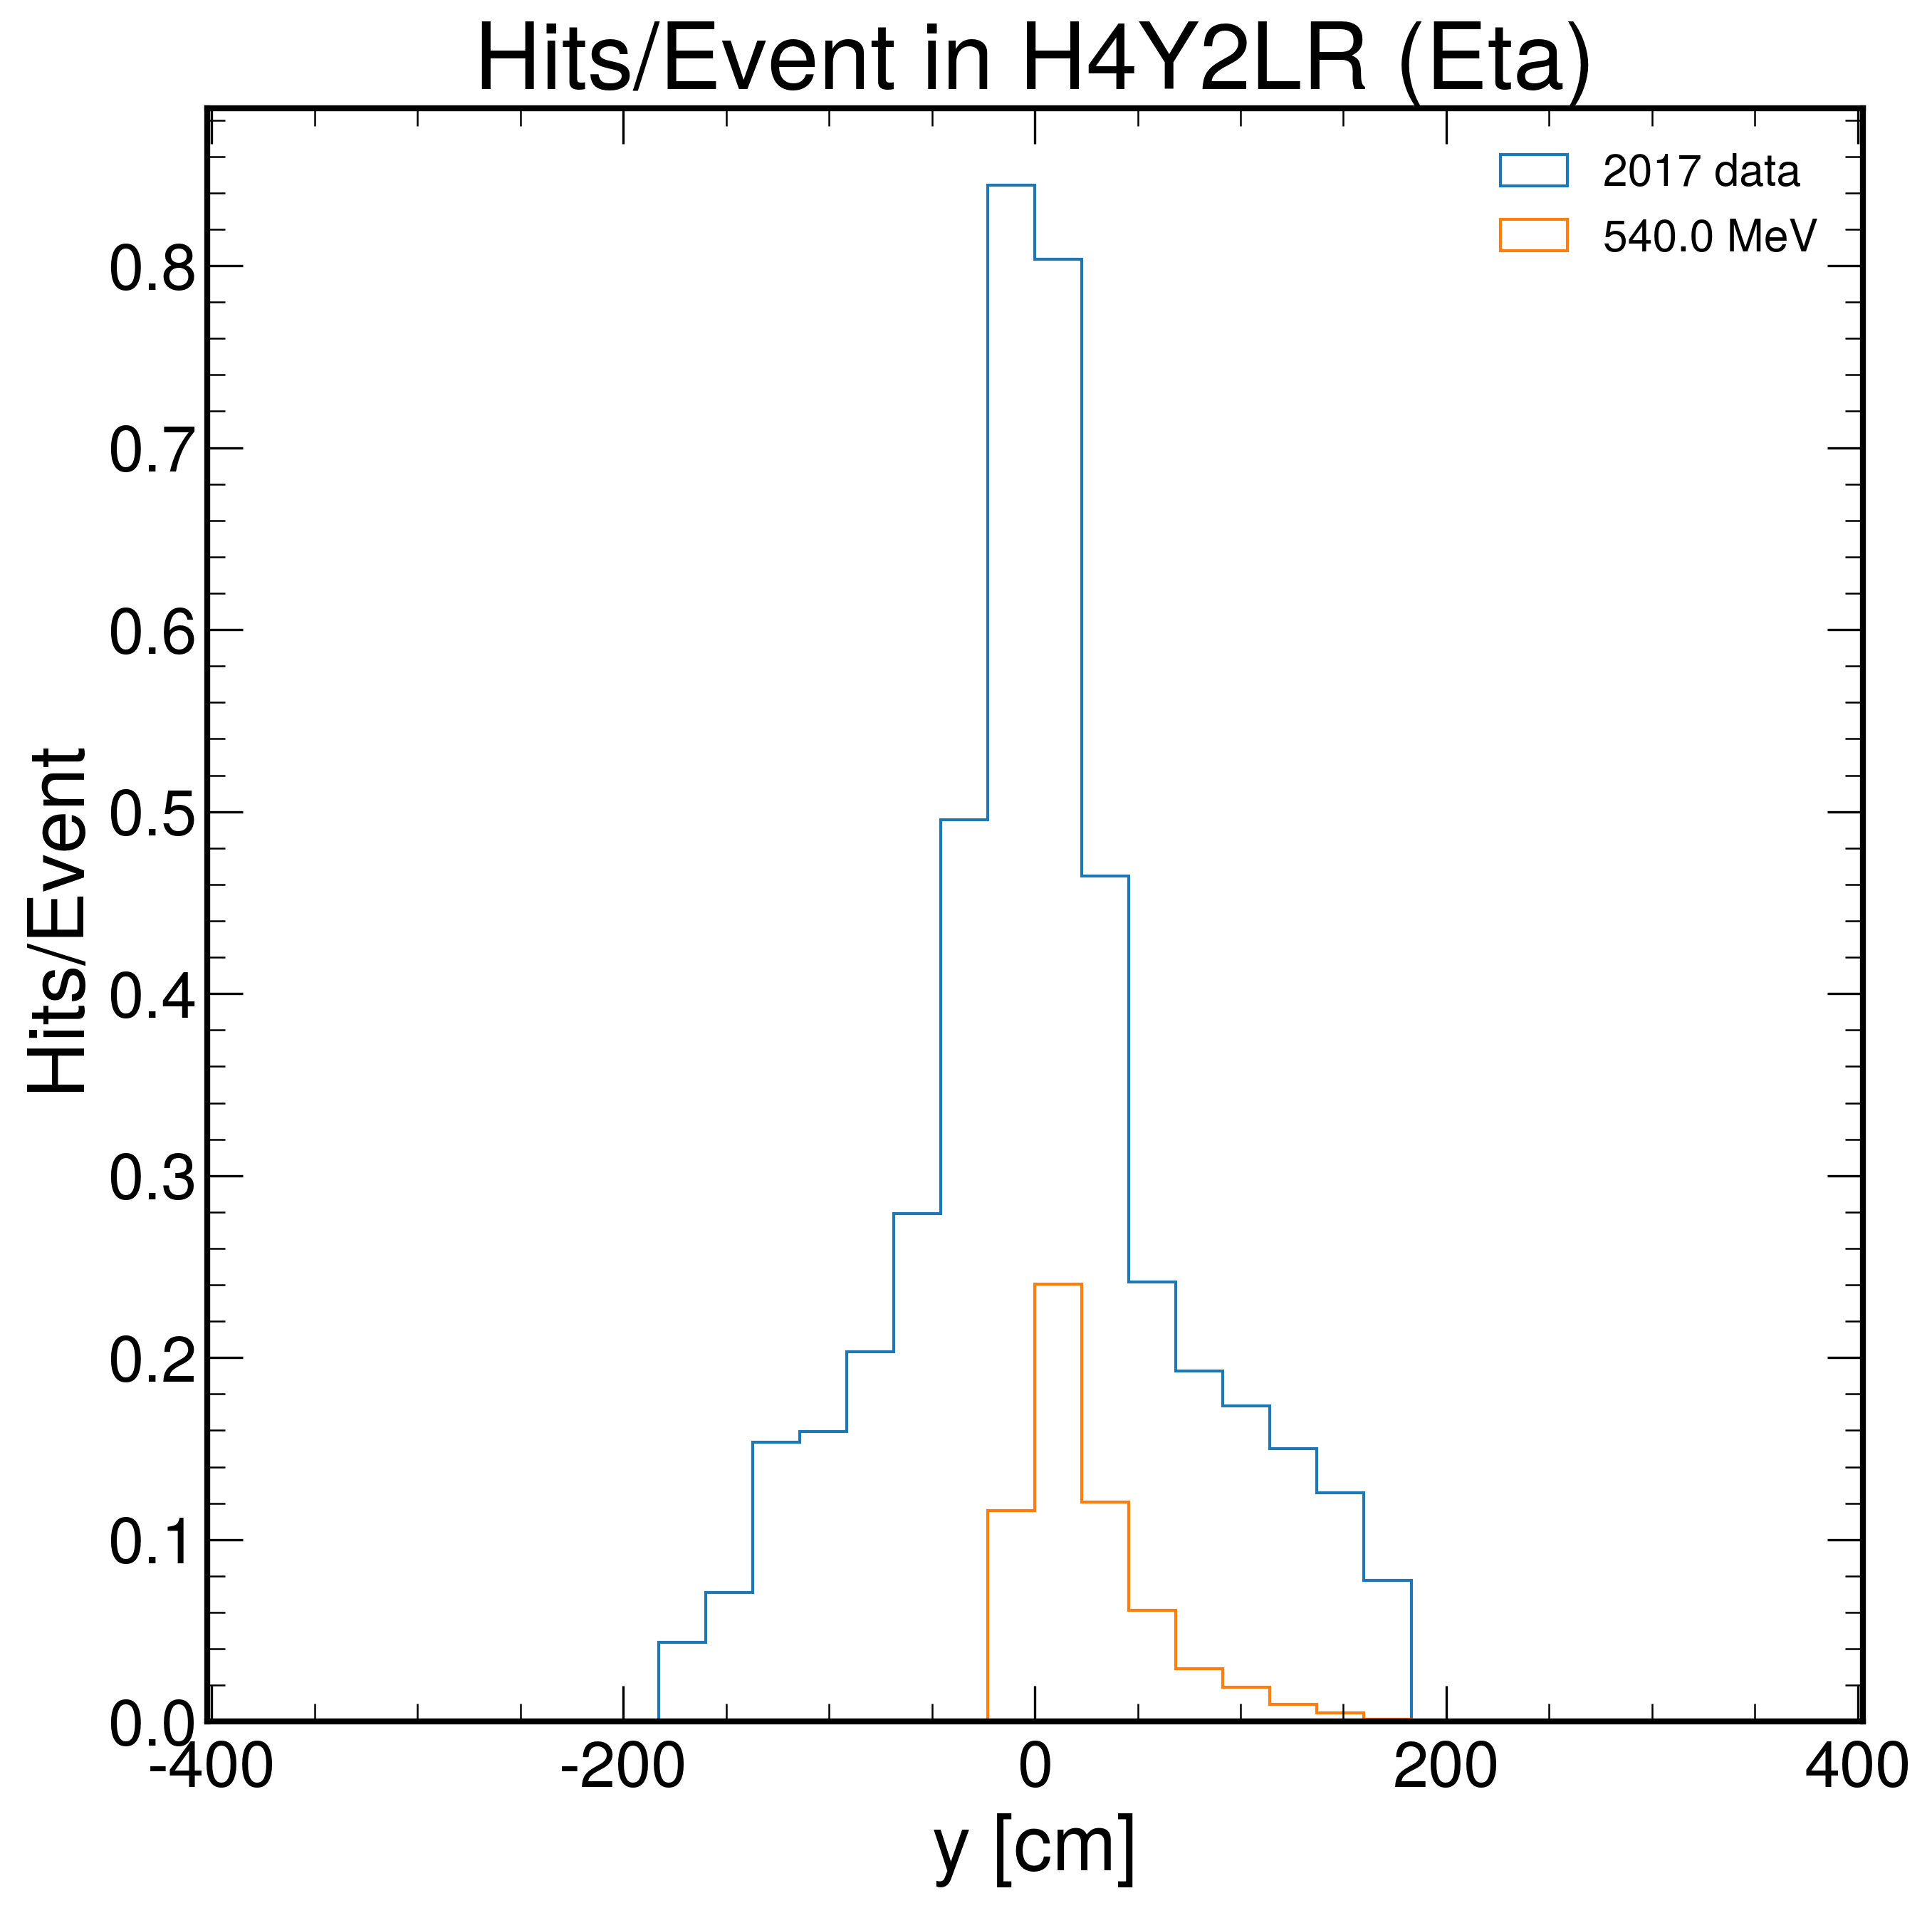

<Figure size 720x720 with 0 Axes>

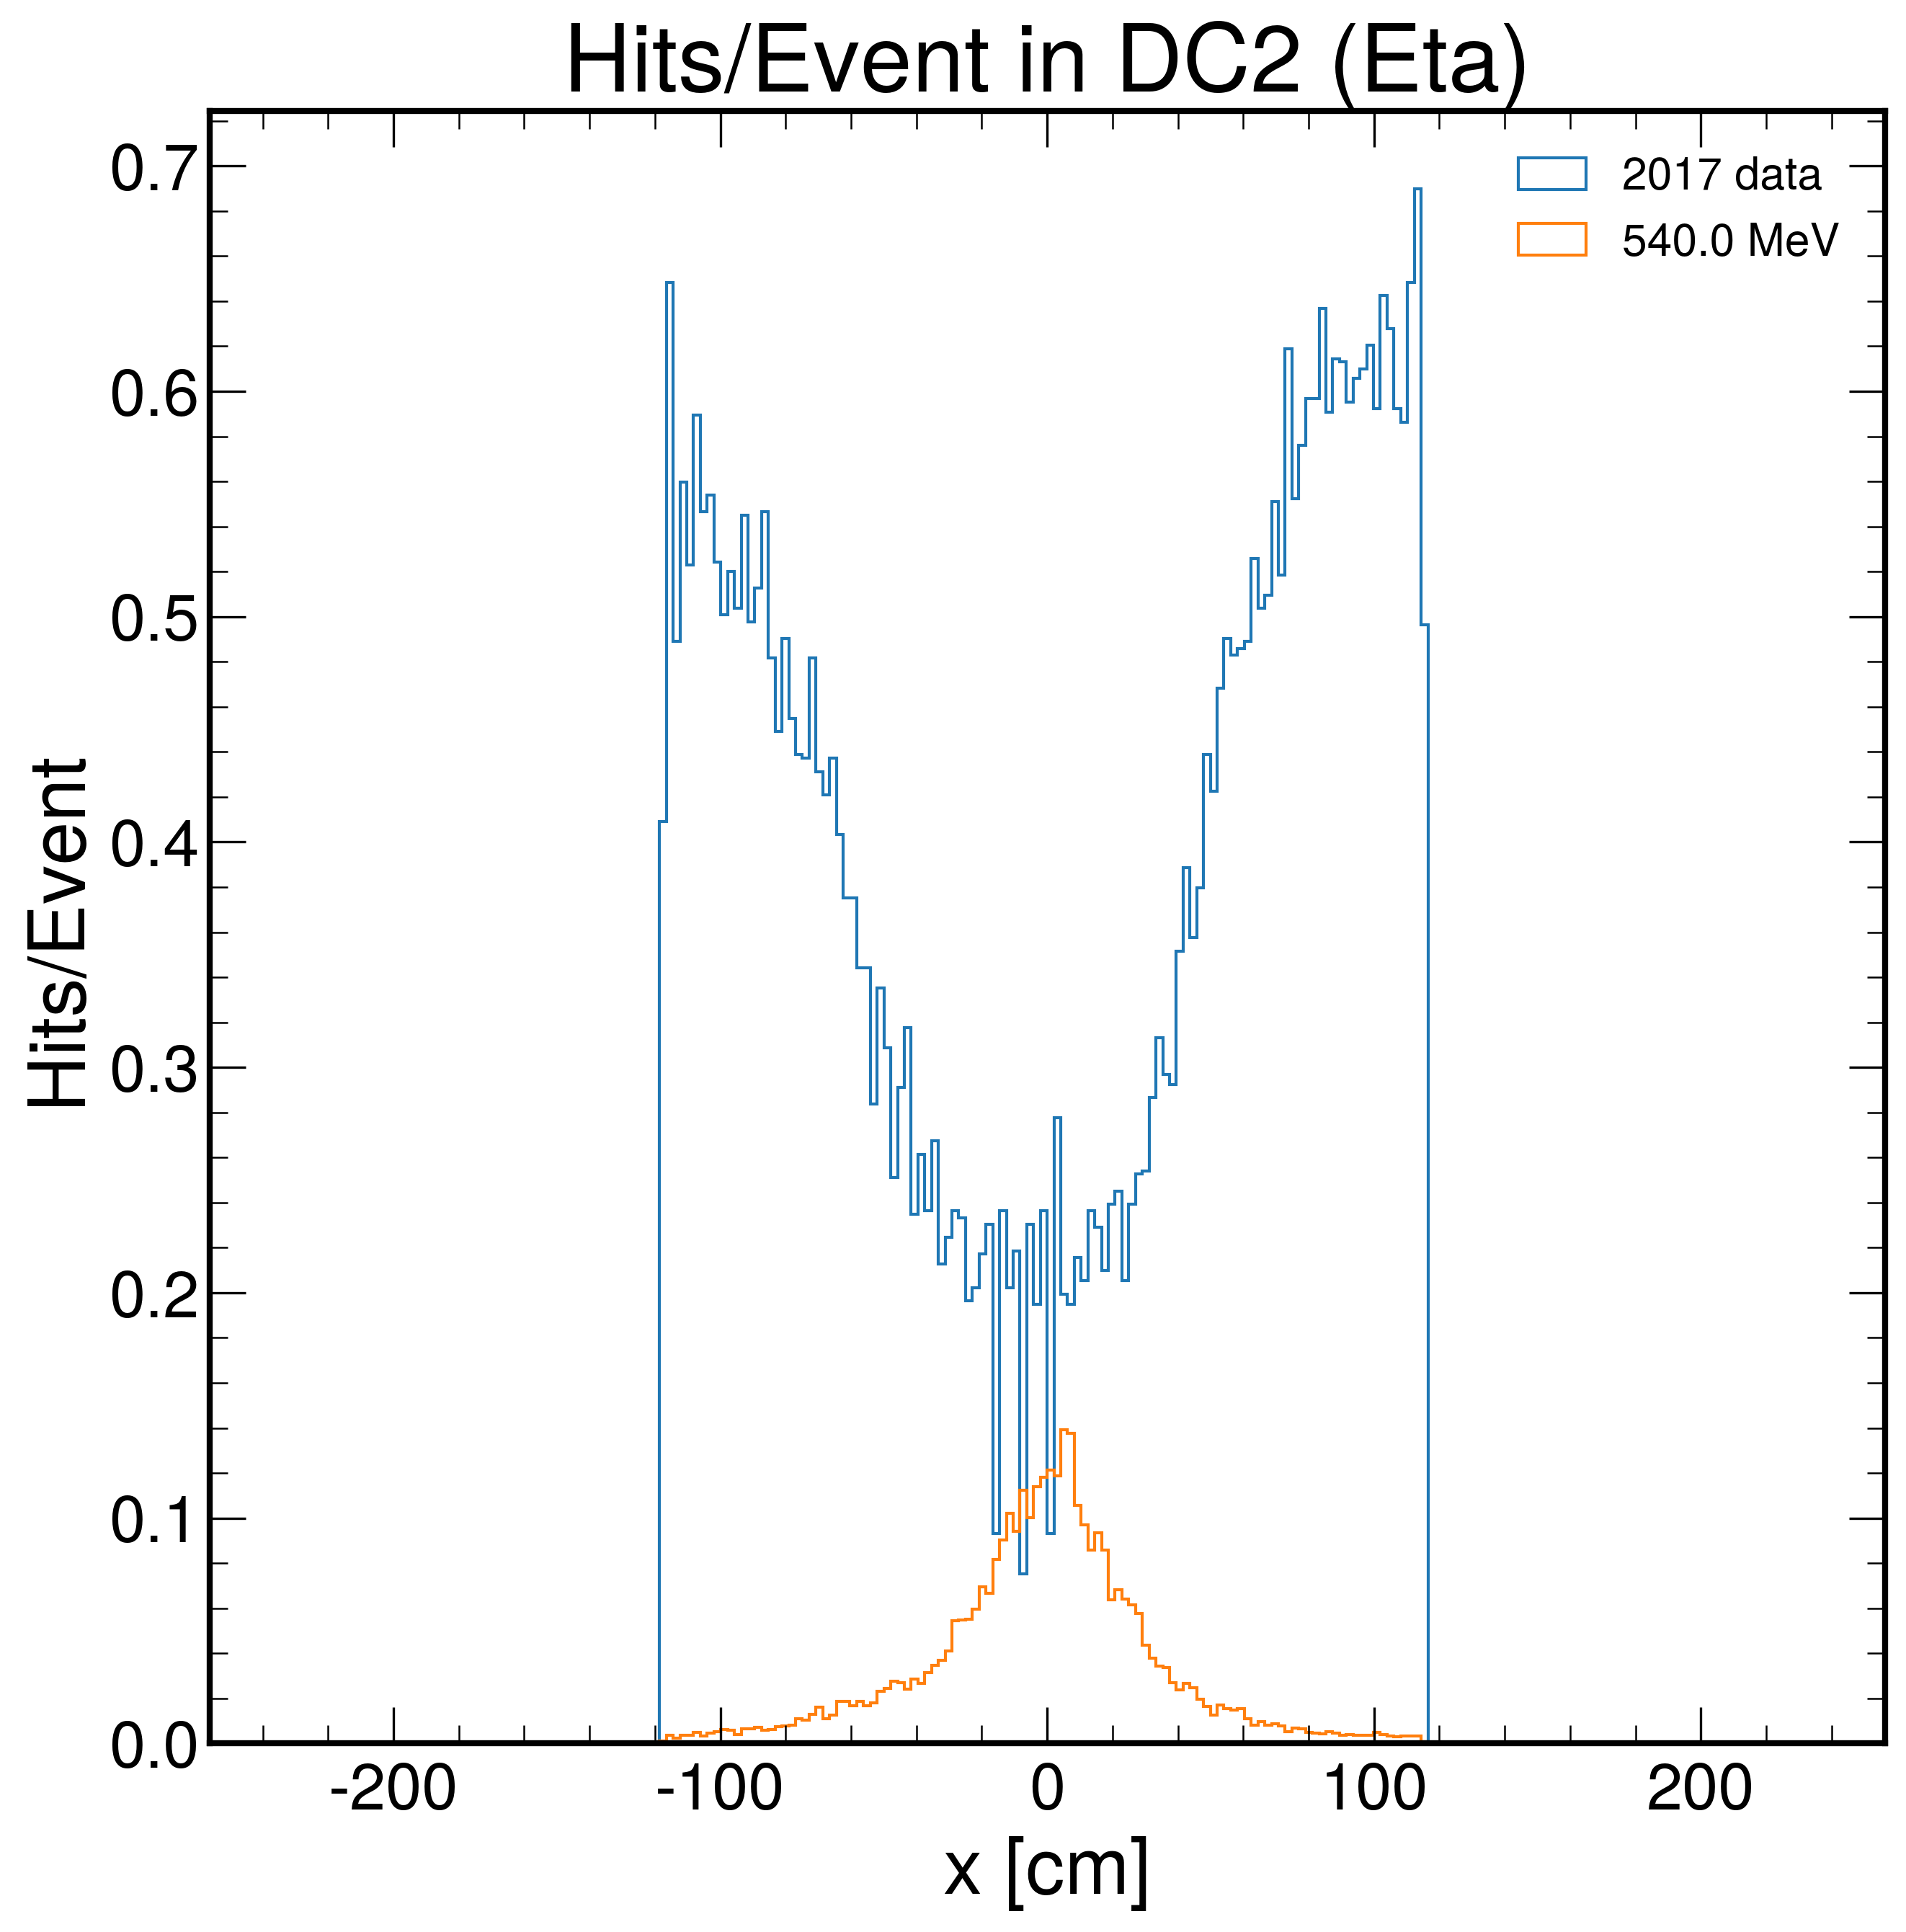

In [18]:
a = layer4BG(root,layer=[0])
b = layer4Sim(Truth054,layer=[0])
plot_overlay(a,b,Eta054,weighted=True,noCuts=True)

Next, let's look at what happens if we impose cuts. First, a cut on station1 from `x = [-30,20]`

<Figure size 720x720 with 0 Axes>

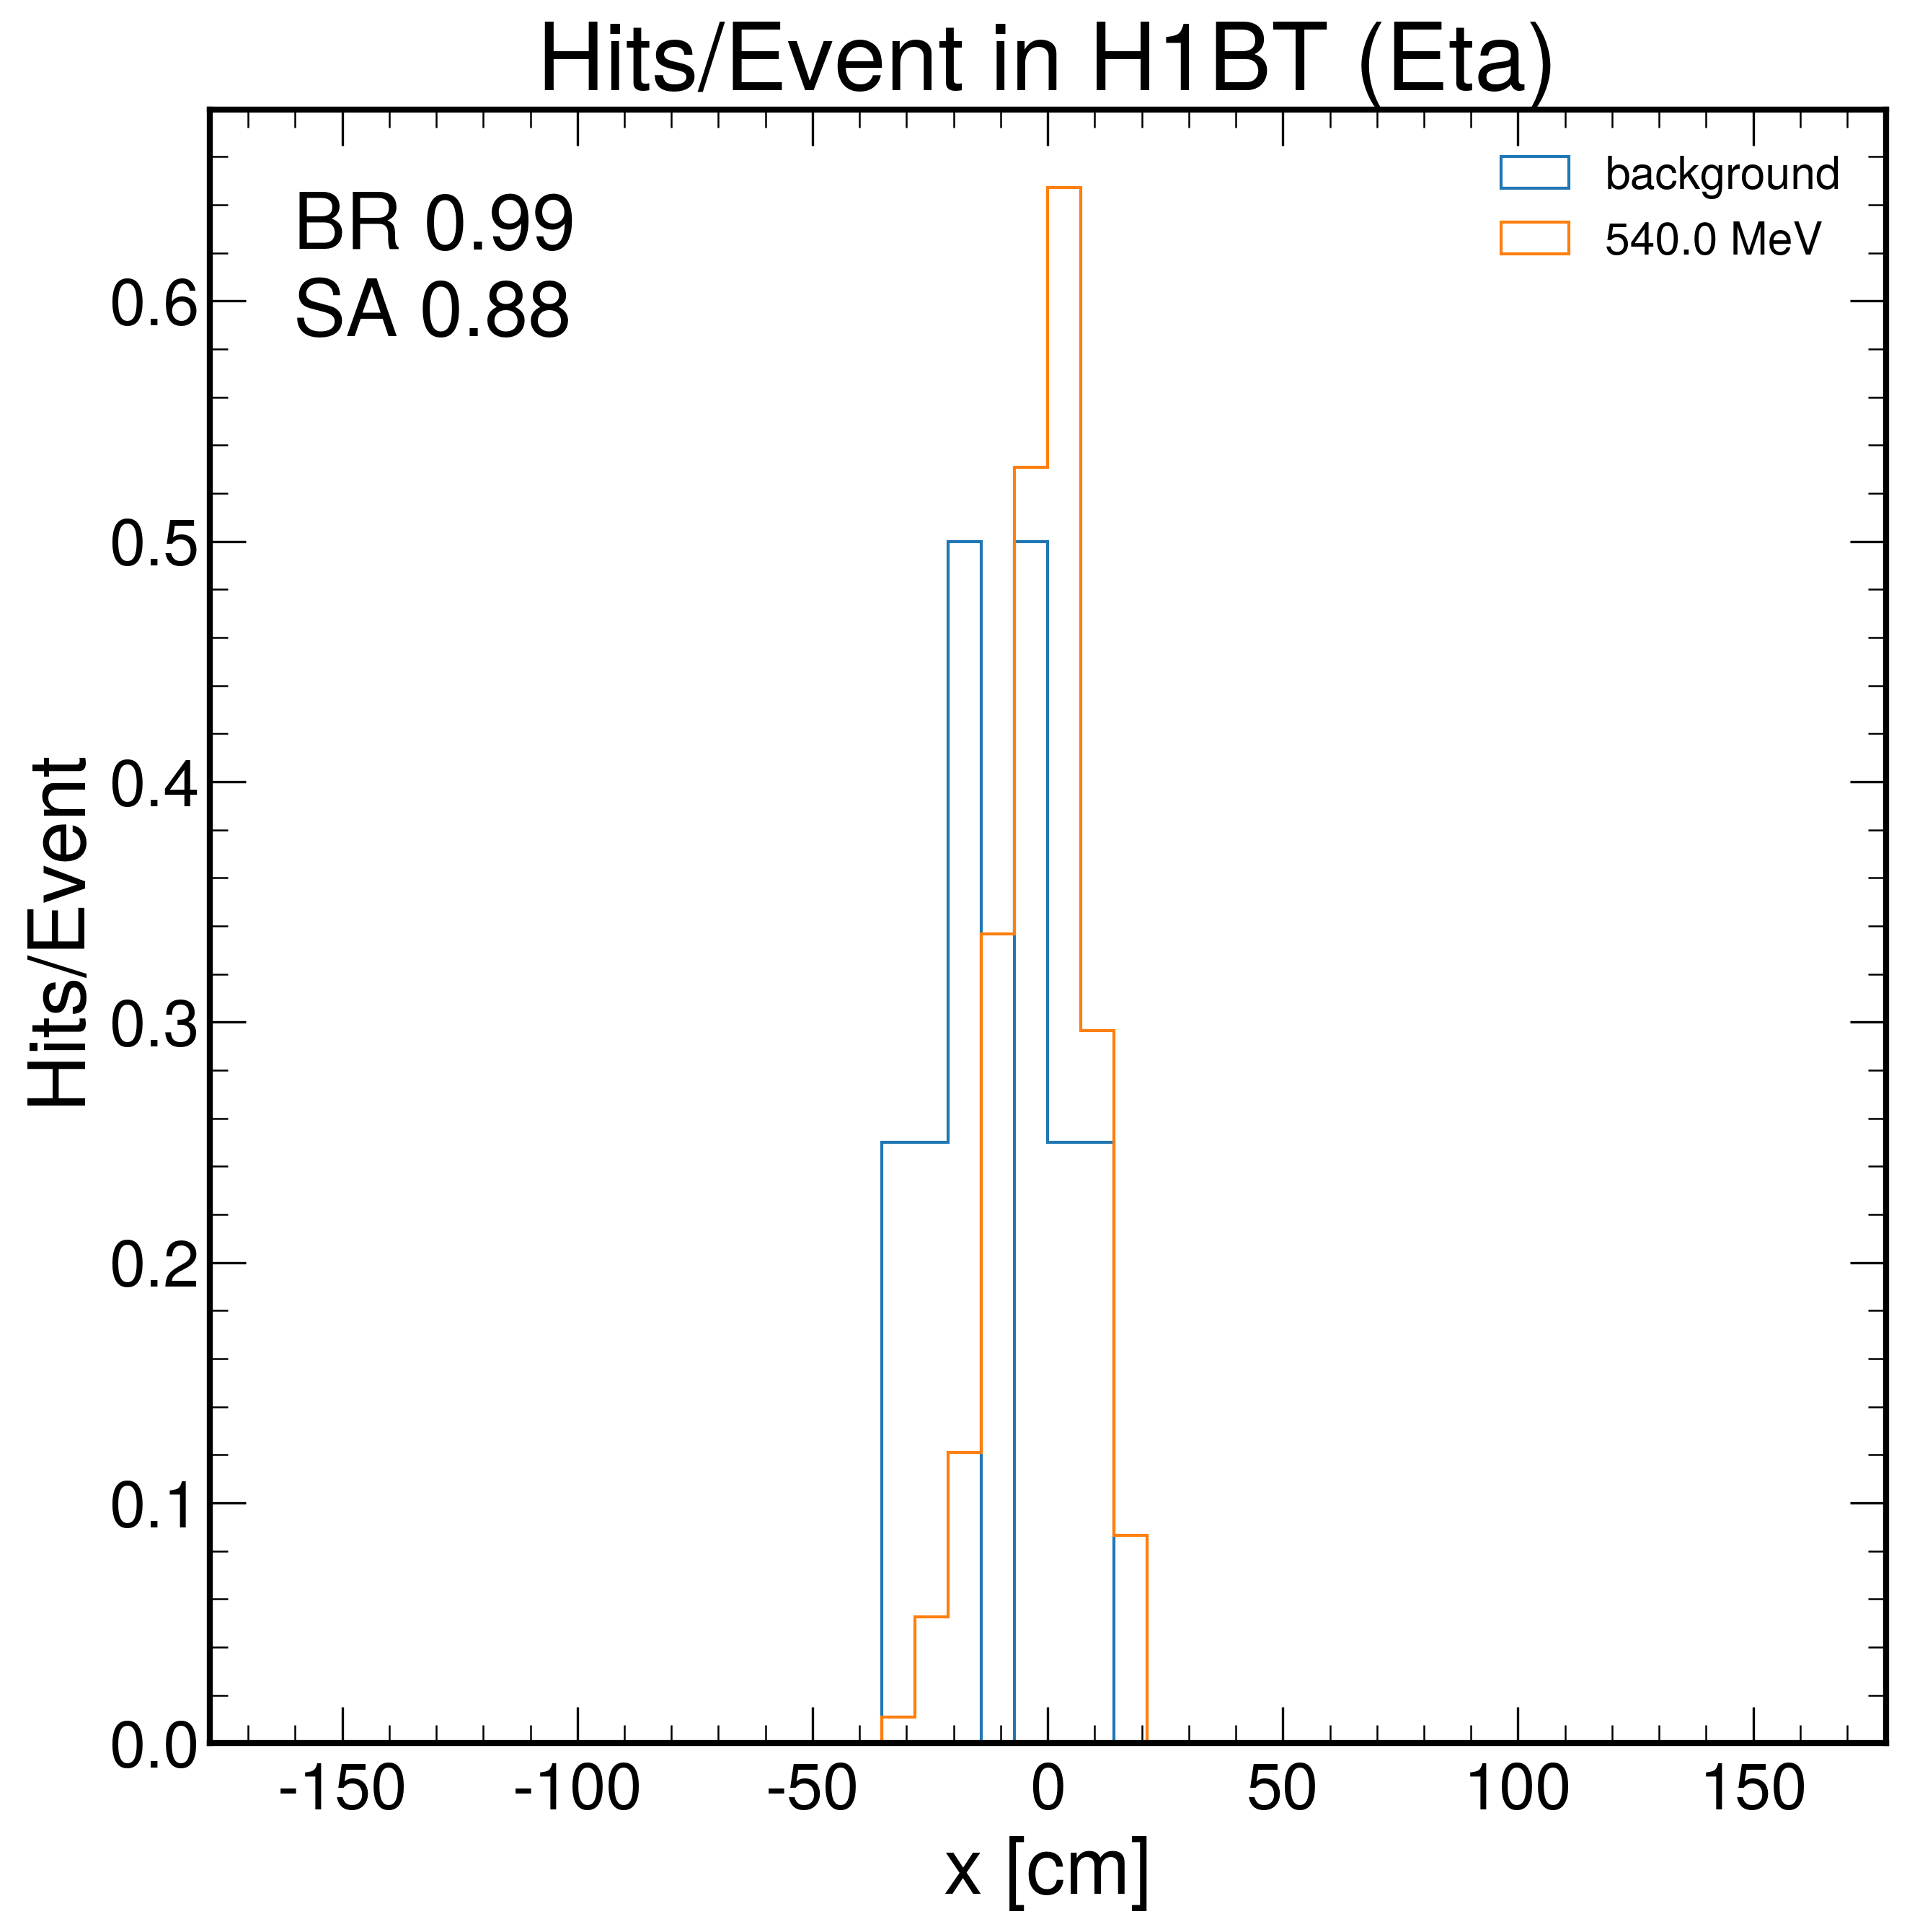

<Figure size 720x720 with 0 Axes>

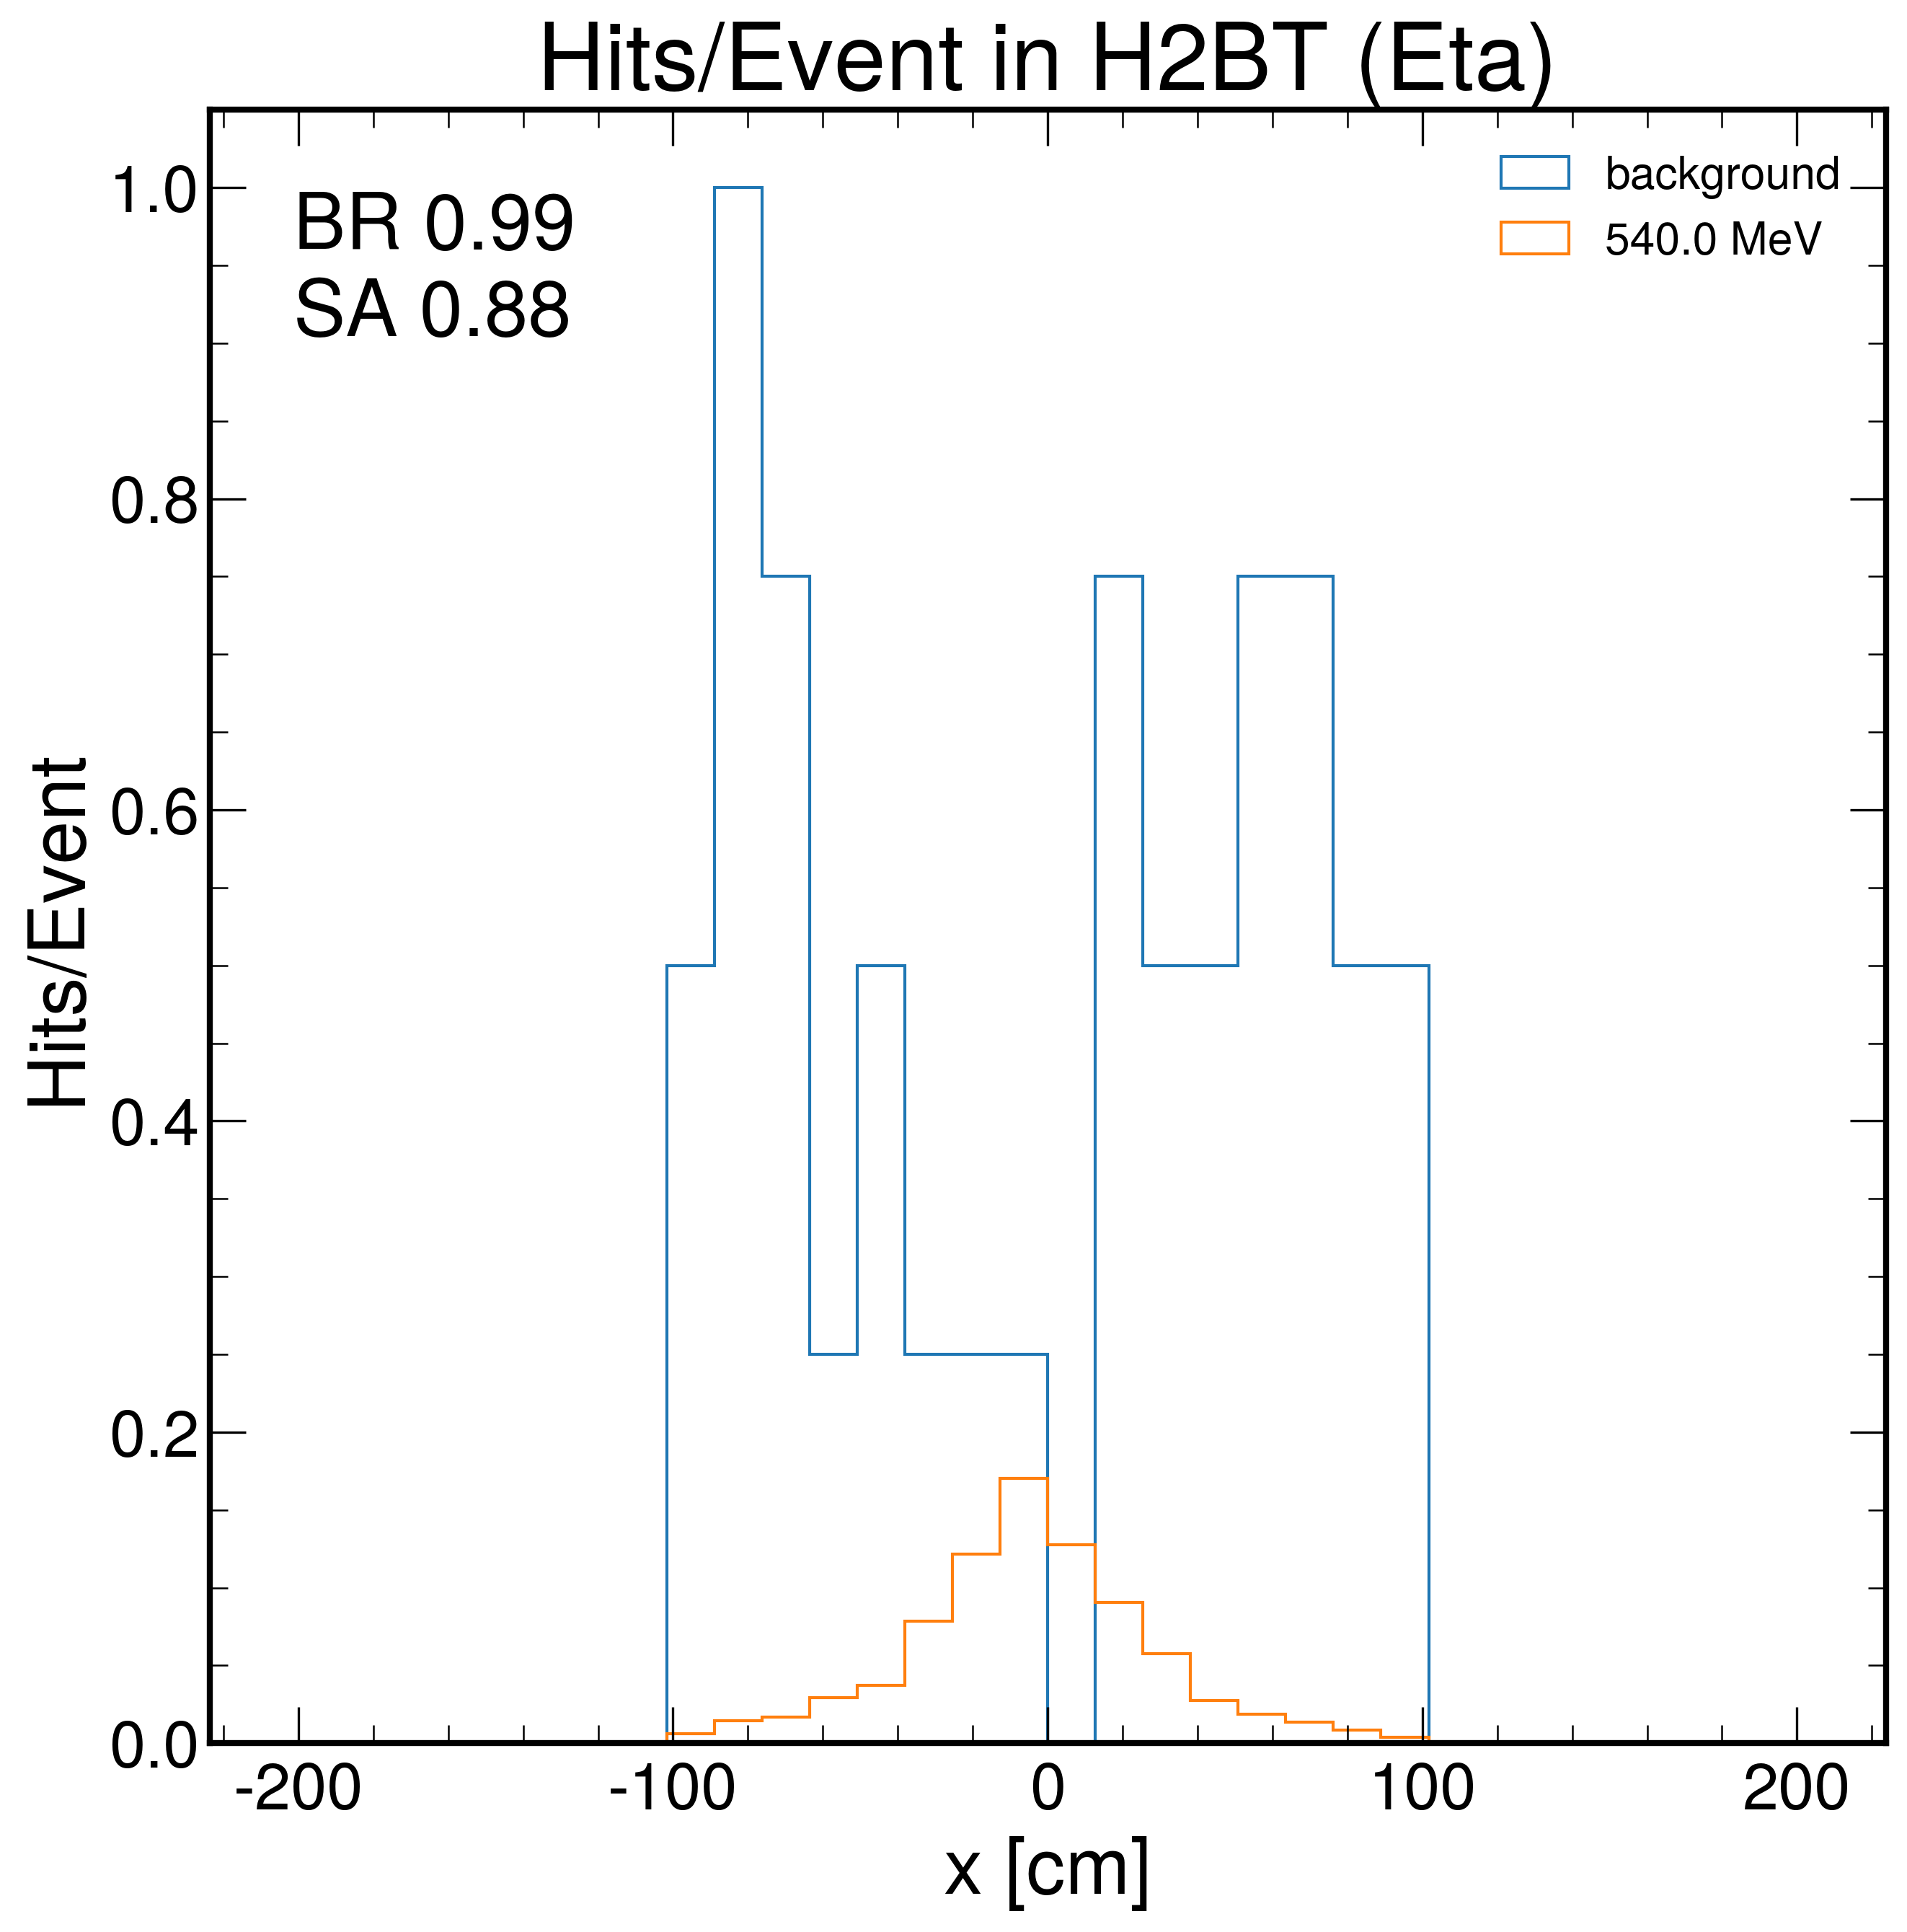

<Figure size 720x720 with 0 Axes>

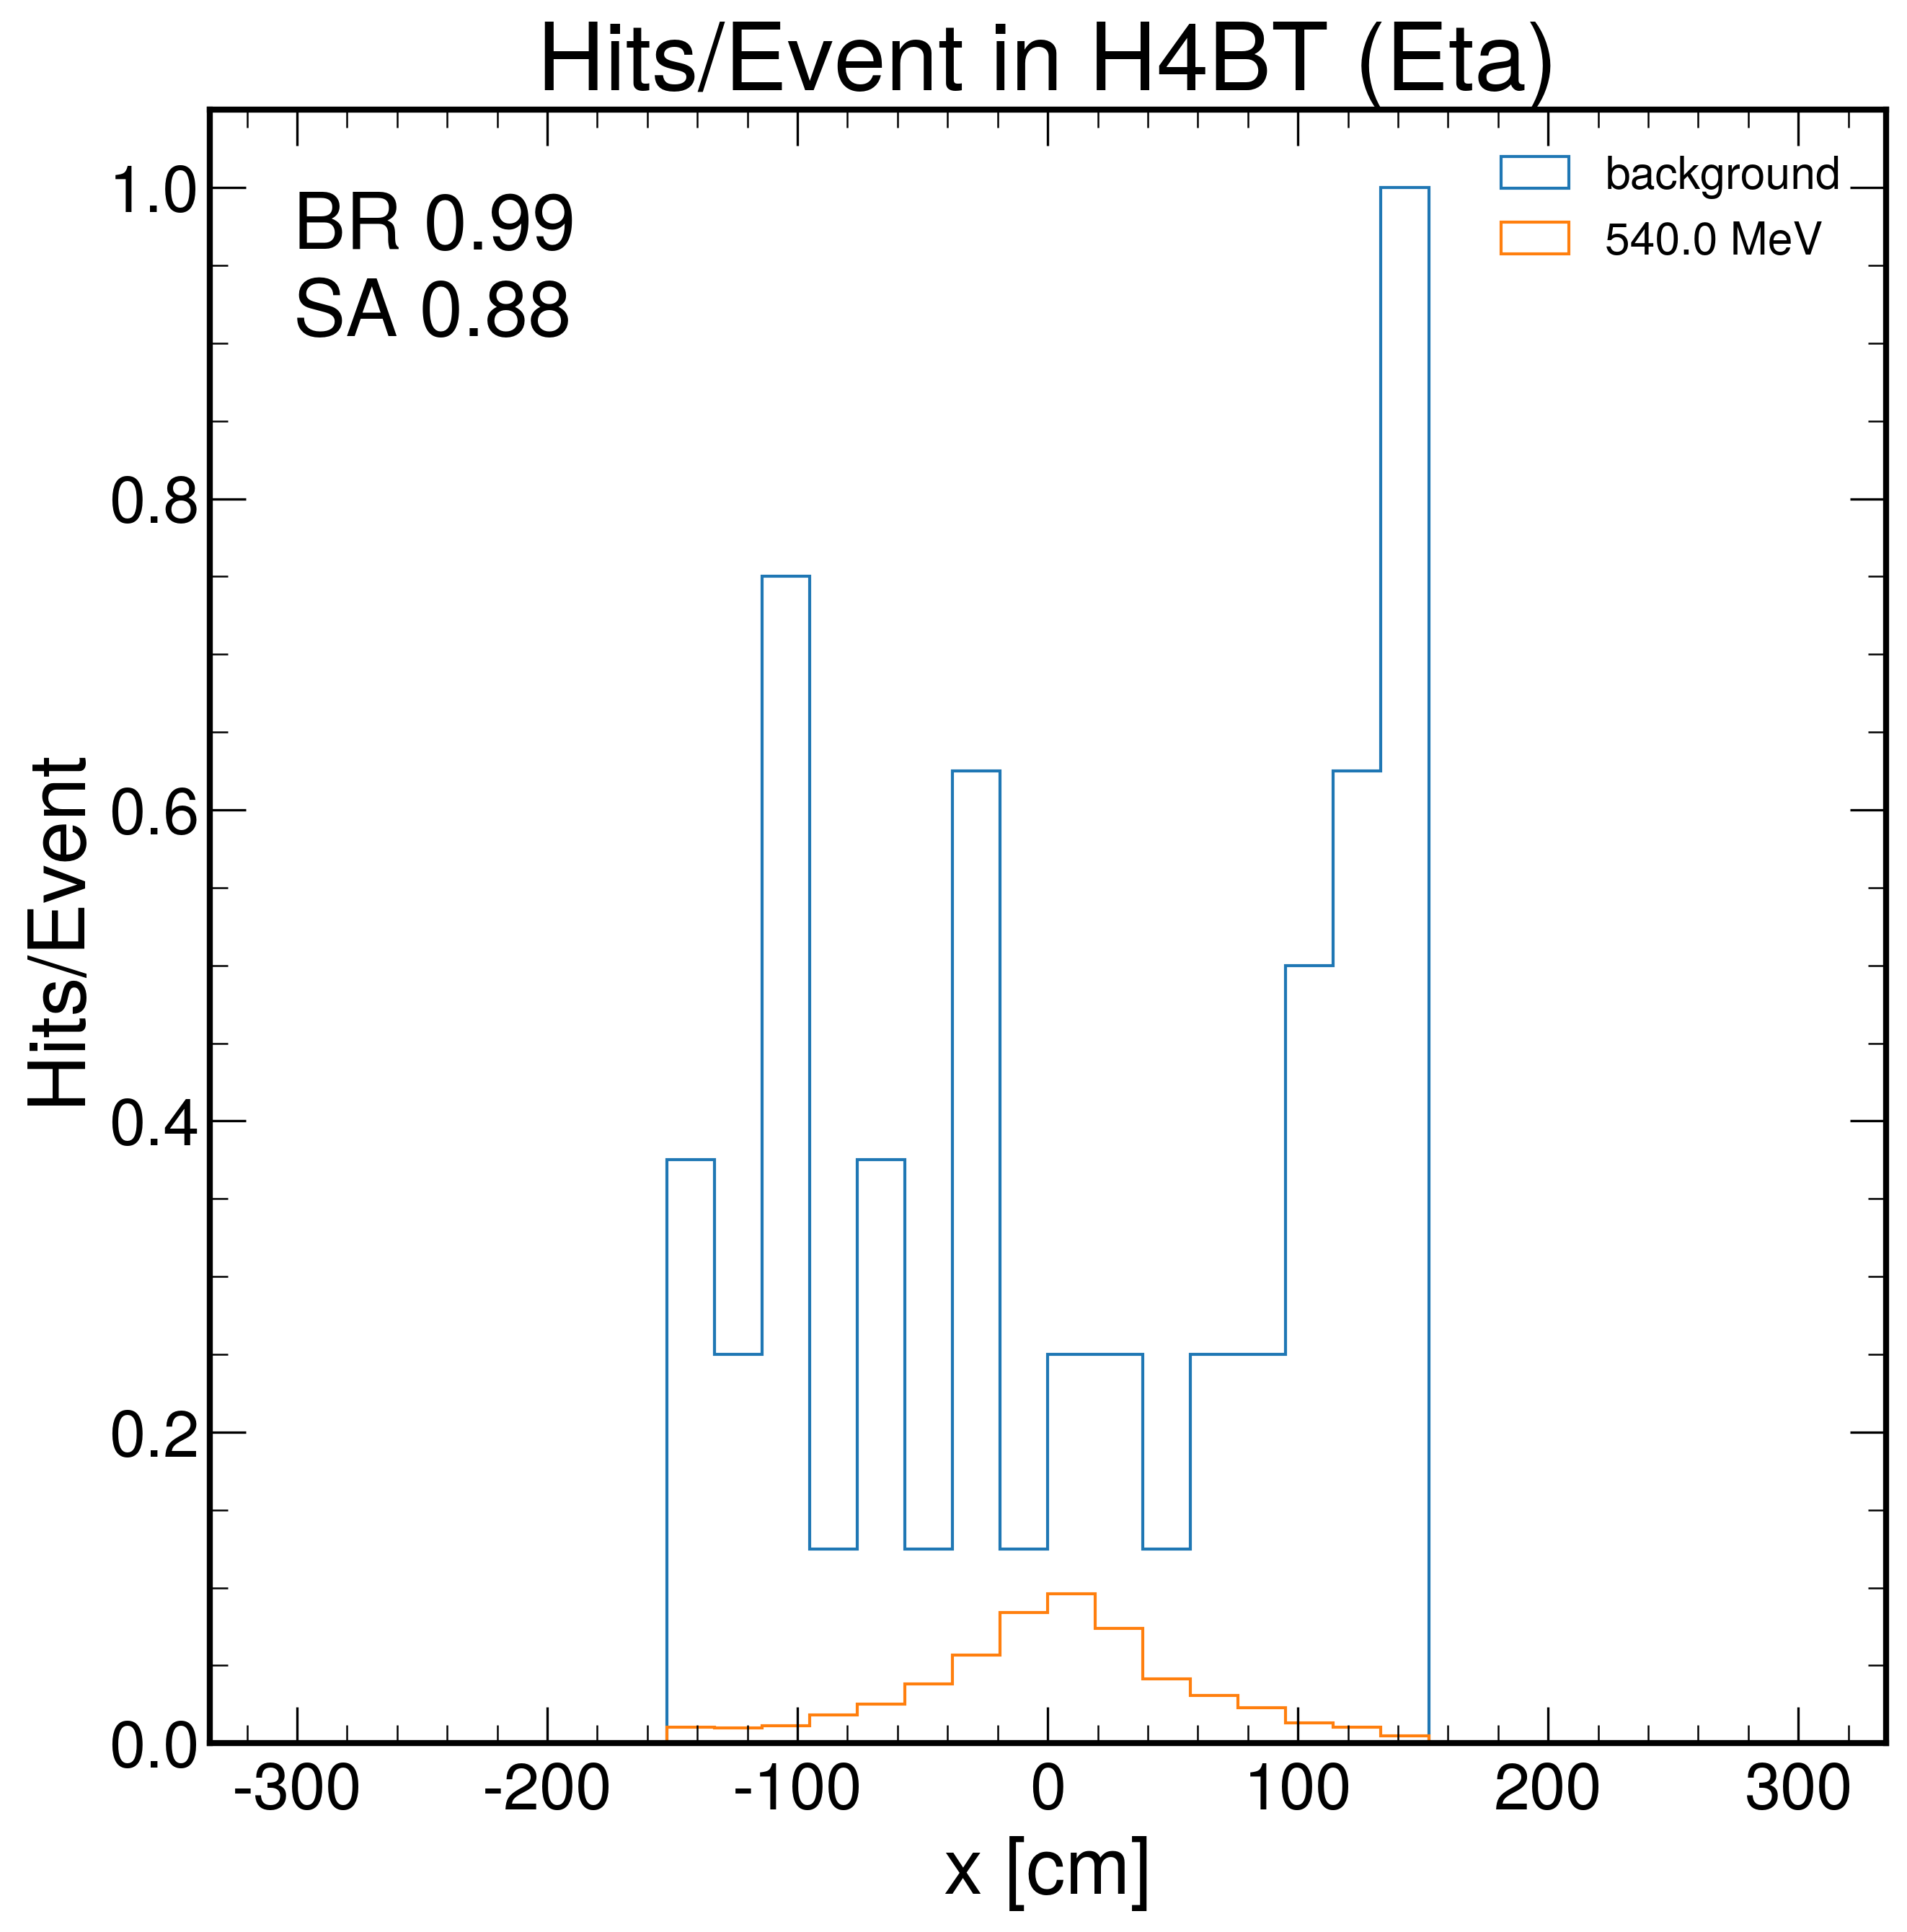

/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 720x720 with 0 Axes>

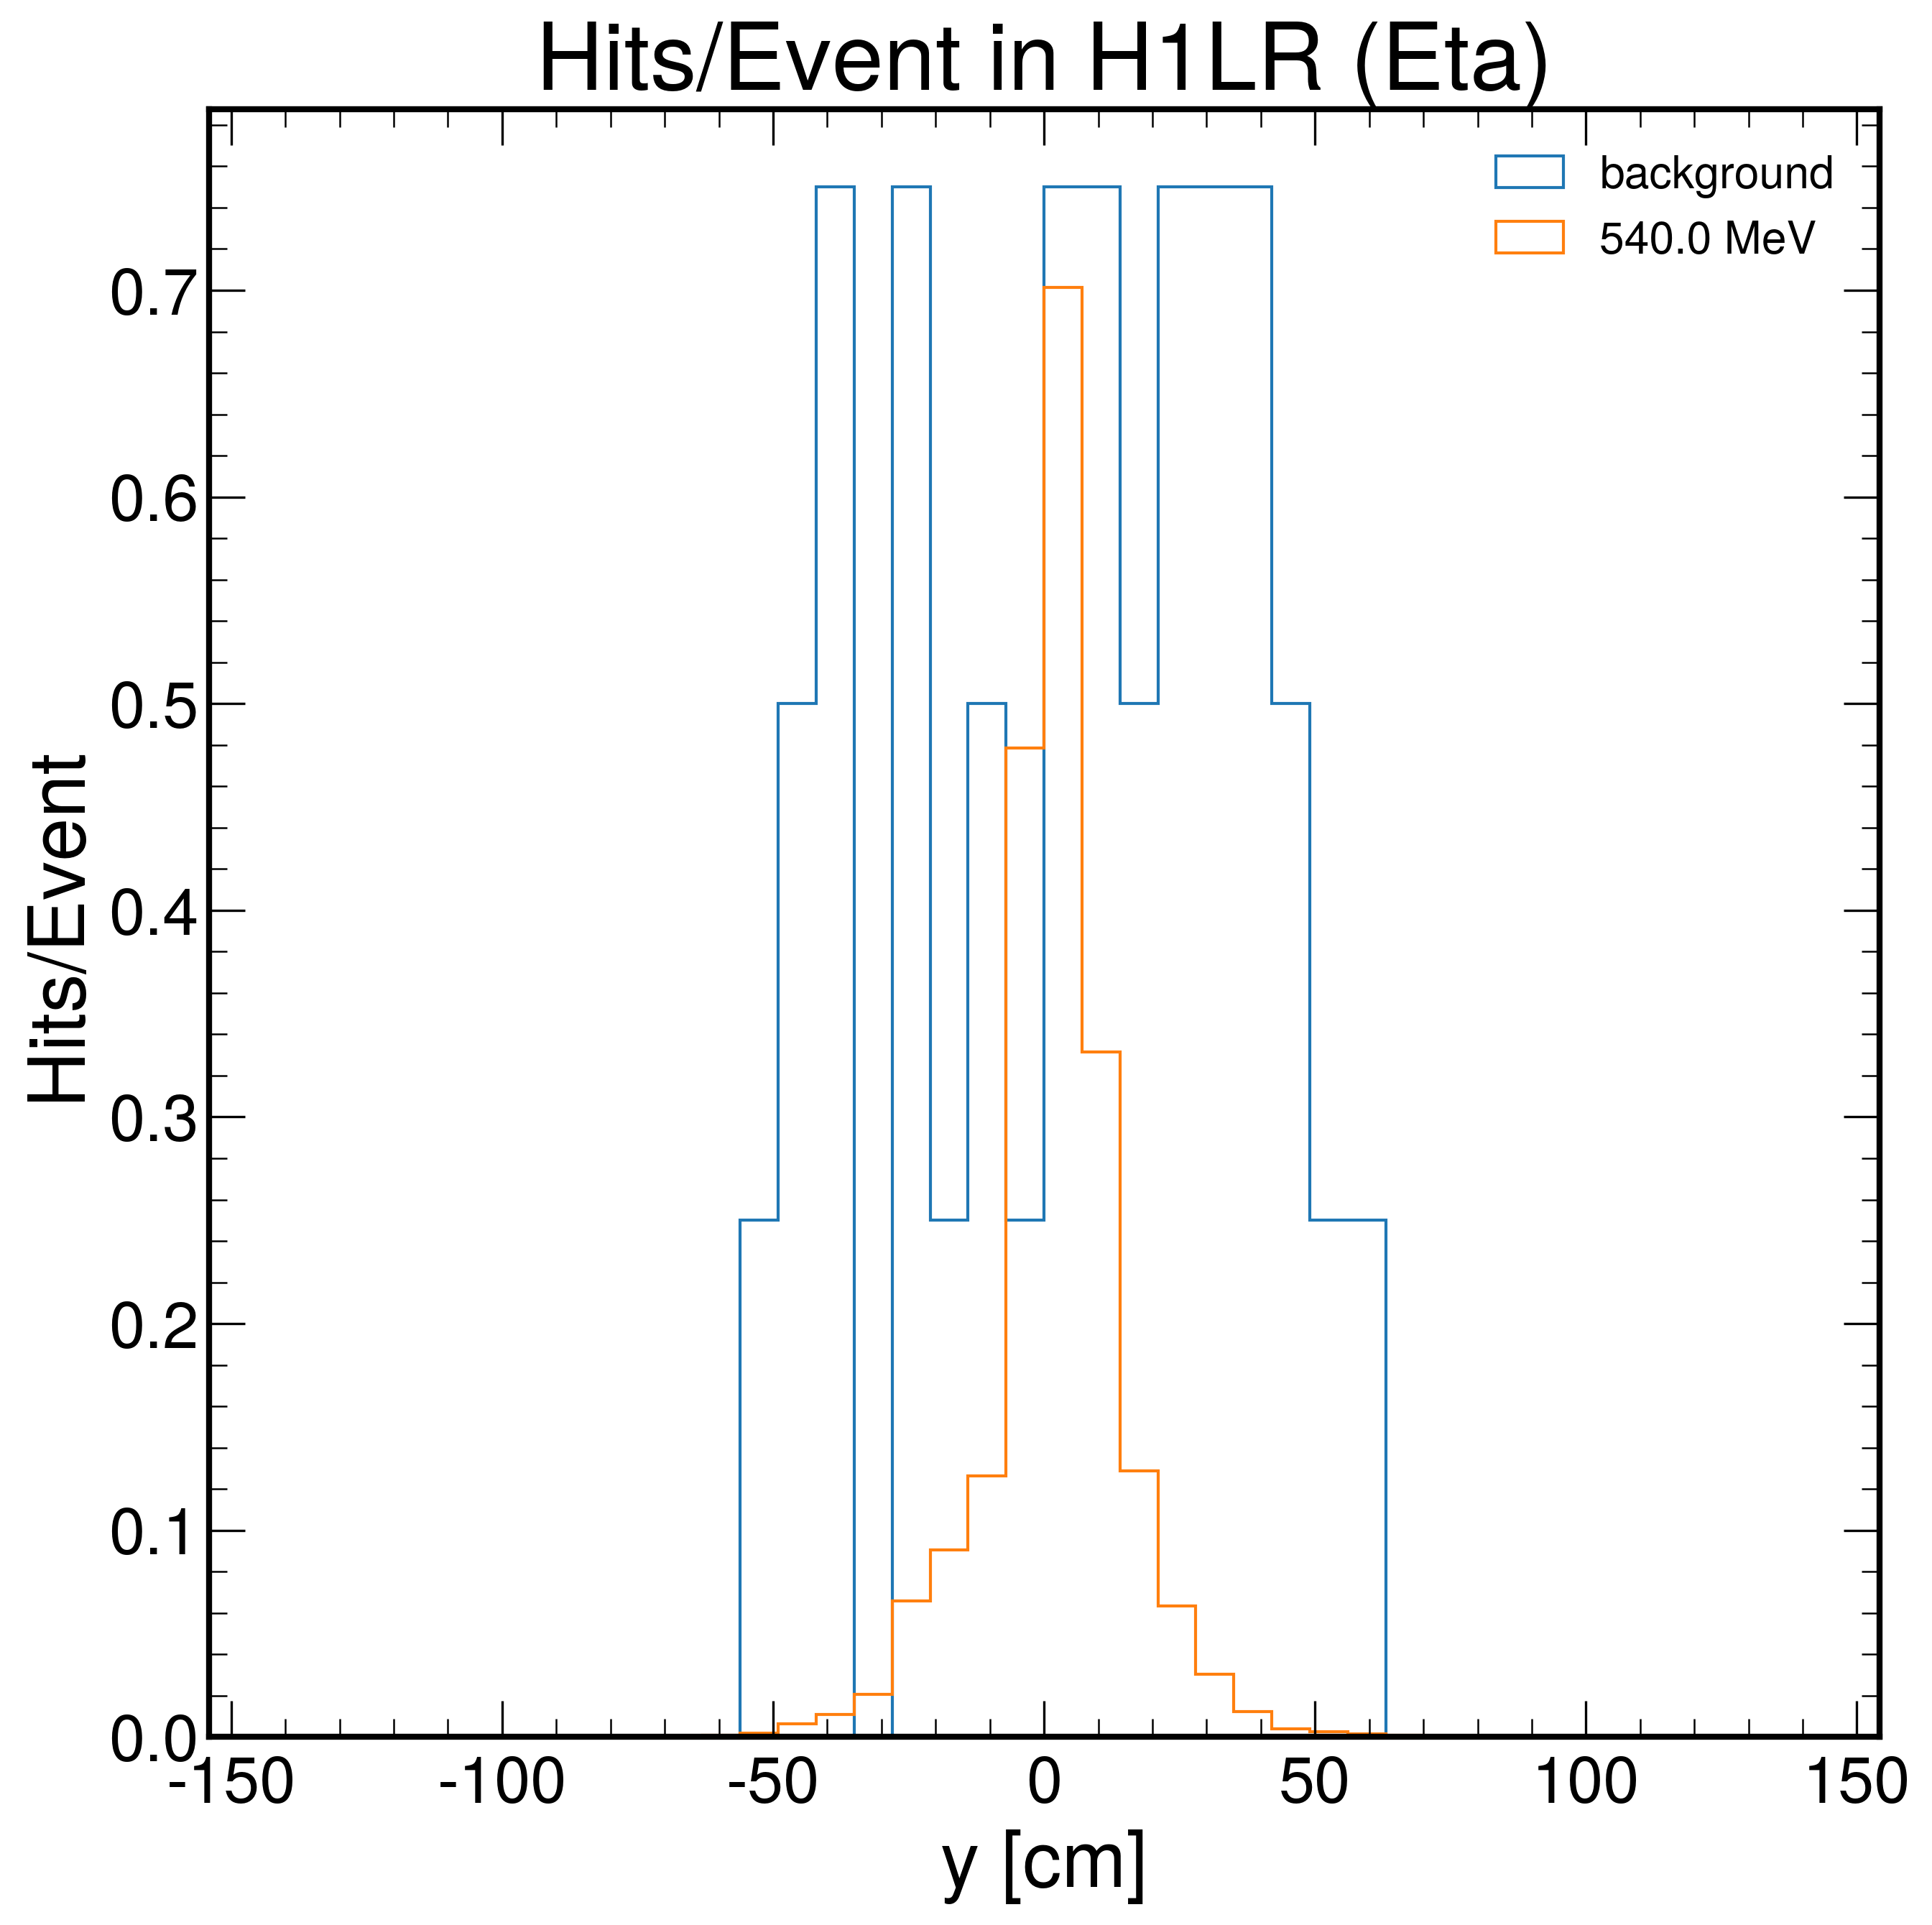

<Figure size 720x720 with 0 Axes>

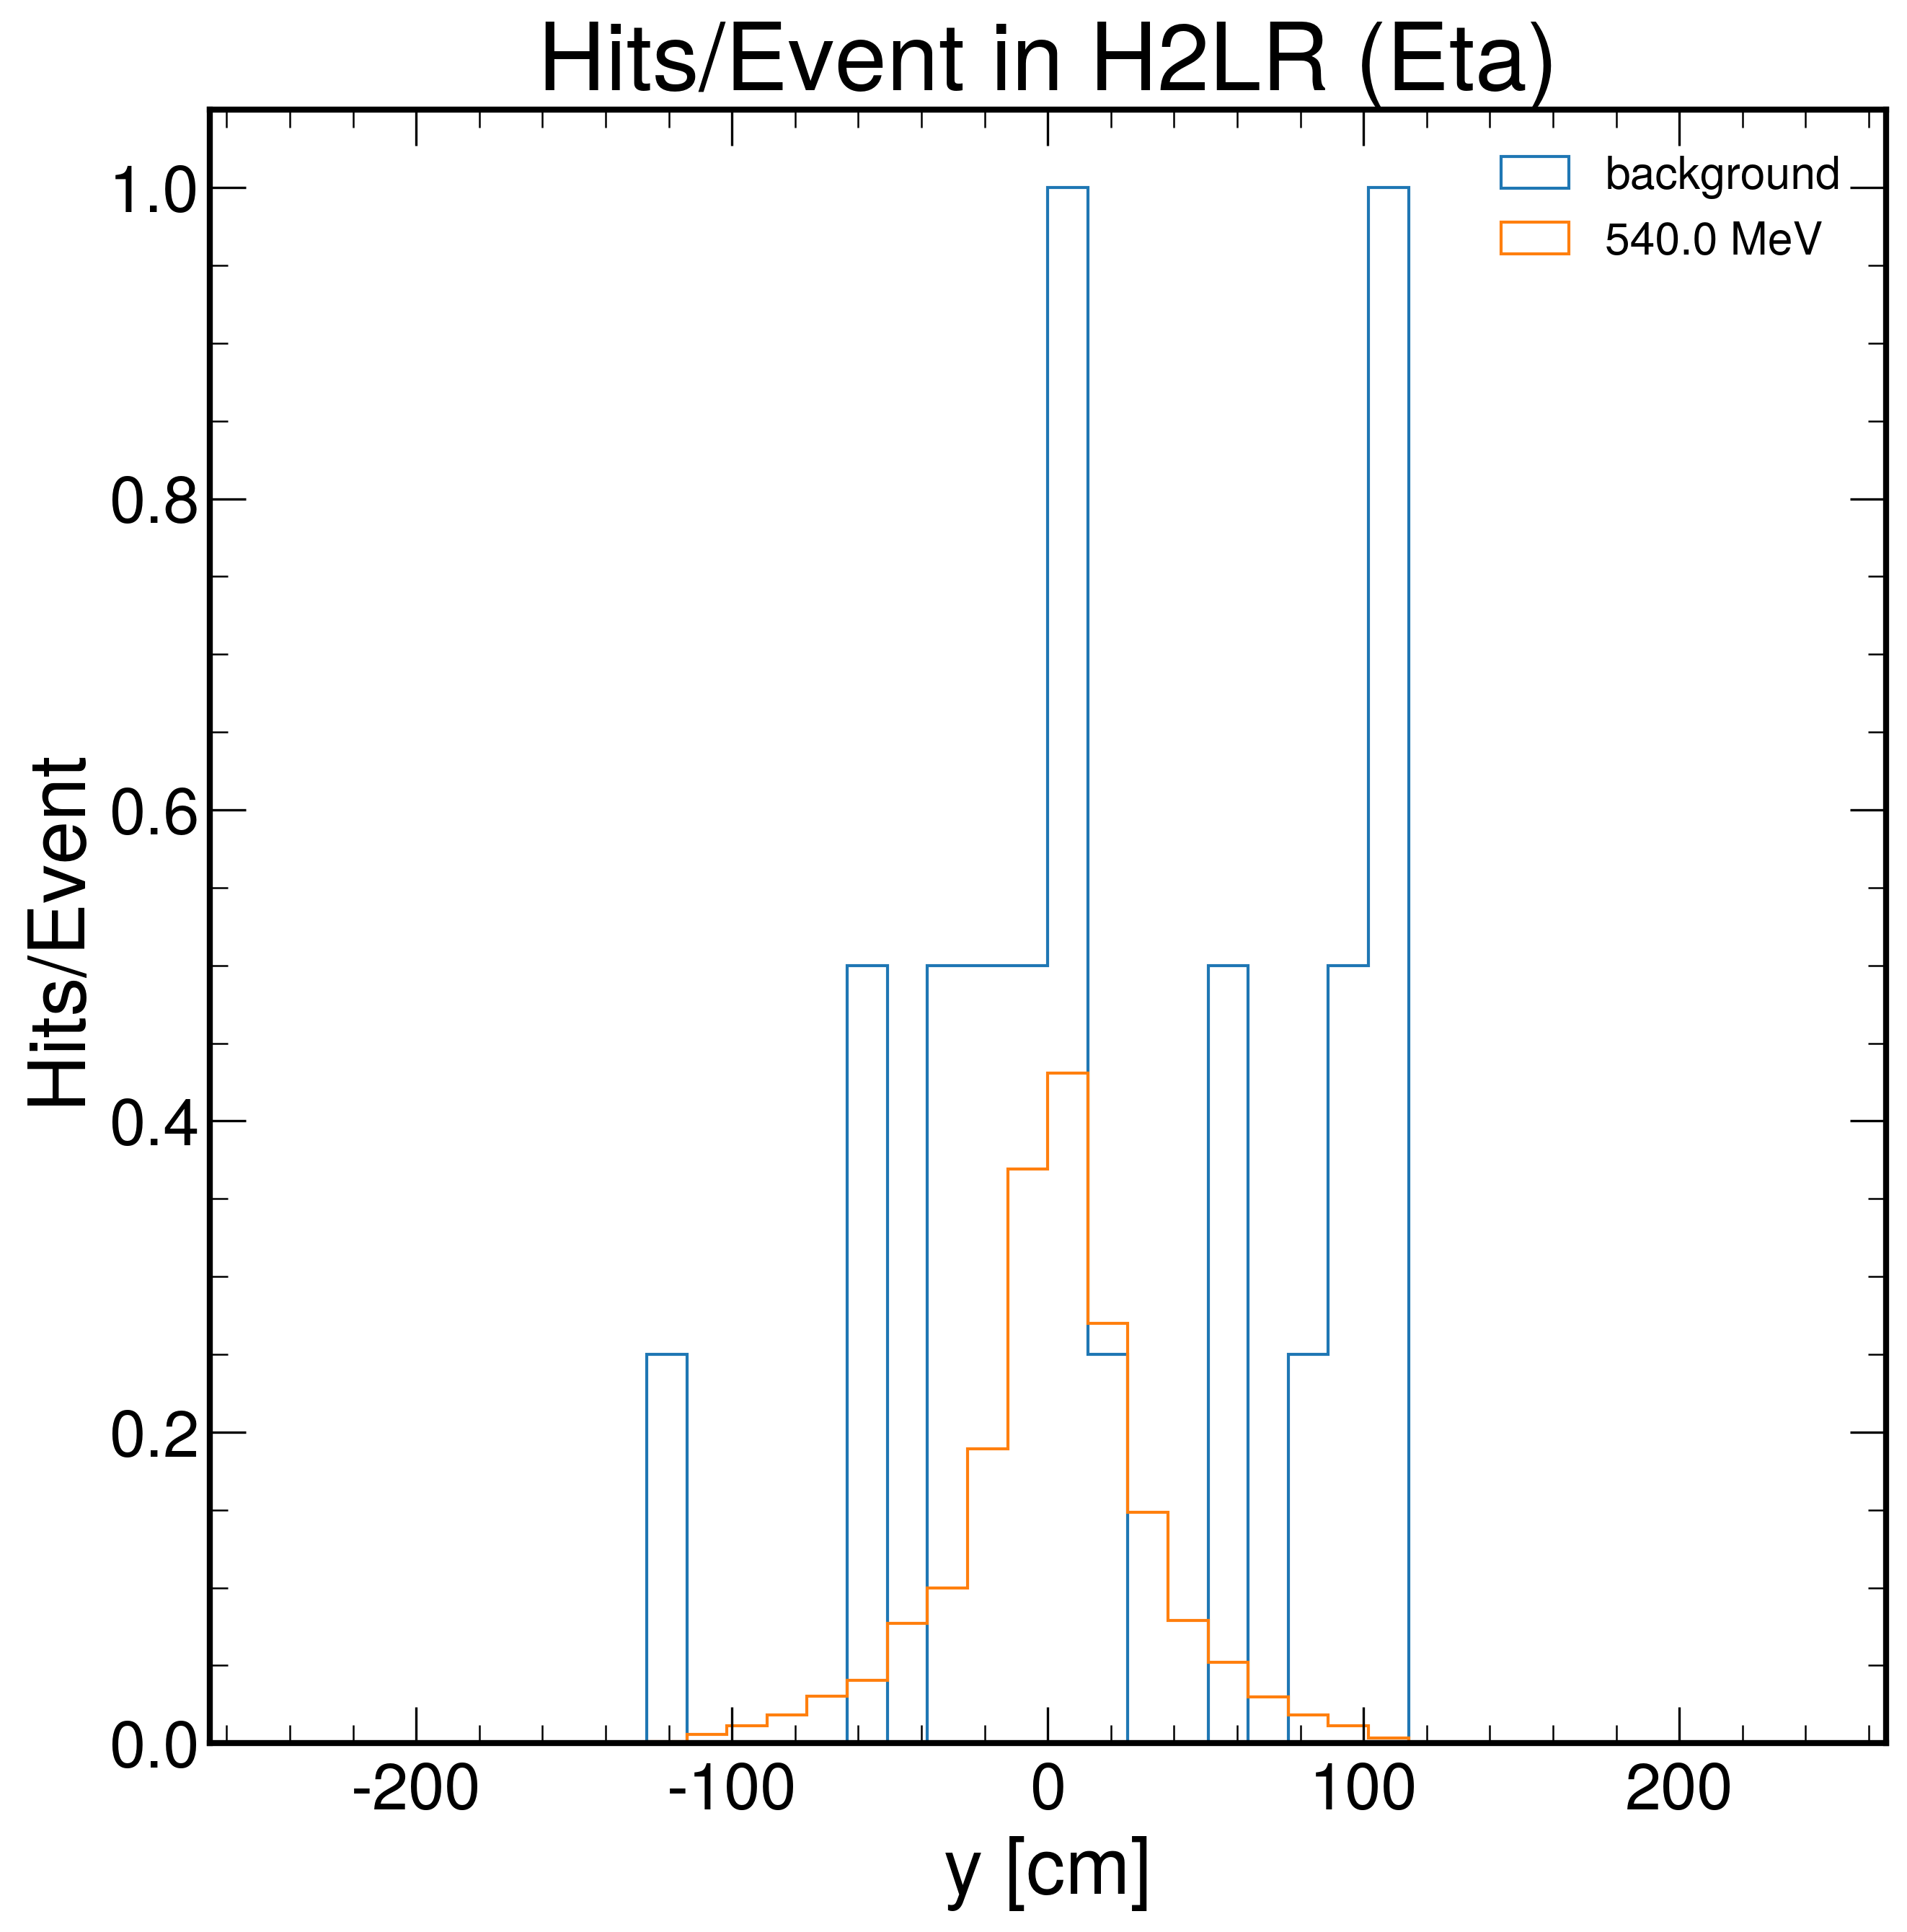

/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 720x720 with 0 Axes>

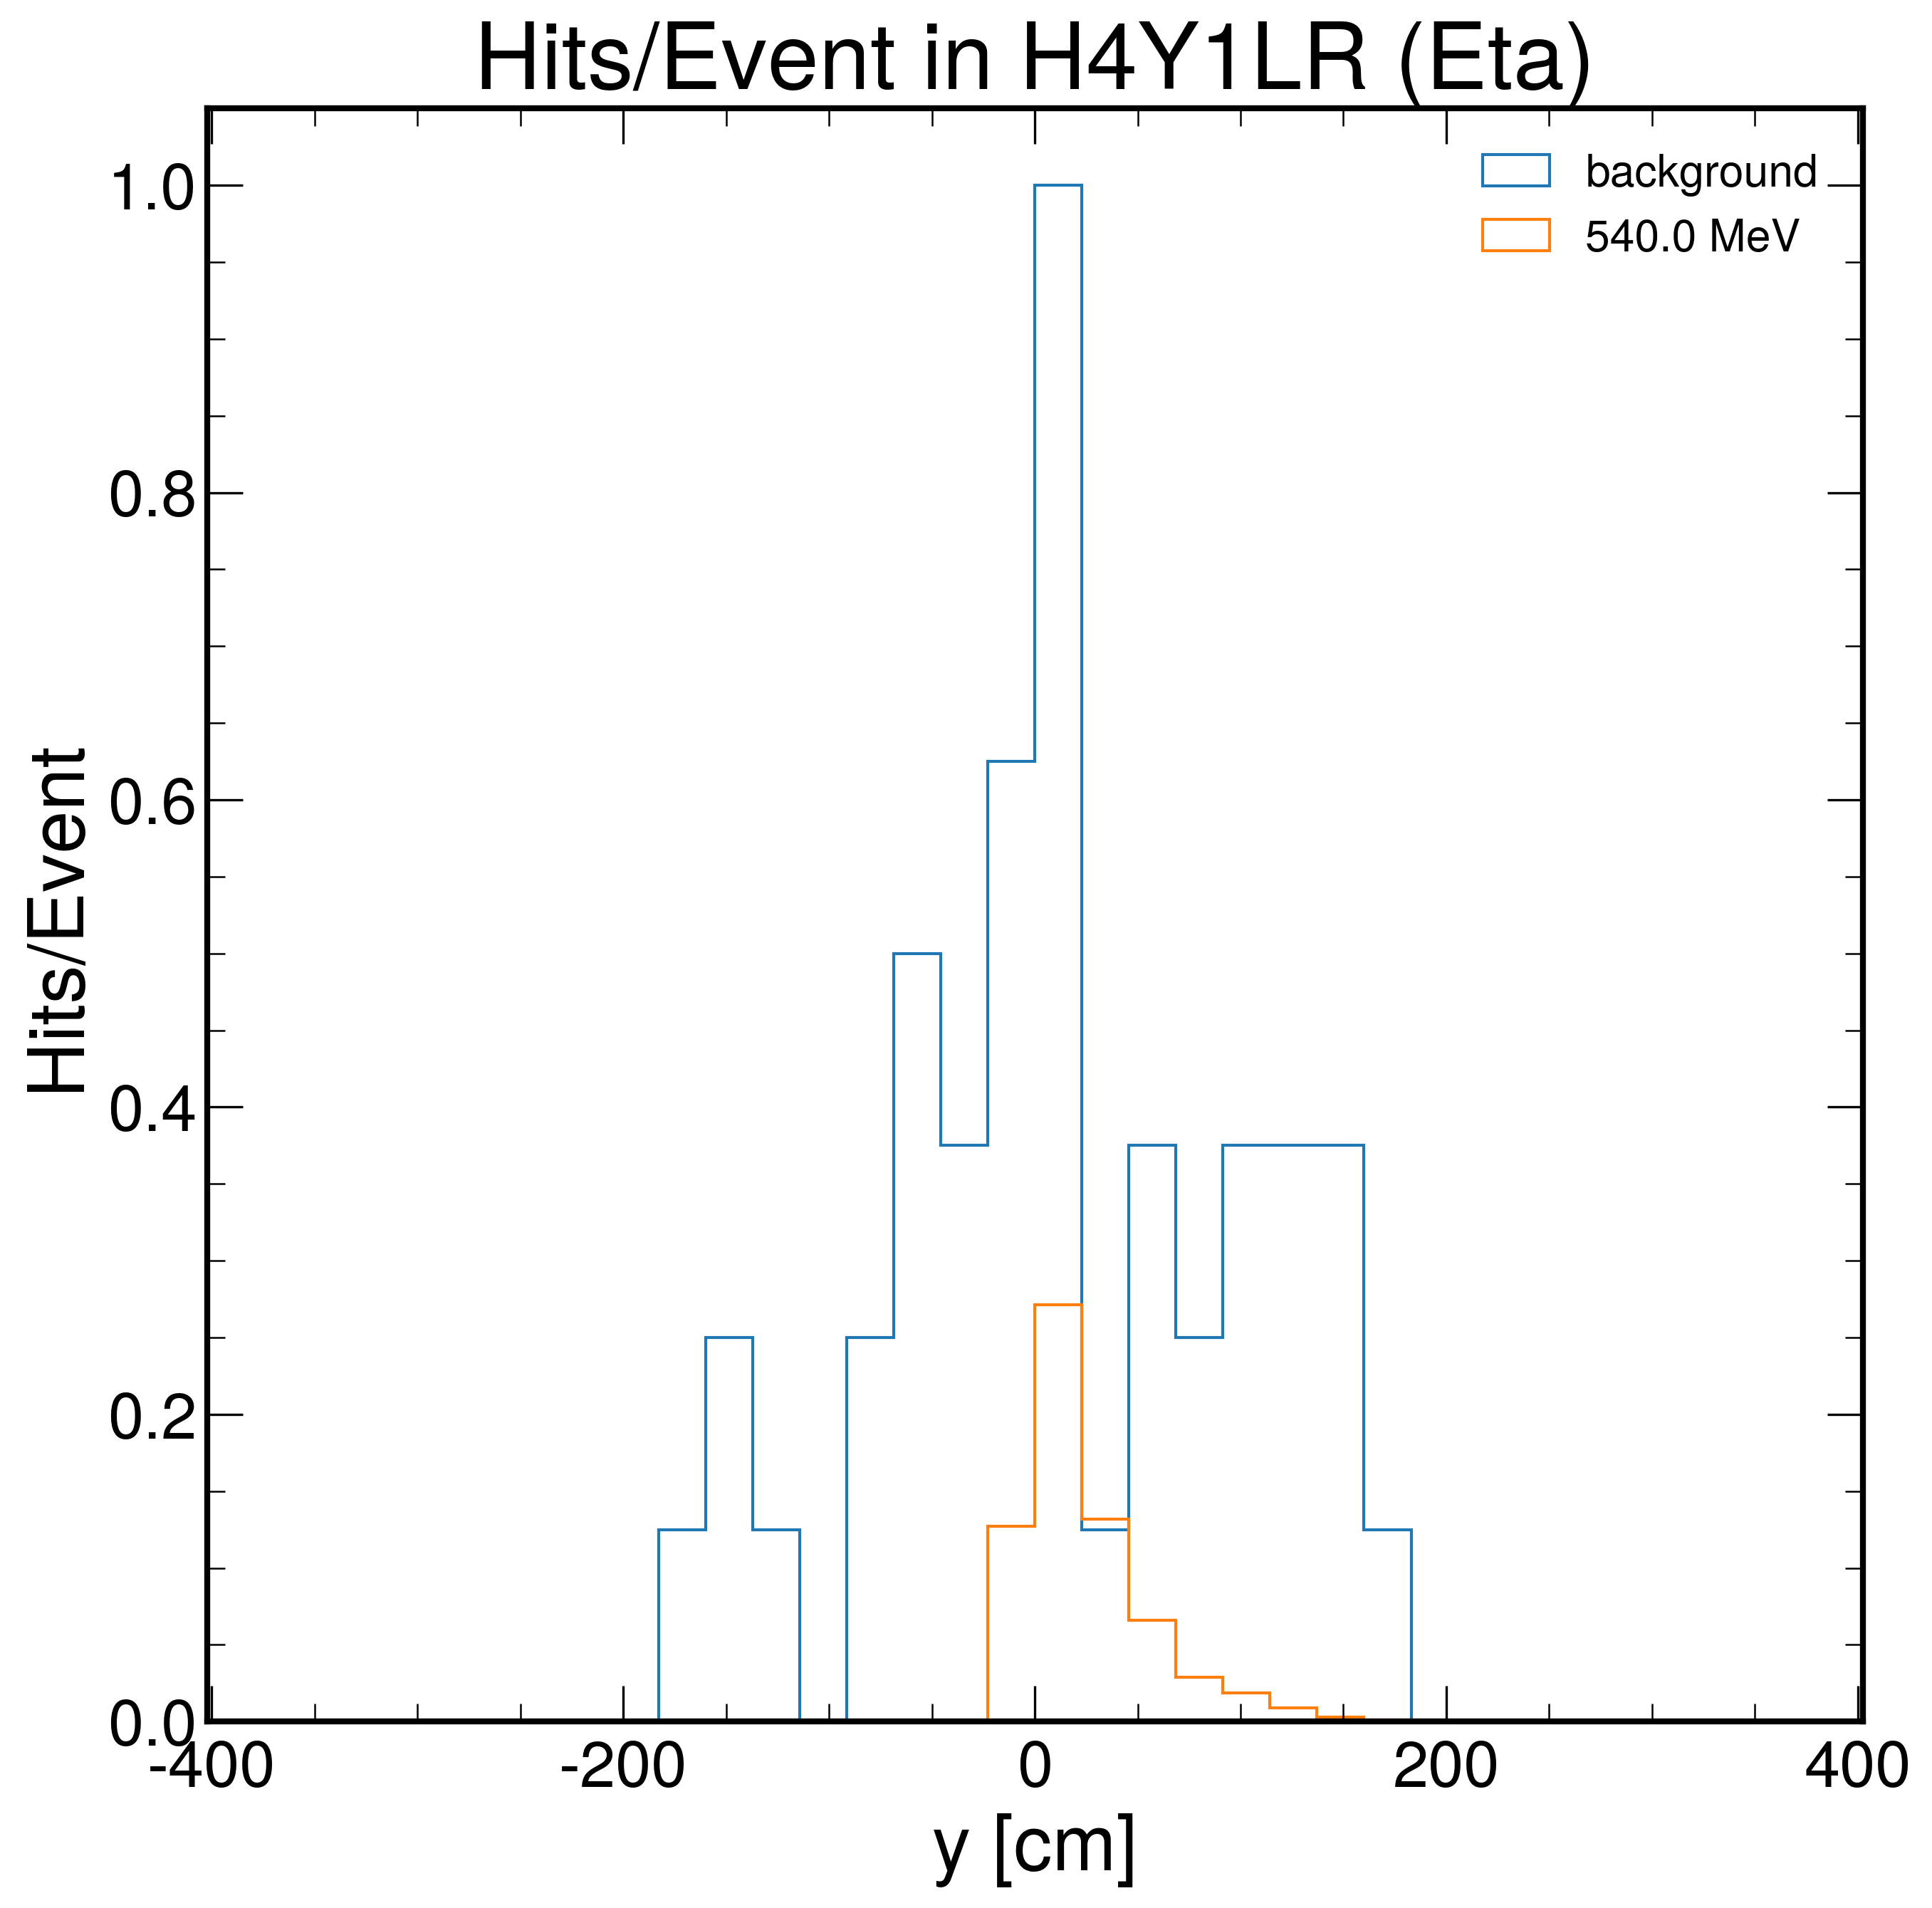

<Figure size 720x720 with 0 Axes>

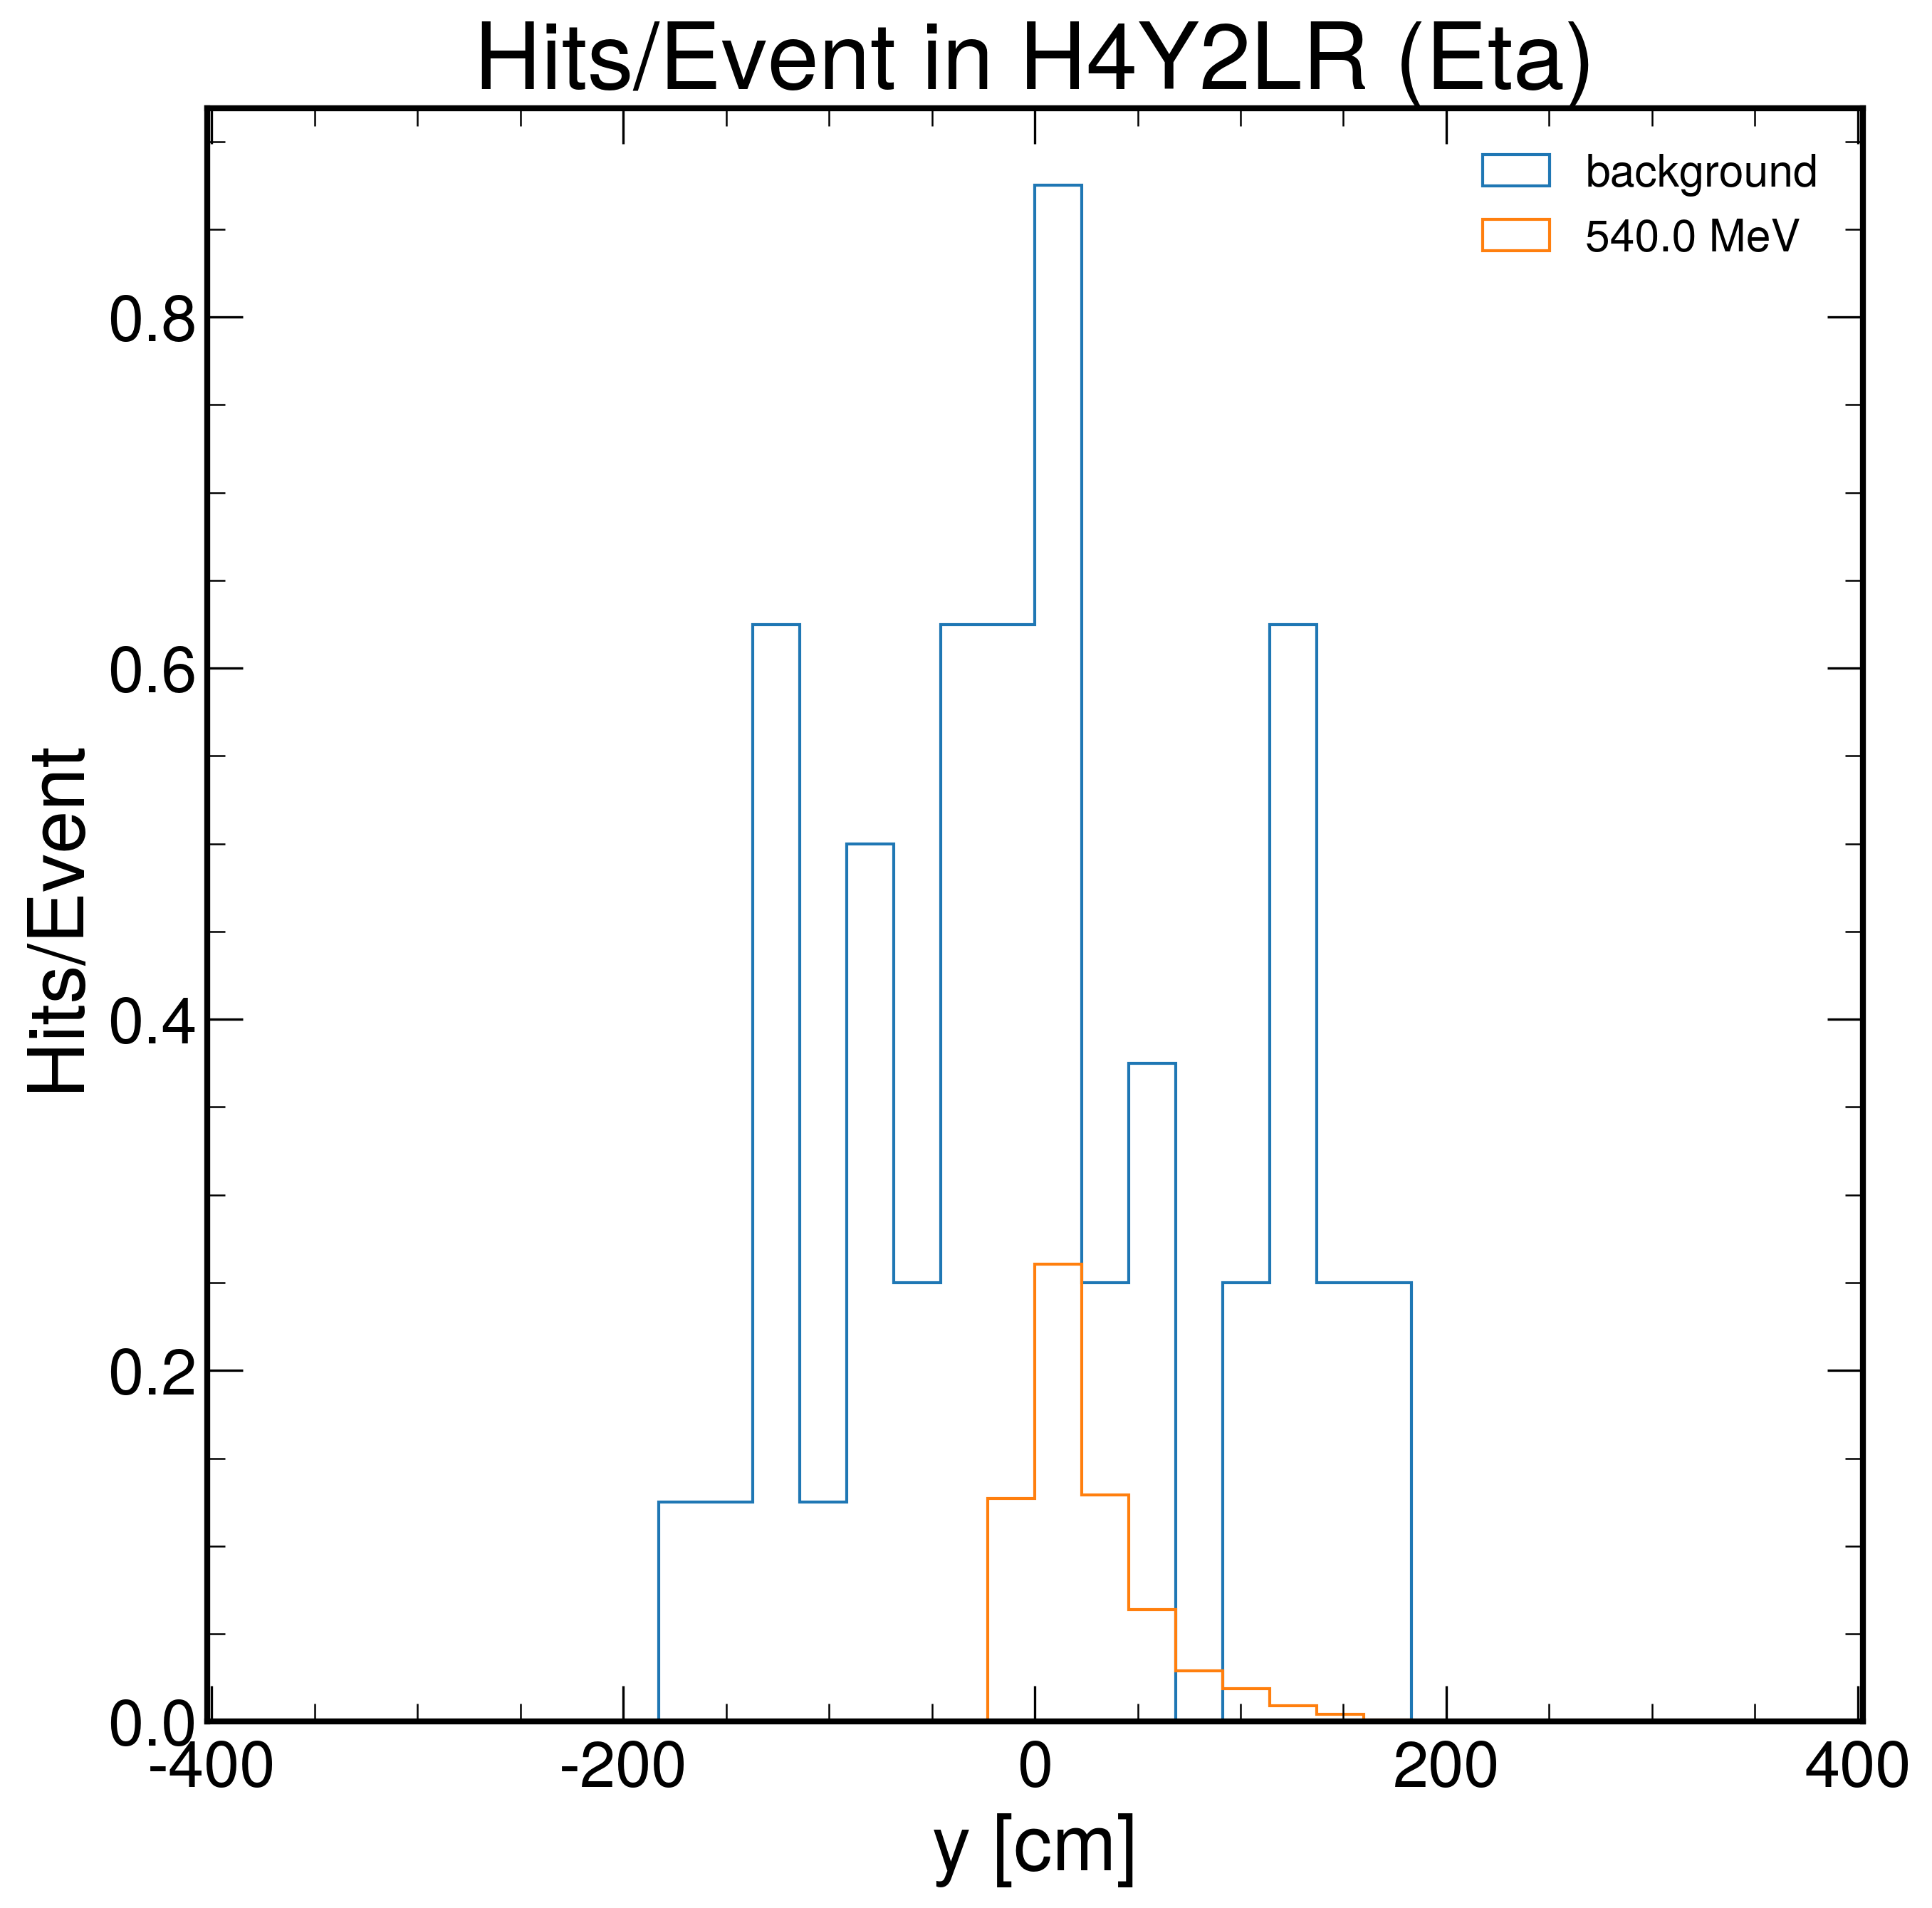

In [19]:
c = layer4BG(root,layer=[1],cut1=(-30,20))
d = layer4Sim(Truth054,layer=[1],cut1=(-30,20))
plot_overlay(c,d,Eta054,weighted=True)

This cut results in 99% of background rejected, 88% signal accepted. The next cut could be in station2, from `[-80,80]`

<Figure size 720x720 with 0 Axes>

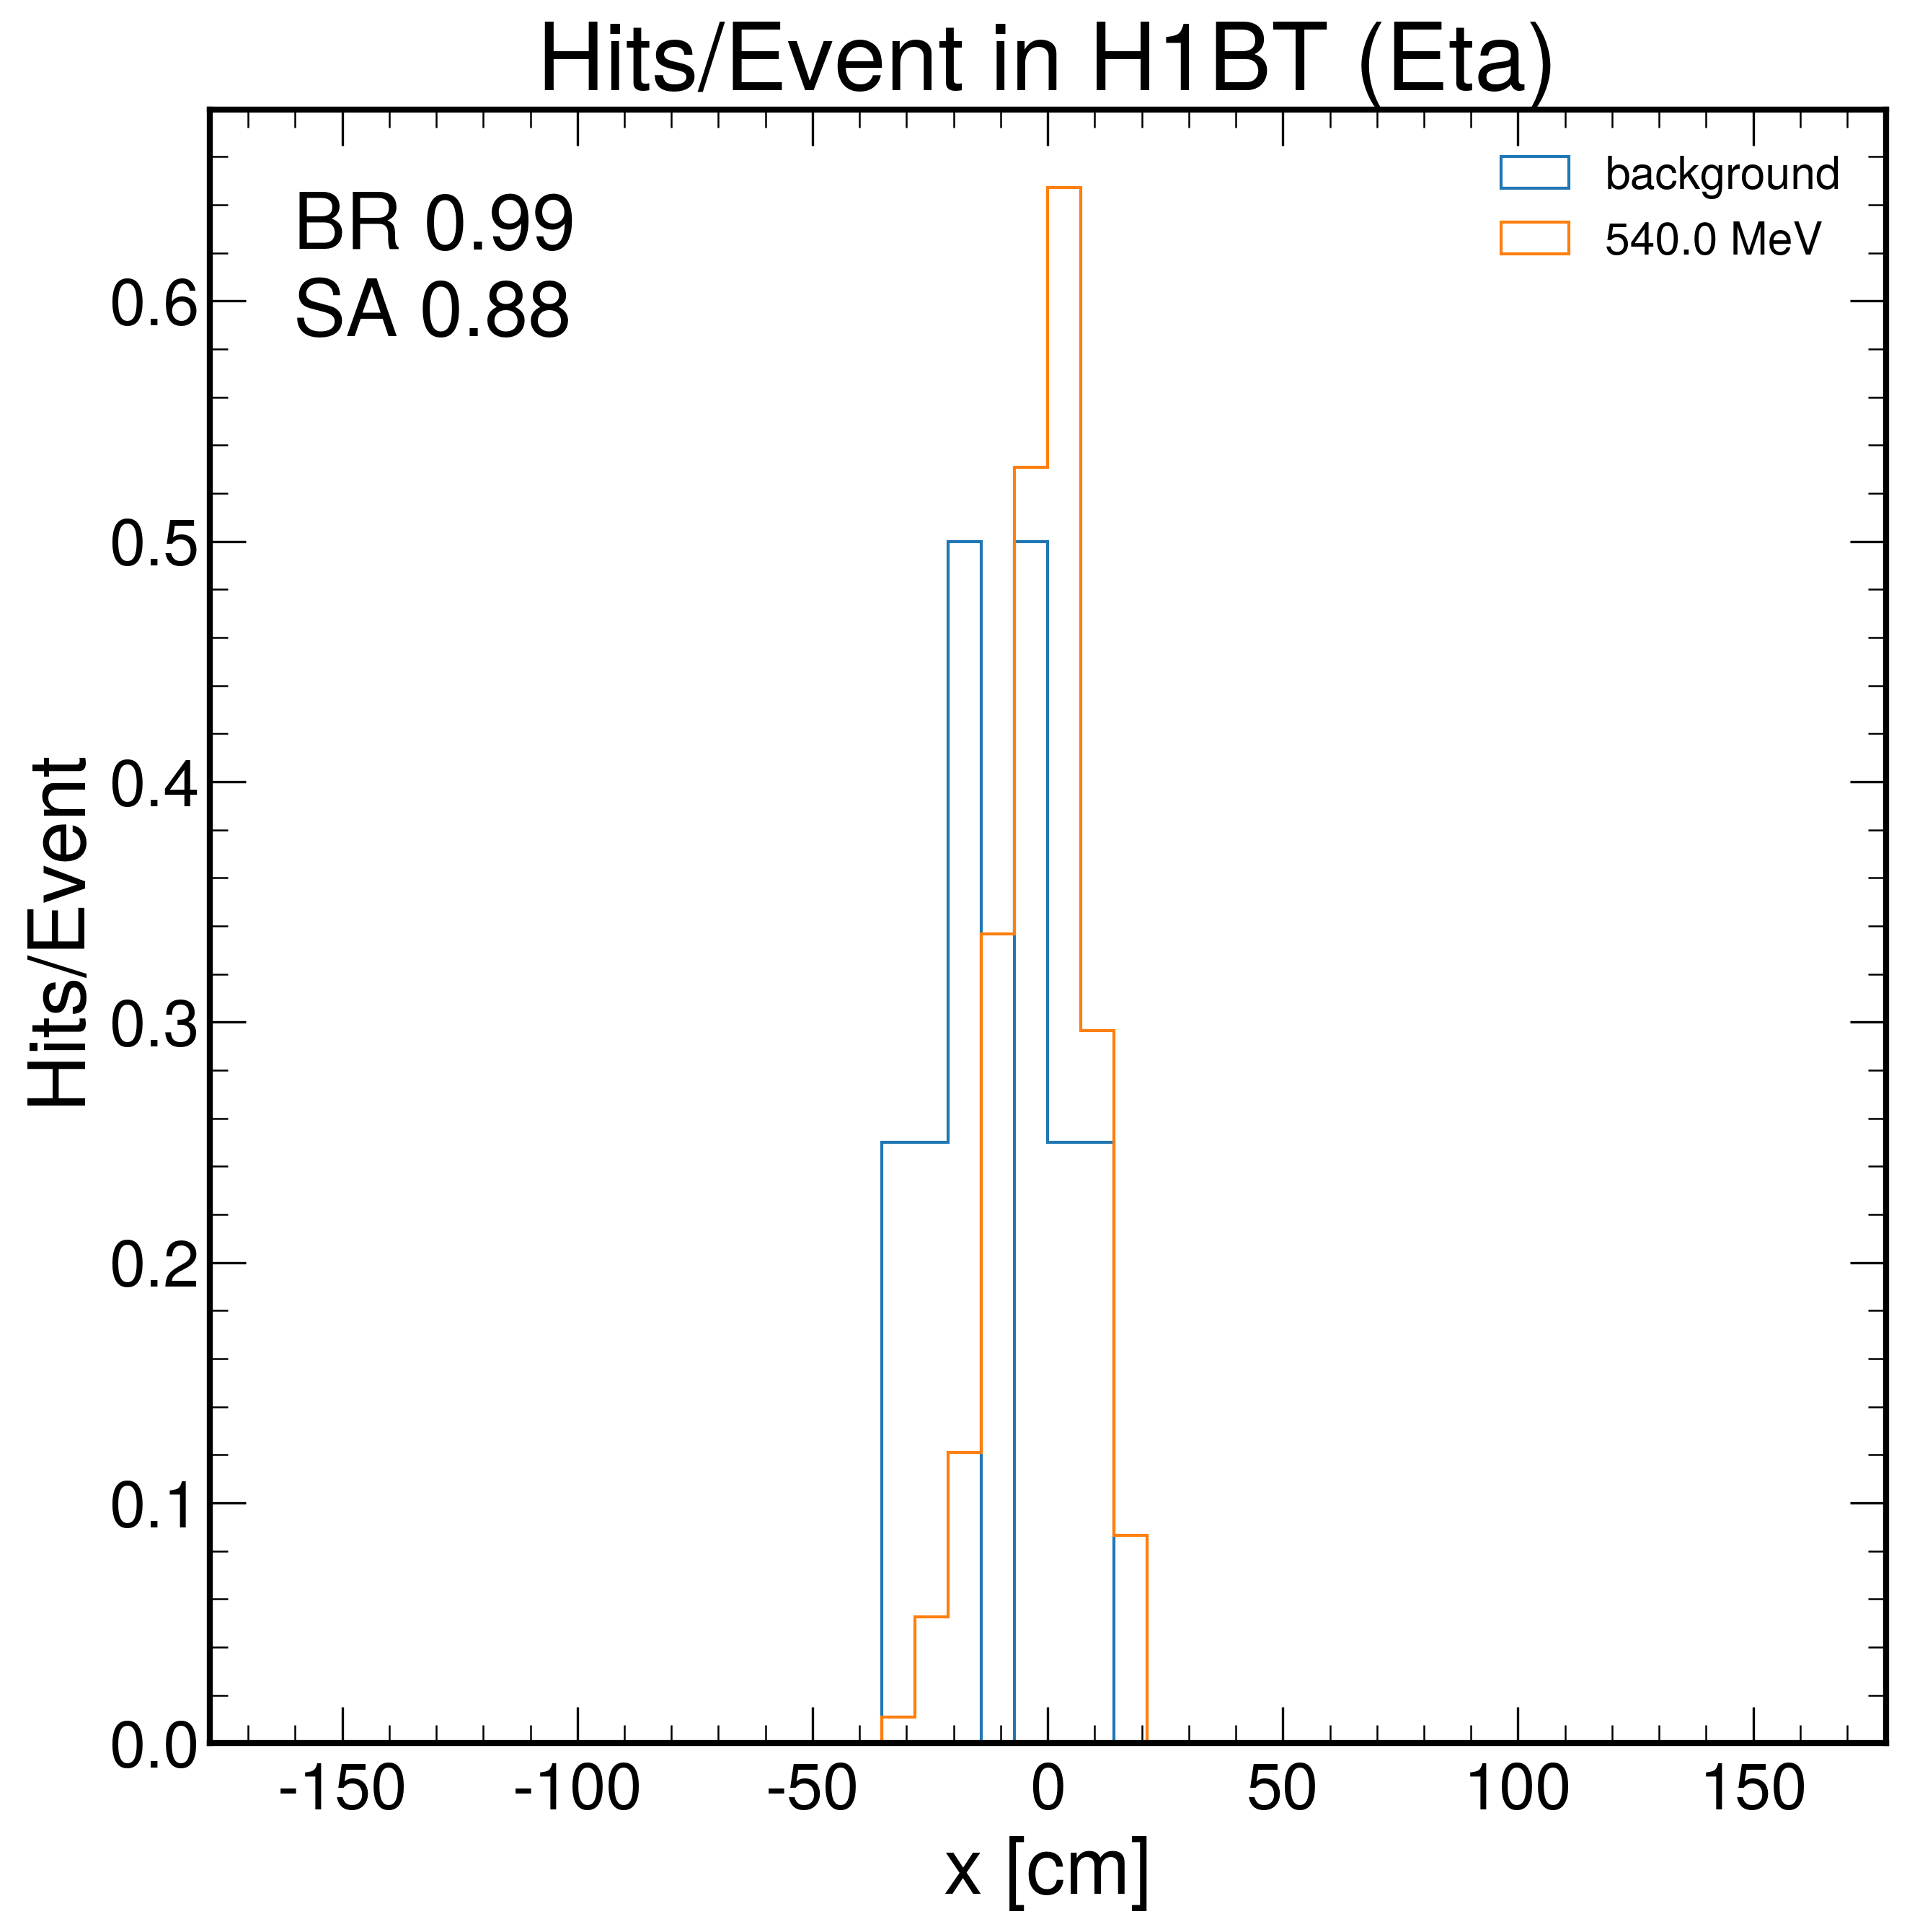

<Figure size 720x720 with 0 Axes>

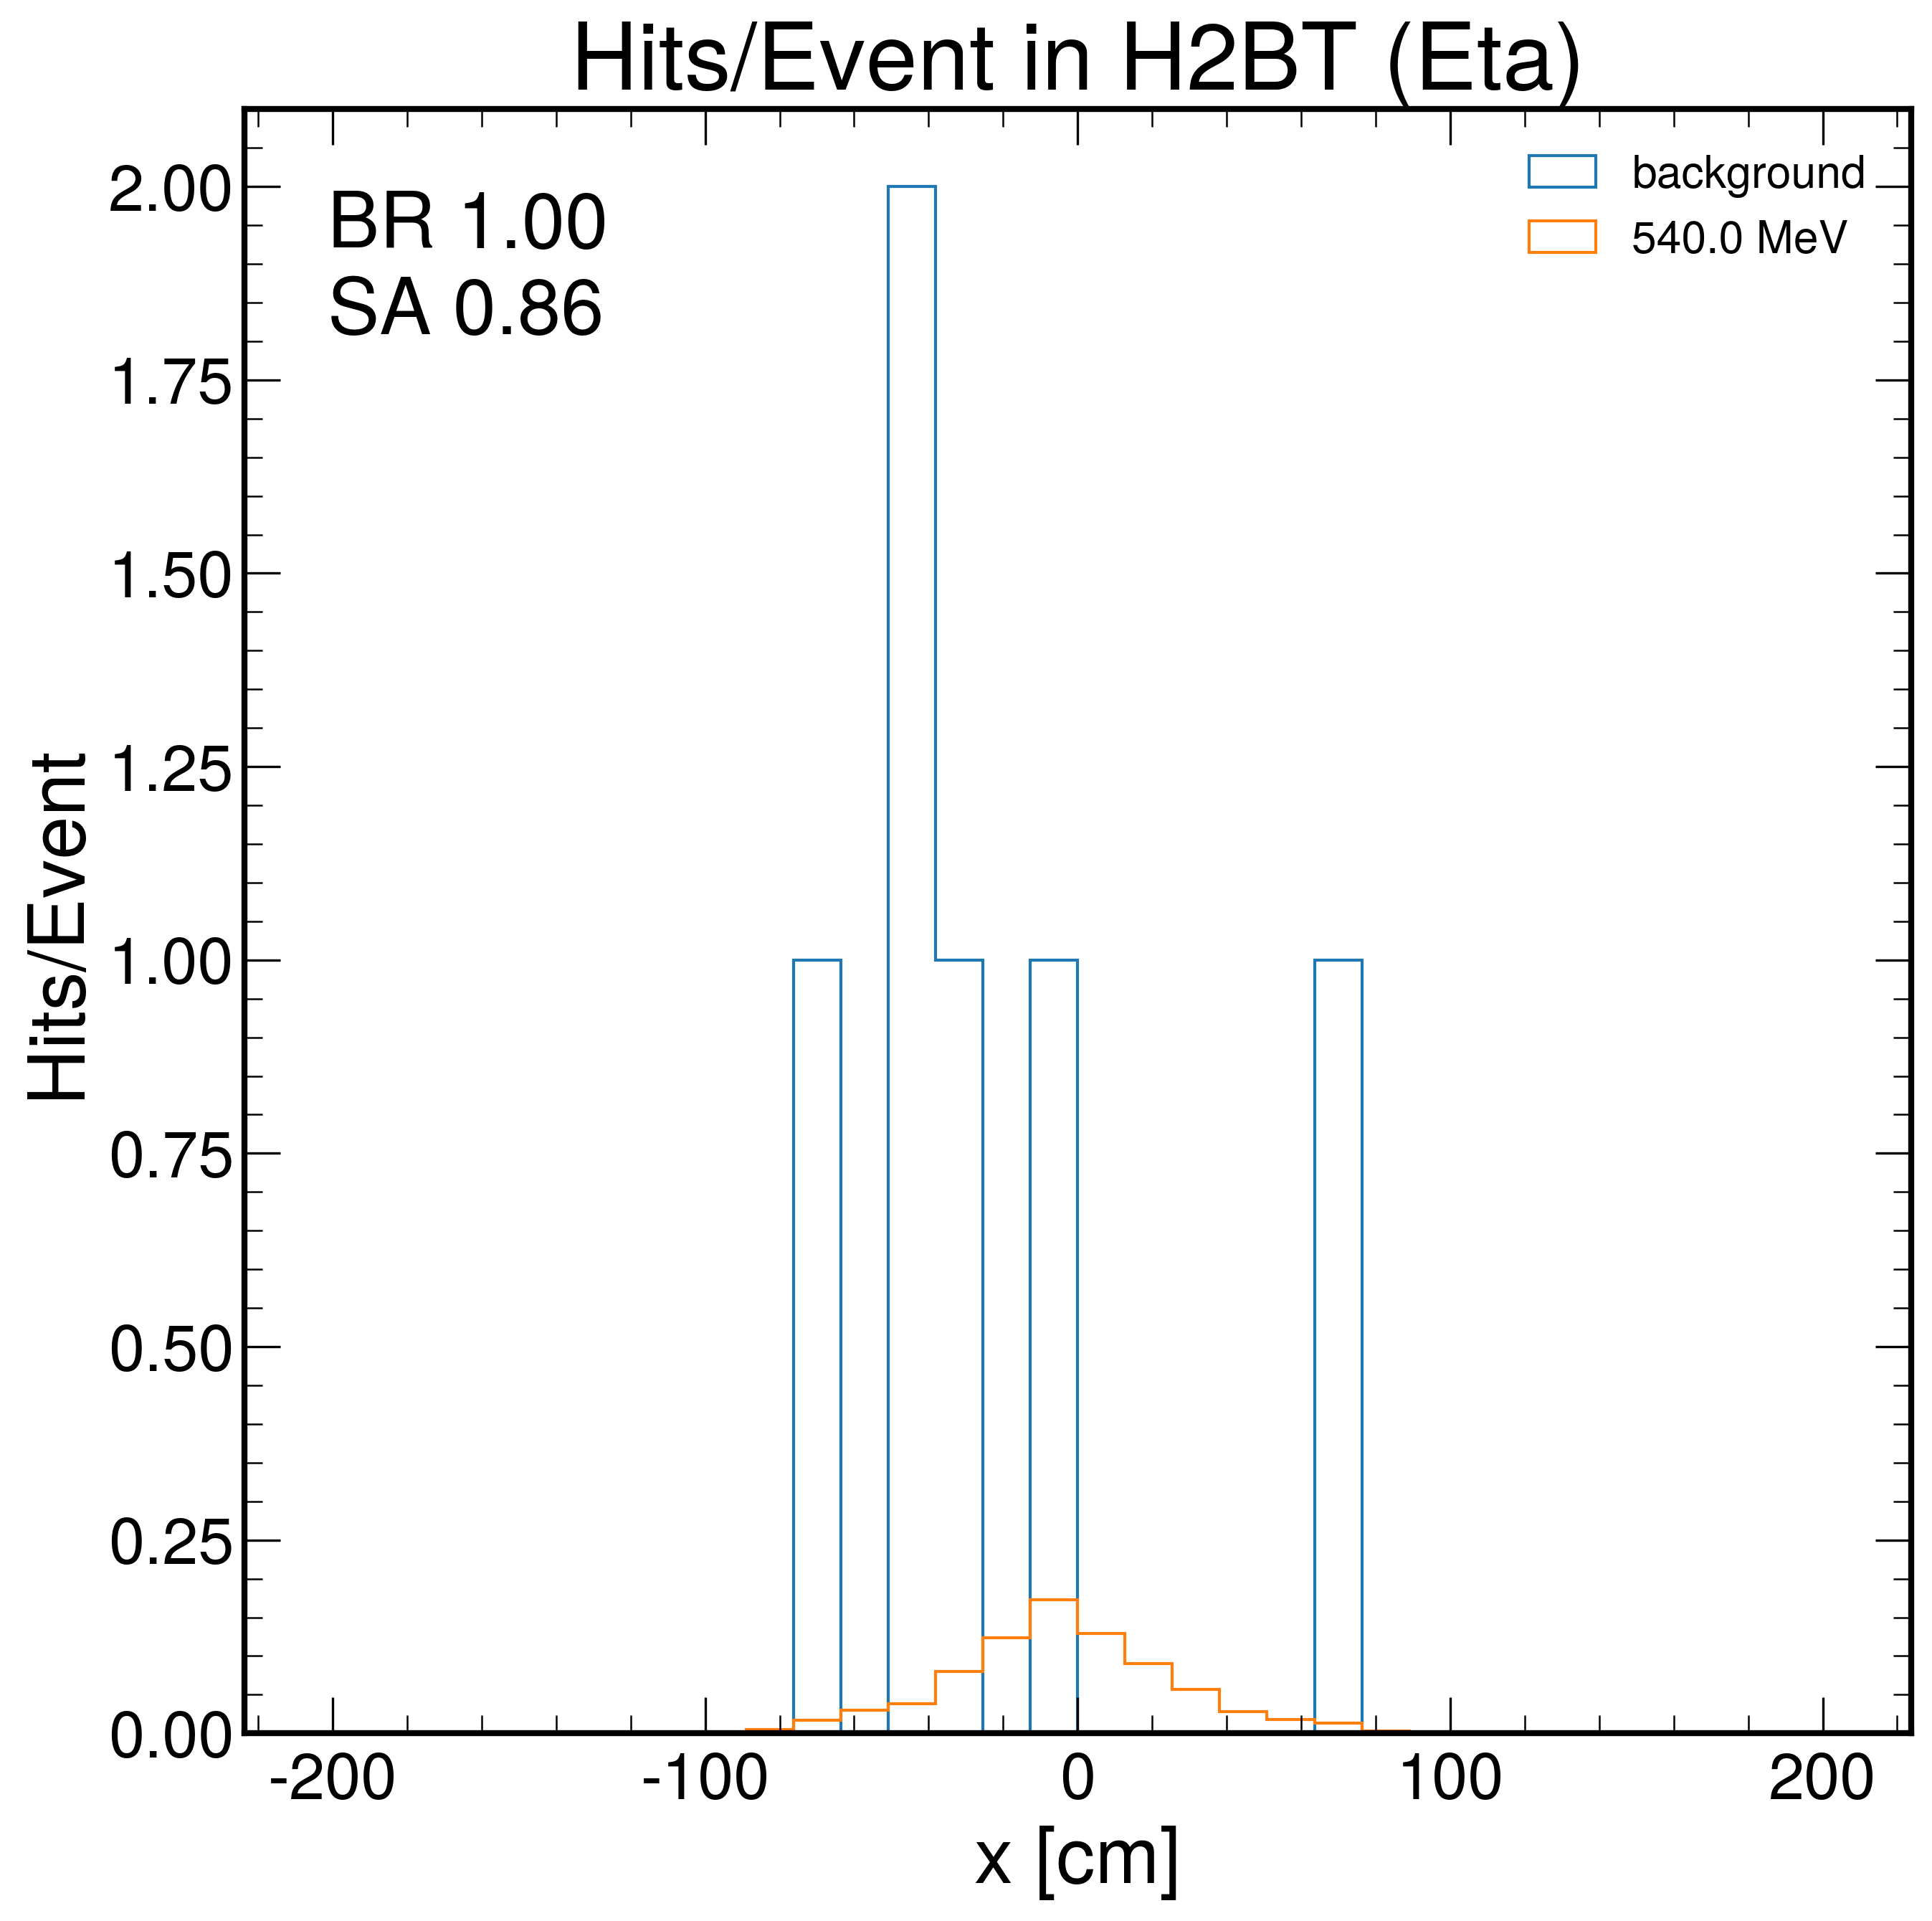

<Figure size 720x720 with 0 Axes>

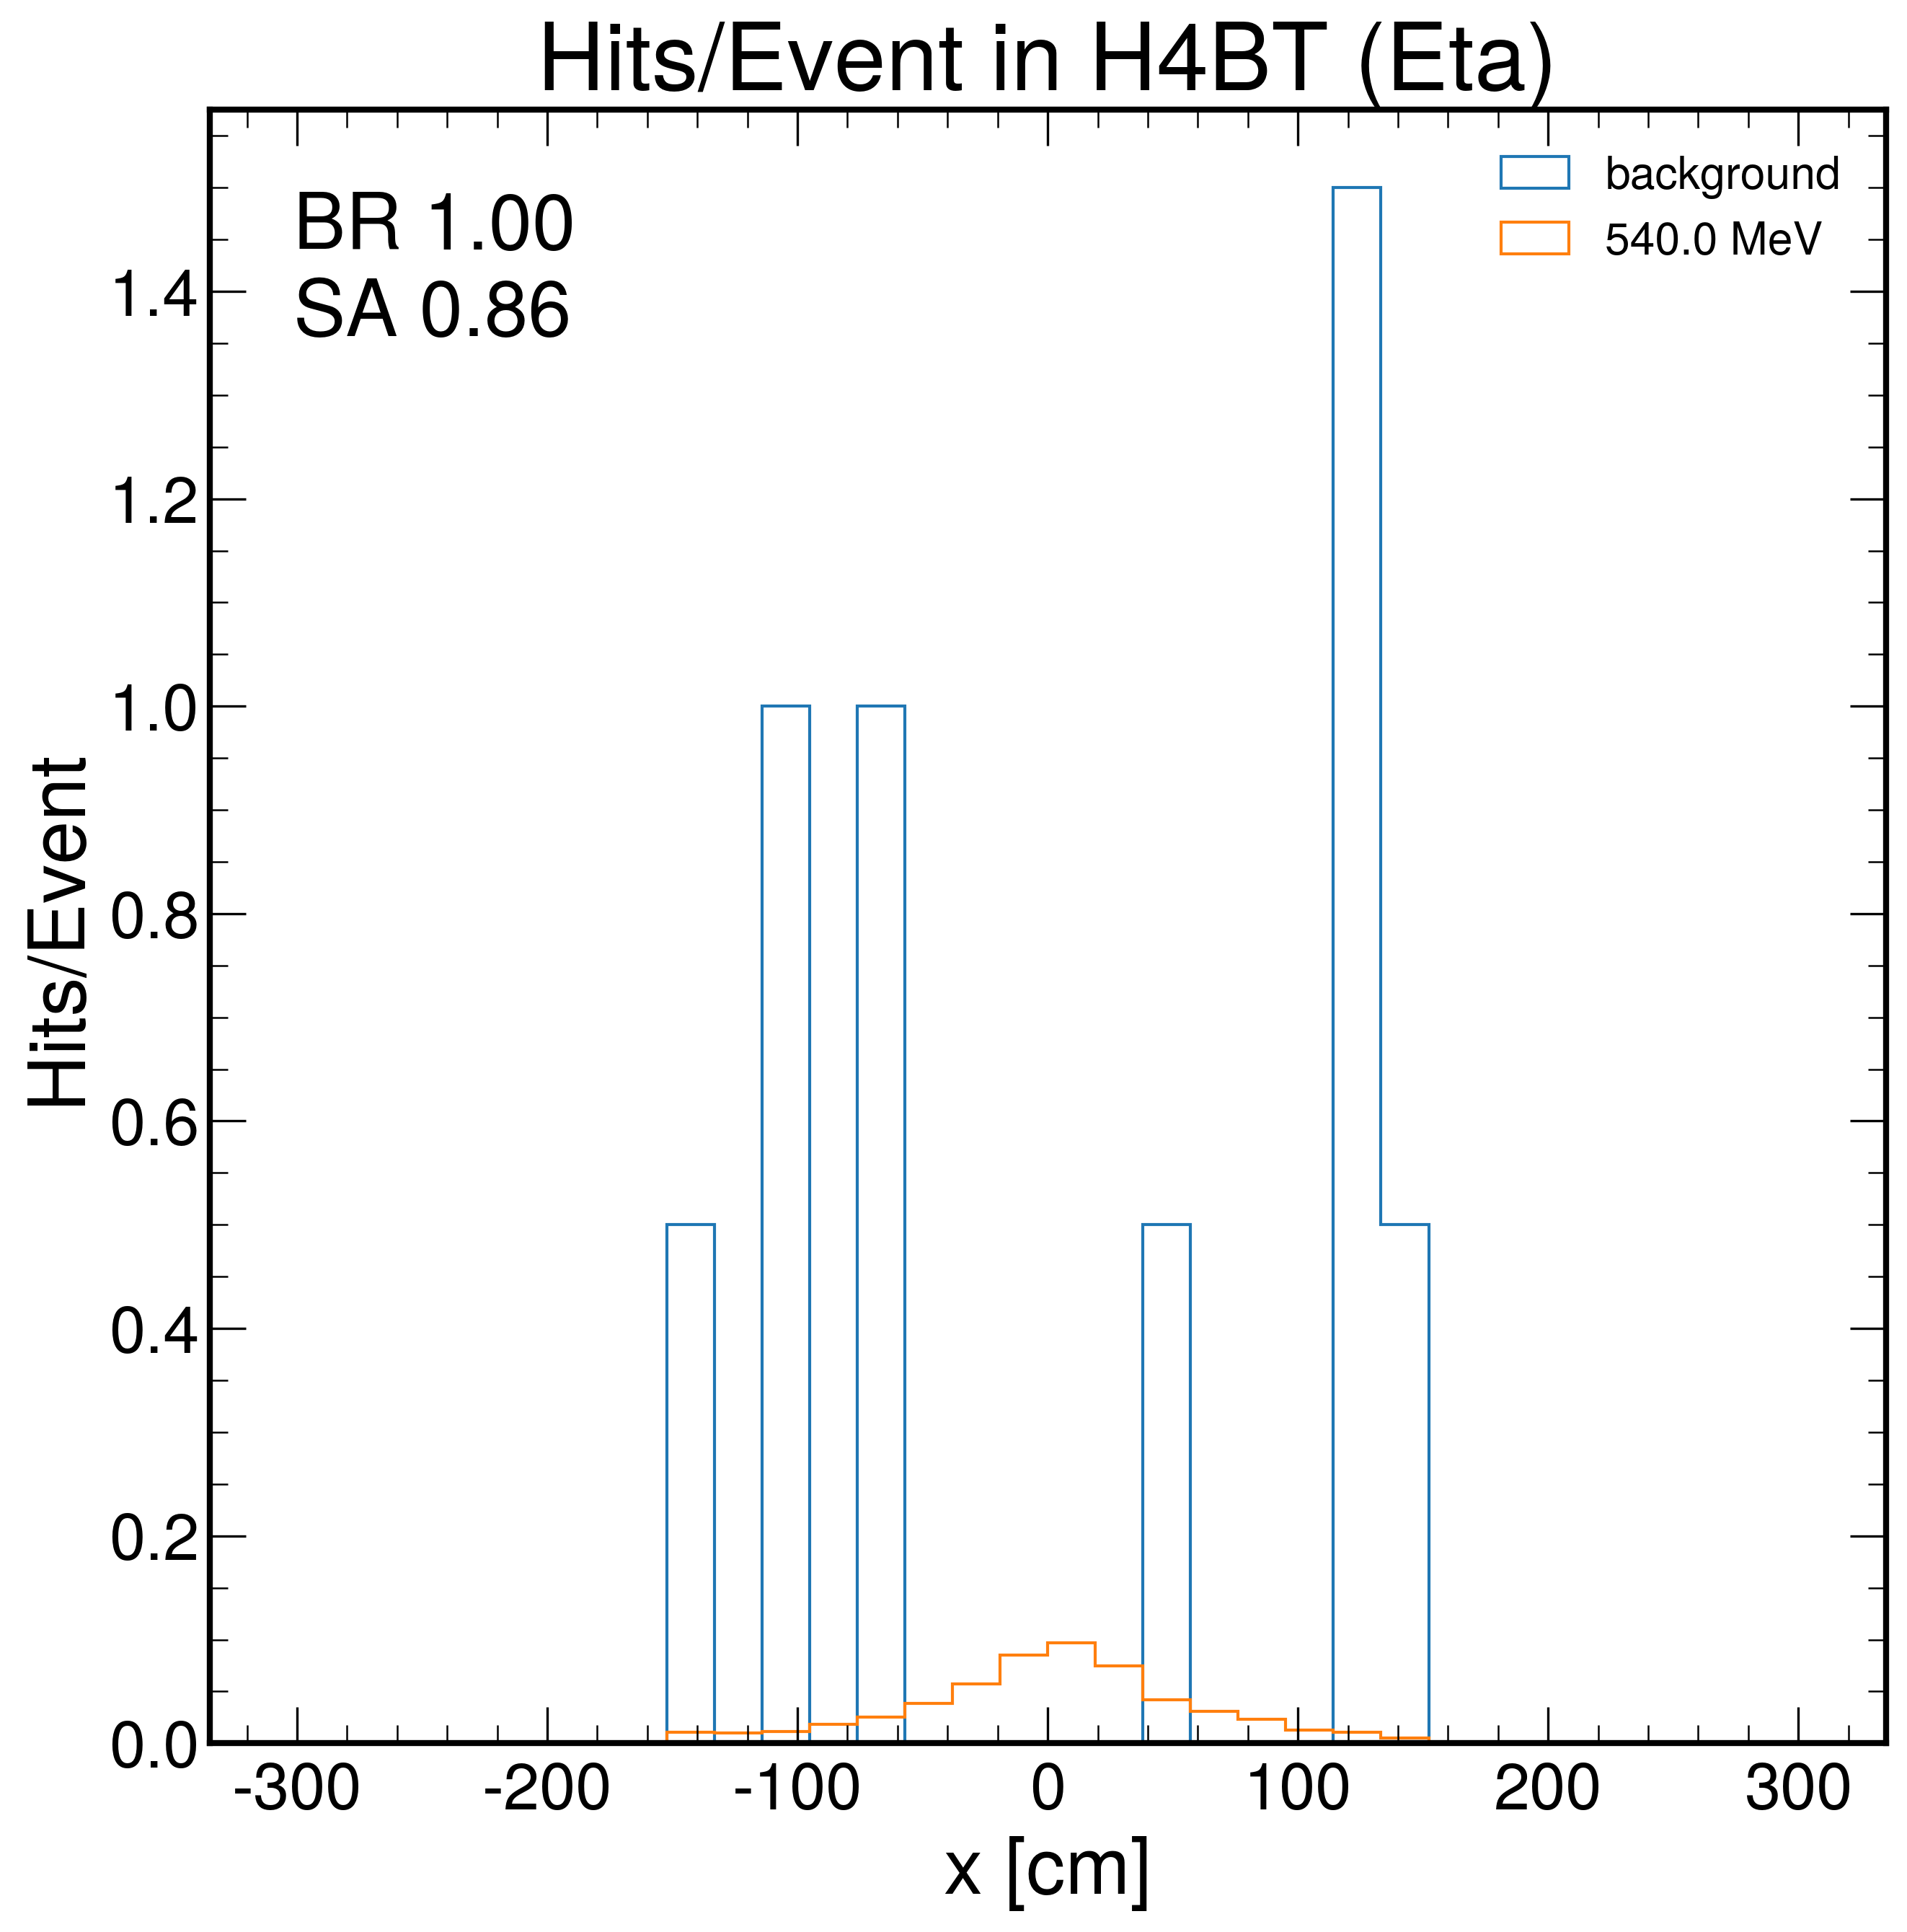

/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 720x720 with 0 Axes>

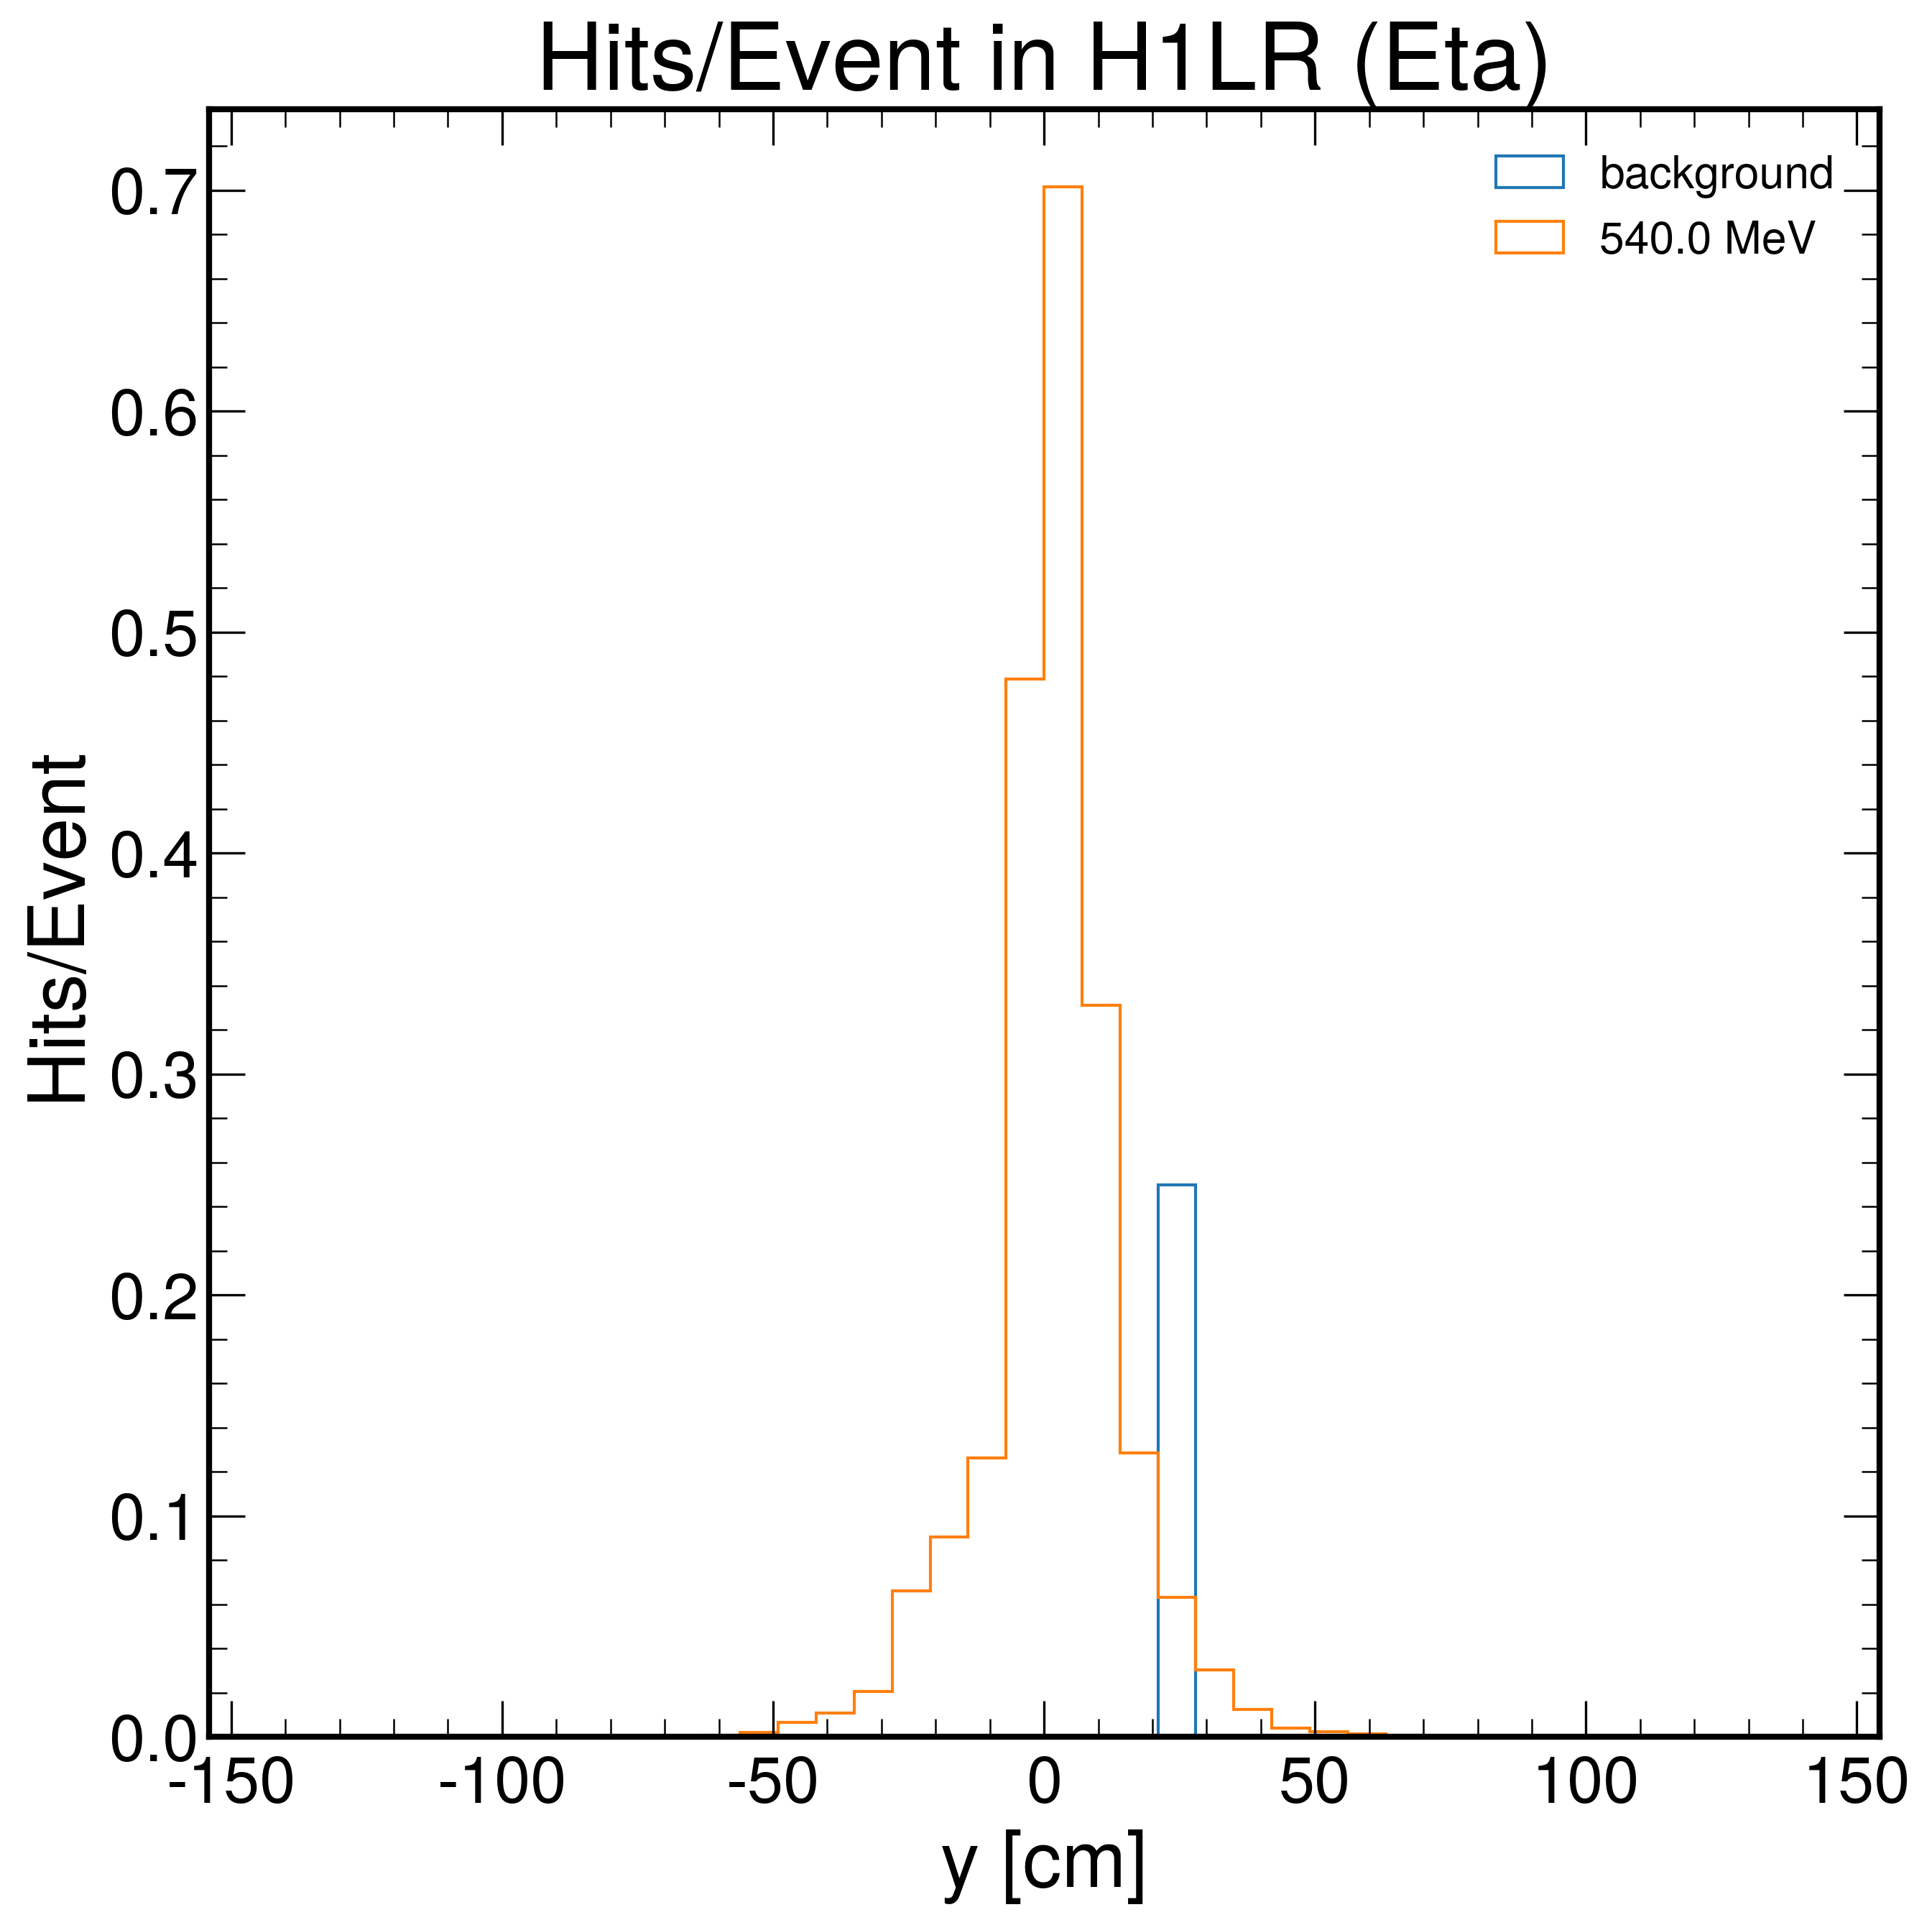

<Figure size 720x720 with 0 Axes>

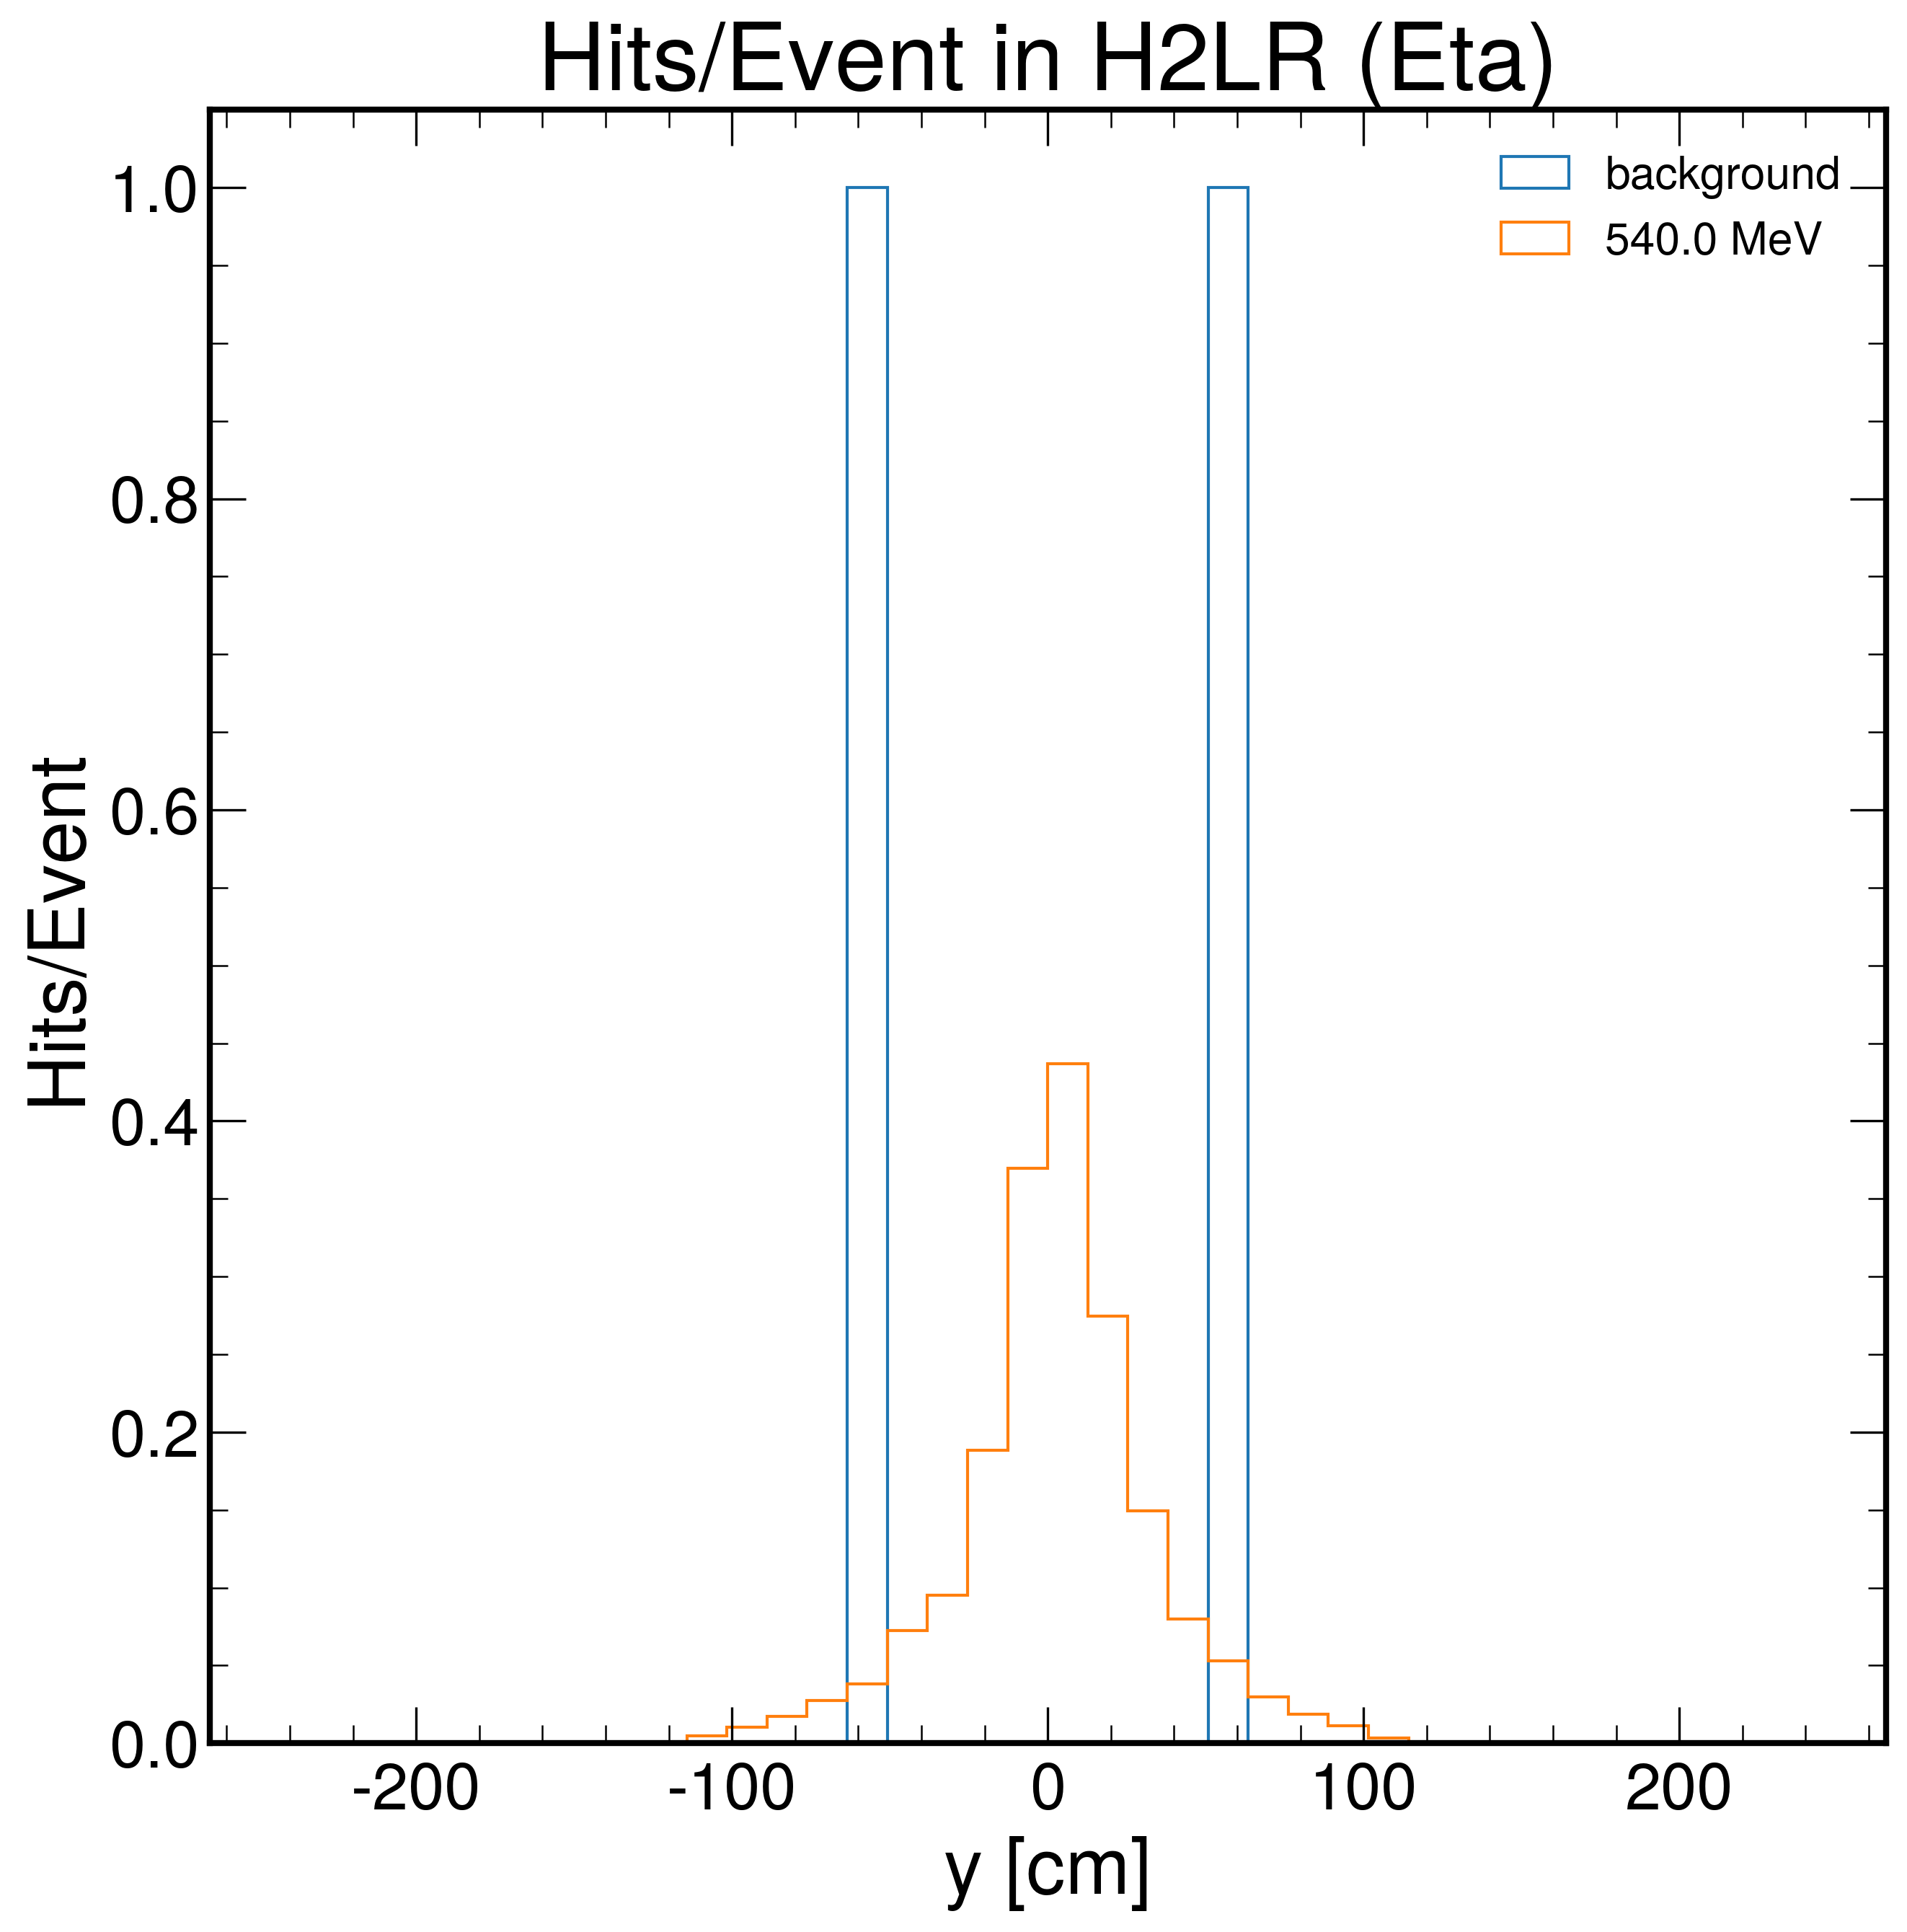

/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/amitav/miniconda3/envs/DarkQuest/lib/python3.8/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


<Figure size 720x720 with 0 Axes>

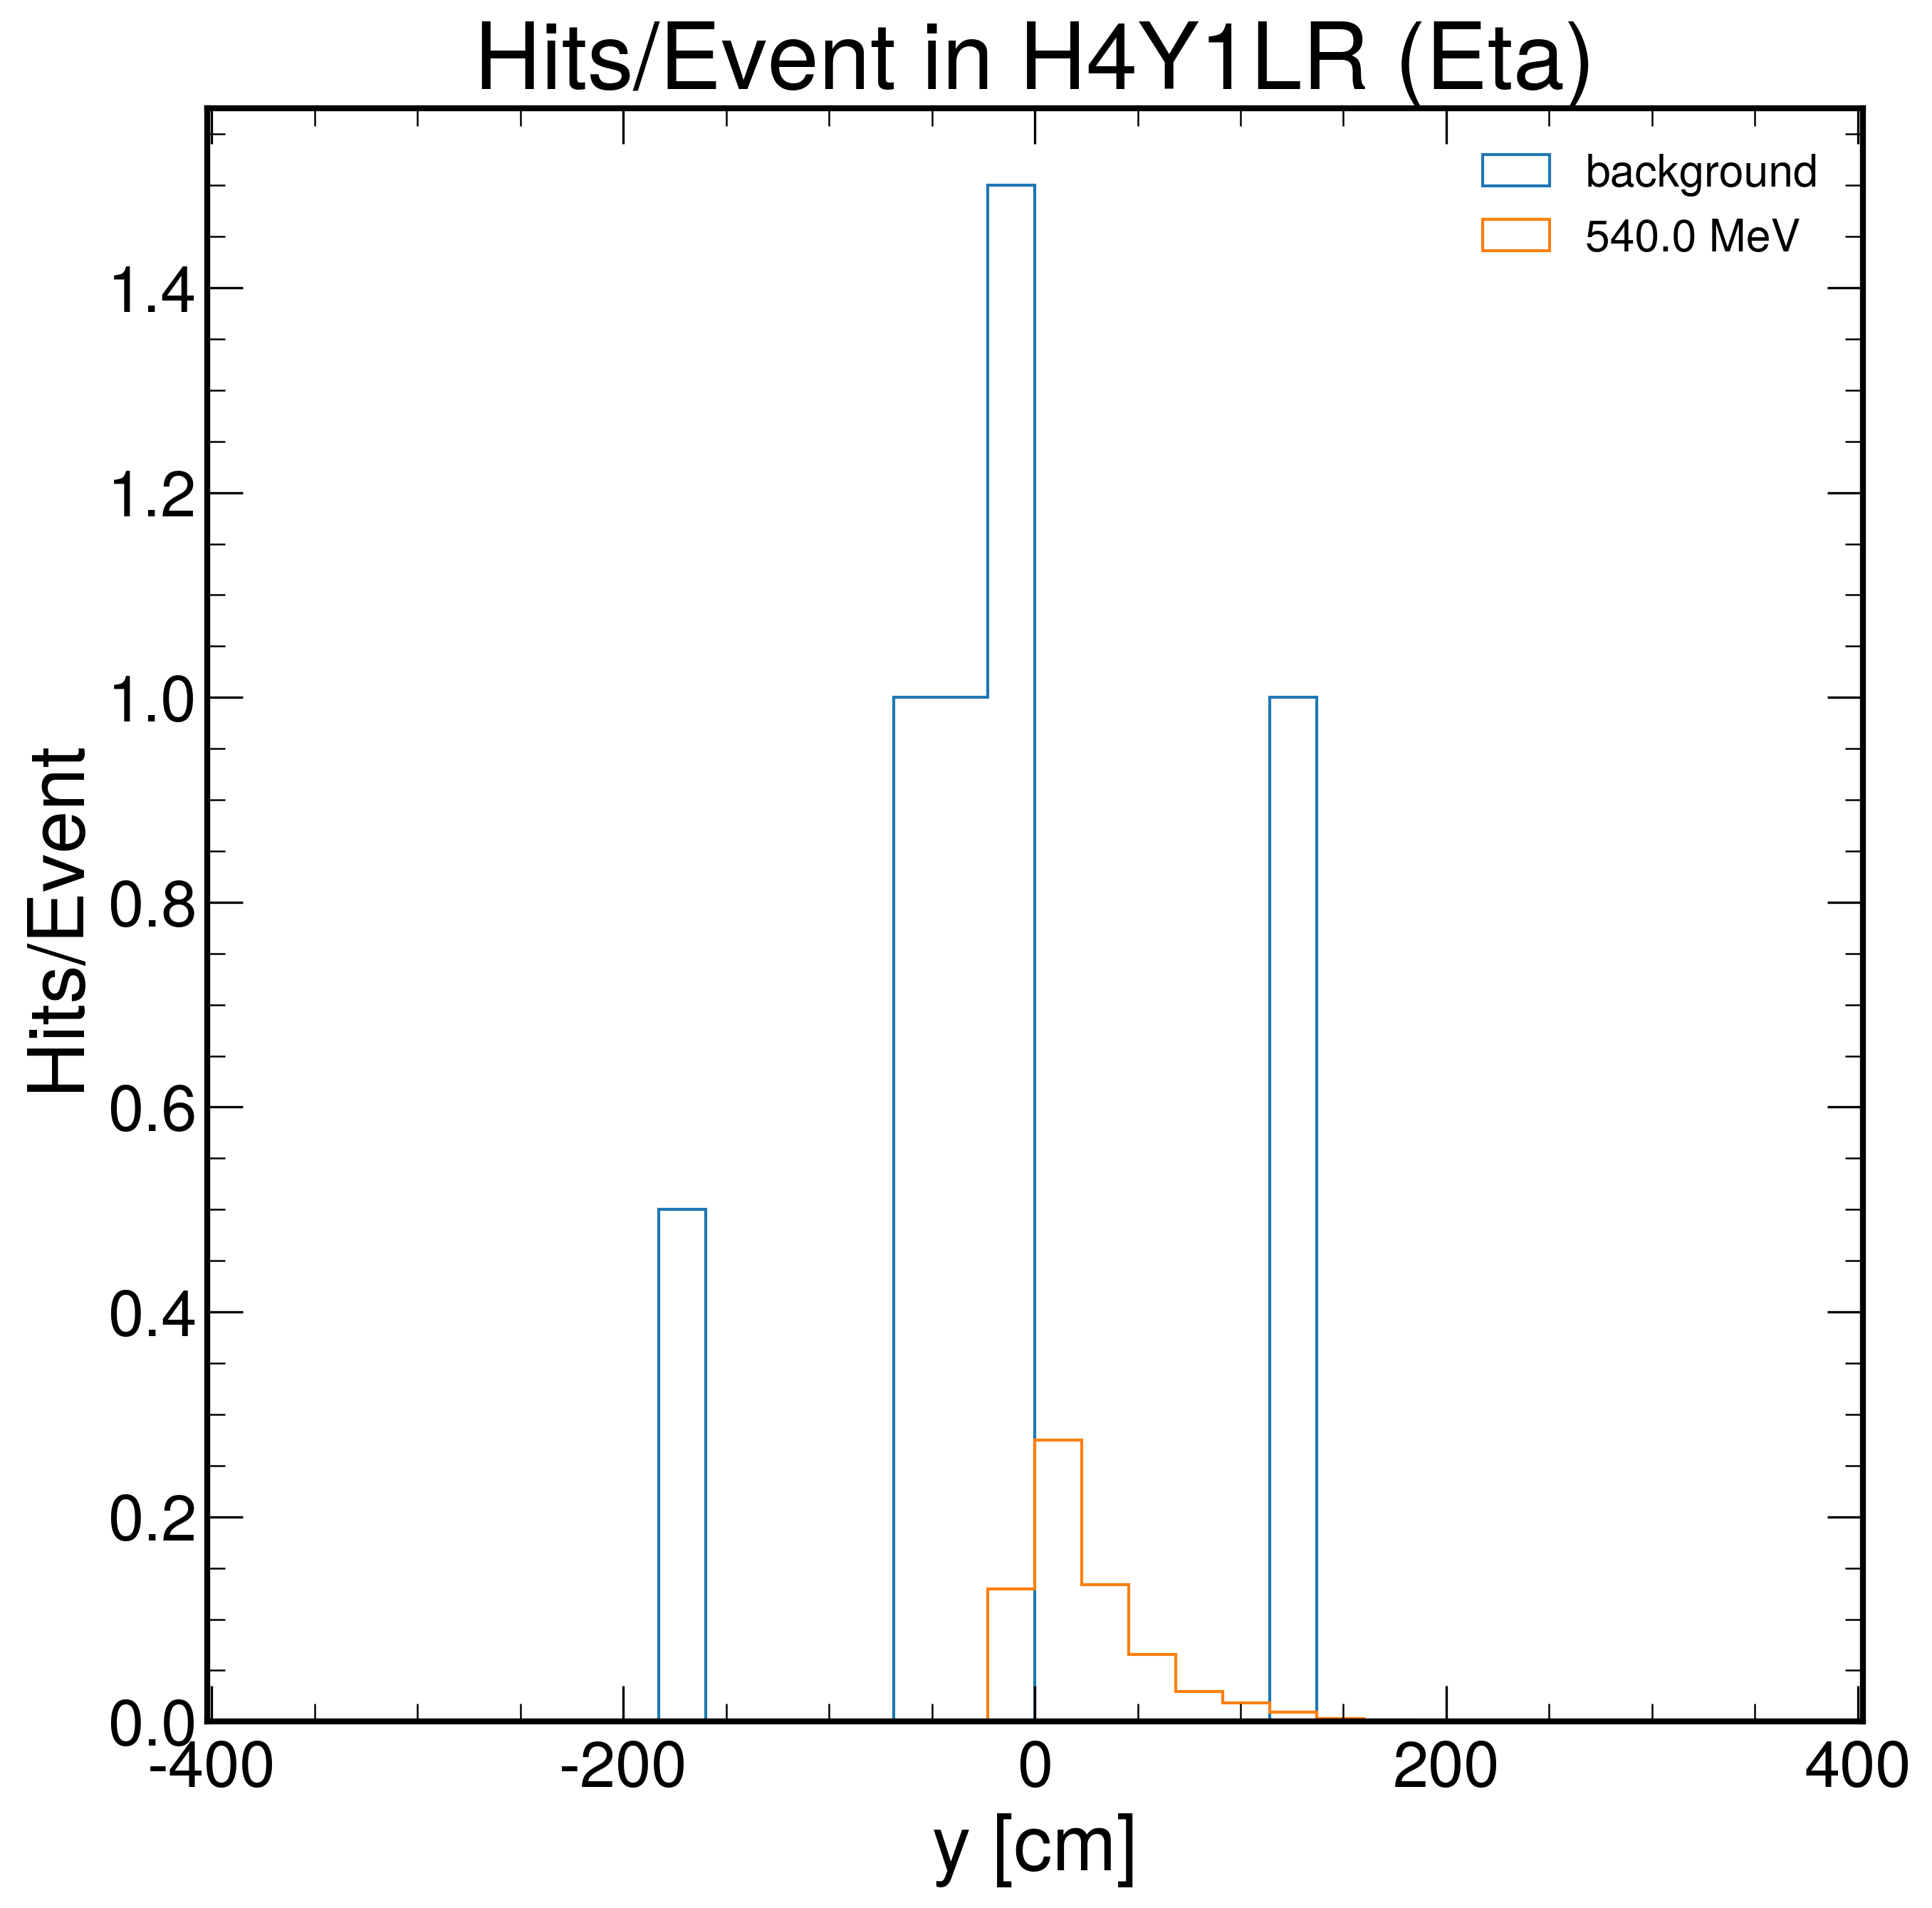

<Figure size 720x720 with 0 Axes>

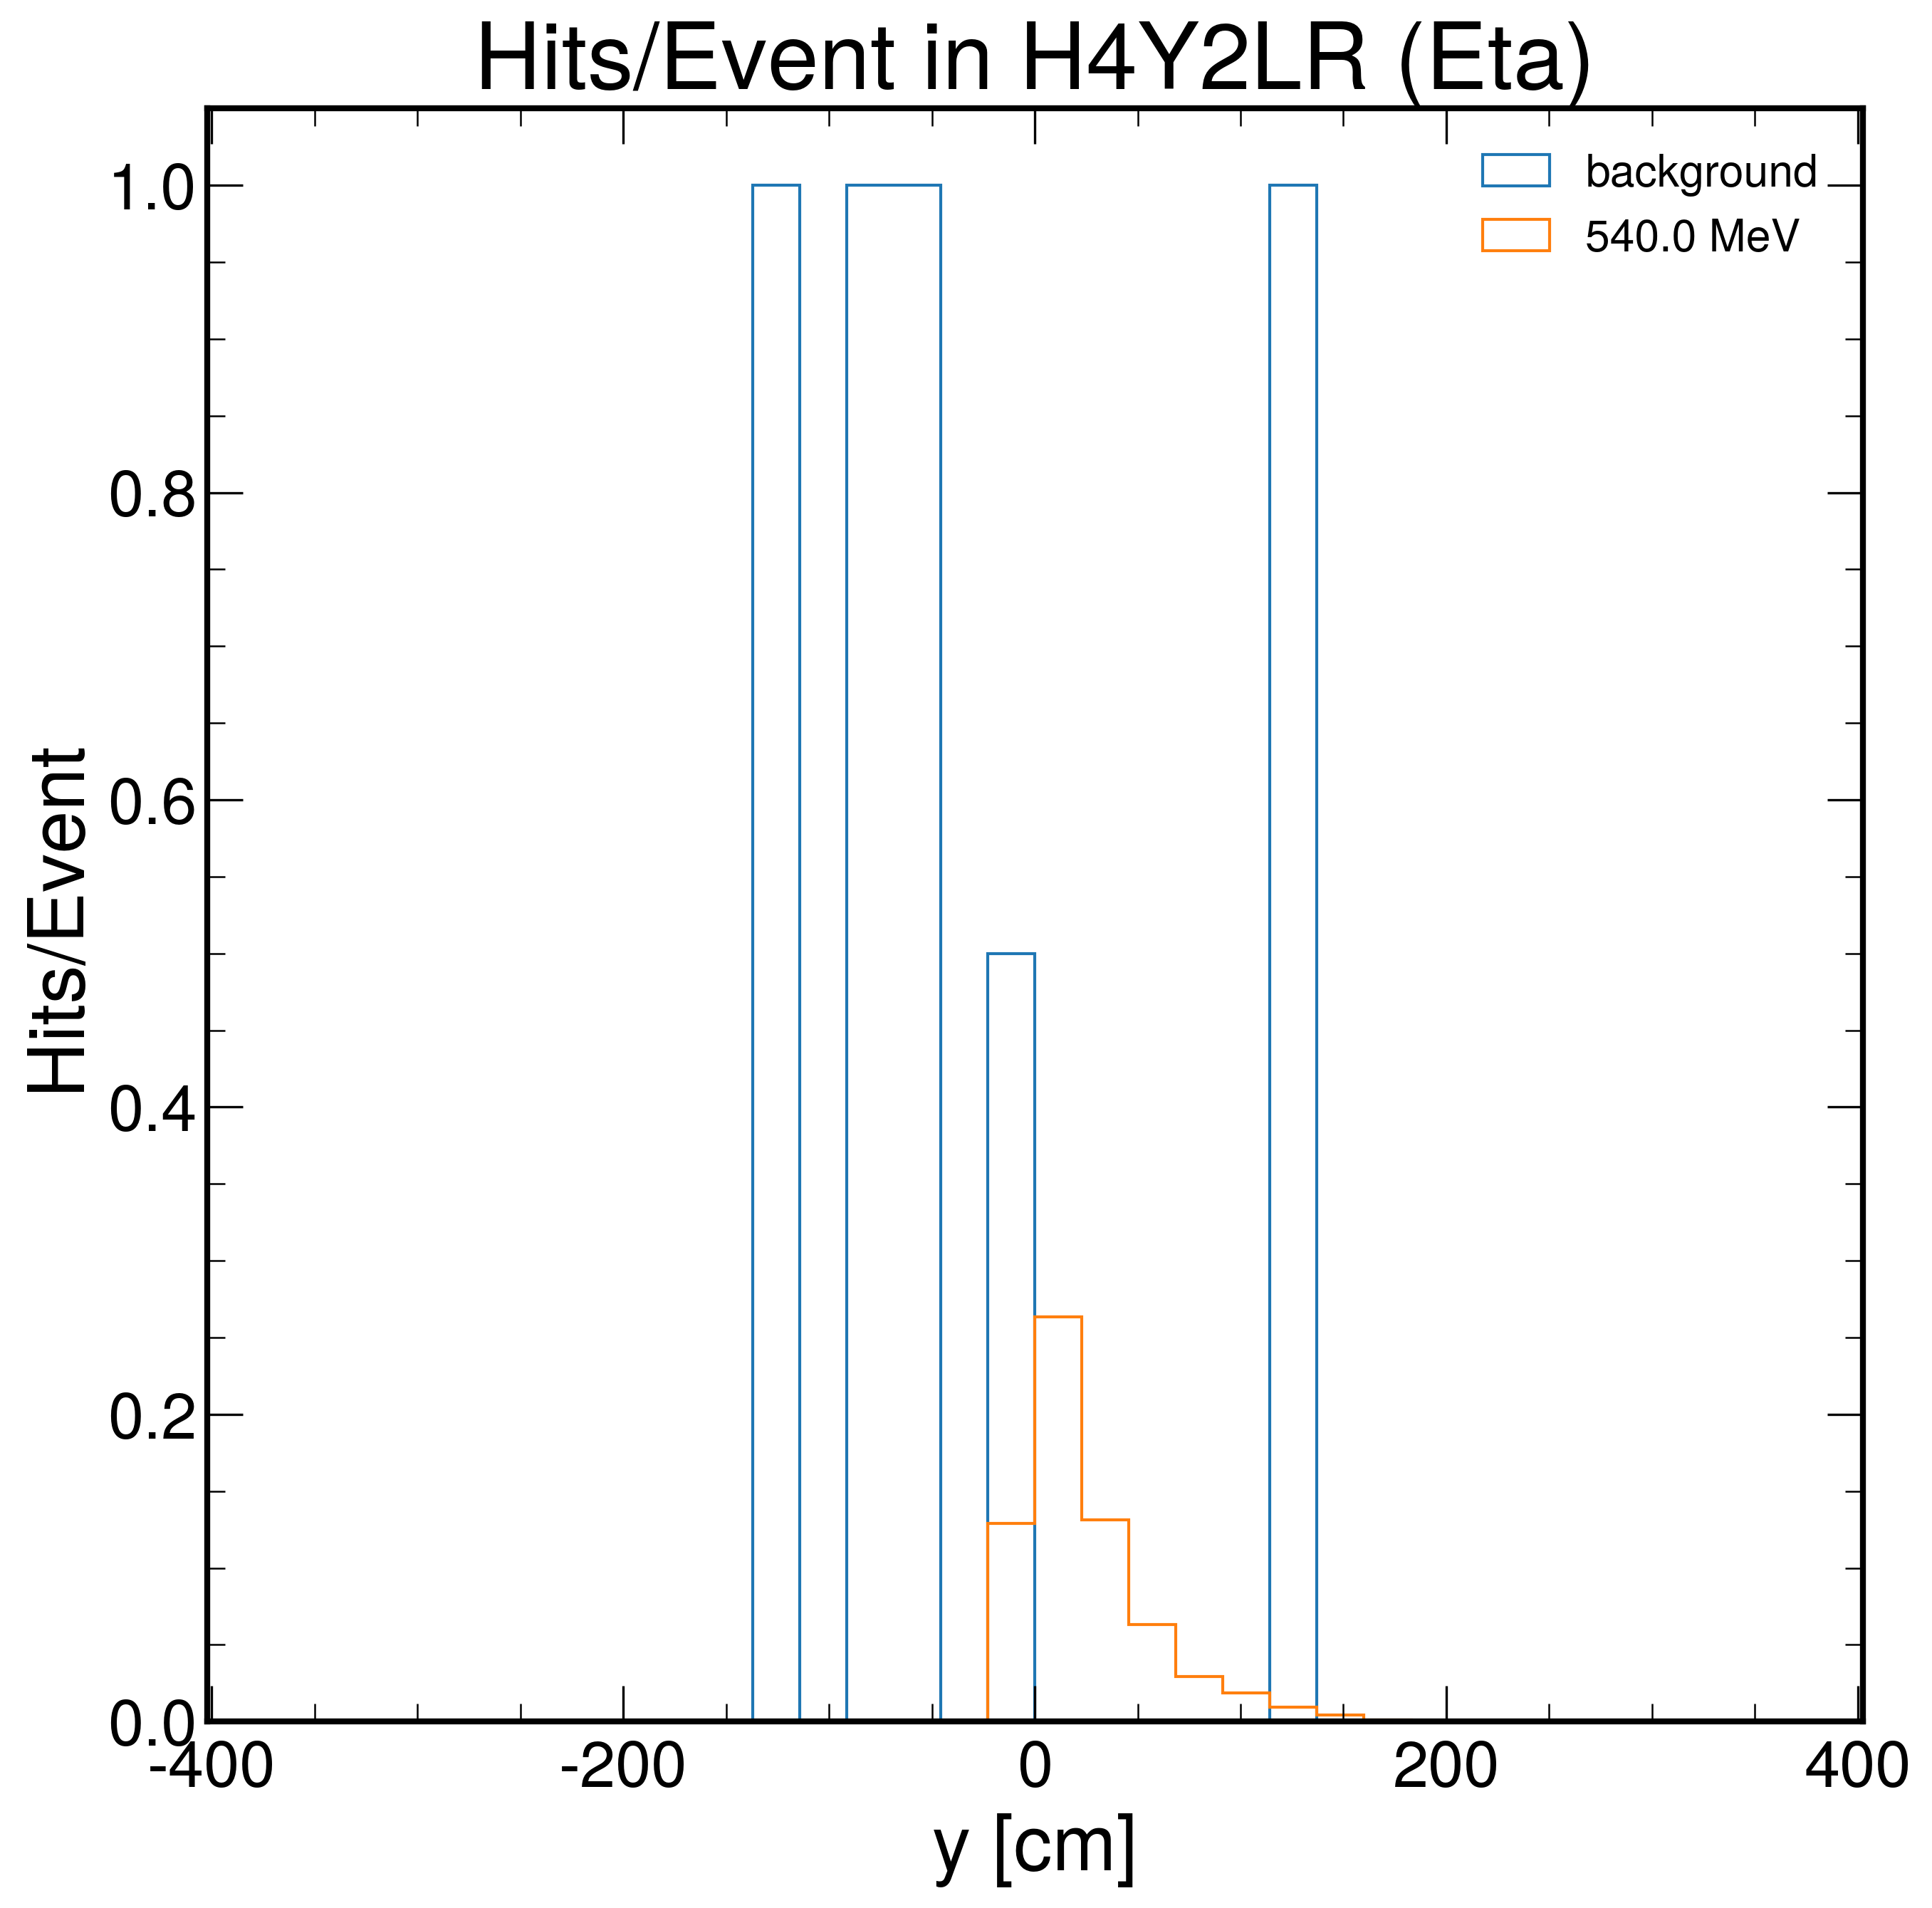

In [20]:
e = layer4BG(root, layer=[1,2], cut1=(-30,20), cut2=(-80,80))
f = layer4Sim(Truth054, layer=[1,2], cut1=(-30,20), cut2=(-80,80))
plot_overlay(e,f,Eta054,weighted=True)

By now, virtually all the background is rejected with only a 2% loss in signal acceptance. It seems that cutting only on station 1 would be best, to maximize the background rejection and signal acceptance. 

# ROC Curve

In [21]:
def efficiencies(bg, sim, layer=[1,2,4], num=100, cut1=(10,1), cut2=(10,1), cut4=(10,1)):
    '''
    Returns arrays of signal efficiency and background rejection for each of the three layers cut over a given array of x-ranges
    bg = background data ROOT file
    sim = signal data ROOT file
    num = number of different cuts to make
    cut_ = bounds for making the cuts at each station (larger, smaller) inclusive 
        i.e. If you want to cuts from -100,100cm down to -1,1cm on station 1 -> cut1=(100,1)
    '''
    # generate the bounds
    b1 = np.linspace(cut1[0],cut1[1],num=num)
    b1_r = np.linspace(cut1[1],cut1[0],num=num)
    b2 = np.linspace(cut2[0],cut2[1],num=num)
    b2_r = np.linspace(cut2[1],cut2[0],num=num)
    b4 = np.linspace(cut4[0],cut4[1],num=num)
    b4_r = np.linspace(cut4[1],cut4[0],num=num)
    # now we can loop through a range num/2 to create the proper cuts, i.e.
    # cut1 = (b1[i],b1_r[i])
    
    # arrays to hold the SE and BR values for each cut -> will be merged into three shape (2,xrange) arrays at the end
    st1_SE = np.array([])
    st1_BR = np.array([])
    st2_SE = np.array([])
    st2_BR = np.array([])
    st4_SE = np.array([])
    st4_BR = np.array([])
    
    # loop through x-ranges, perform cuts 
    for i in range(int(num/2)):
        try:
            bkg_data = layer4BG(bg, layer=layer, cut1=(b1[i],b1_r[i]), cut2=(b2[i],b2_r[i]), cut4=(b4[i],b4_r[i]))
            sim_data = layer4Sim(sim, layer=layer, cut1=(b1[i],b1_r[i]), cut2=(b2[i],b2_r[i]), cut4=(b4[i],b4_r[i]))
        except ValueError:   # occurs when bkg_data or sim_data is empty
            pass
        
        # get the SEs
        SE1 = sim_data[0][2]/10000       # caclulate SE at st1
        st1_SE = np.append(st1_SE, SE1)  # append it to array
        SE2 = sim_data[1][2]/10000
        st2_SE = np.append(st2_SE, SE2)
        SE4 = sim_data[2][2]/10000
        st4_SE = np.append(st4_SE, SE4)
        
        # get the BRs
        BR1 = 1 - bkg_data[0][2]/677
        st1_BR = np.append(st1_BR, BR1)
        BR2 = 1 - bkg_data[1][2]/677
        st2_BR = np.append(st2_BR, BR2)
        BR4 = 1 - bkg_data[2][2]/677
        st4_BR = np.append(st4_BR, BR4)
    
    # return three arrays, each of the form [SE,BR], for stations 1 2 4
    return np.array([st1_SE,st1_BR]), np.array([st2_SE,st2_BR]), np.array([st4_SE,st4_BR])

In [22]:
def plot_efficiencies(st1,st2,st4,name,layer=[1]):
    '''
    pass the three arrays of shape (2,xrange)
    pass the name of the sim file used
    pass the cut(s) imposed in the efficiencies method
    '''
    # get process and mass
    mass = str(float(name.split("_")[3][0:4])*1000) + " MeV"
    proc = name.split("_")[2]
    
    # get data
    st1_SE = st1[0]
    st1_BR = st1[1]
    st2_SE = st2[0]
    st2_BR = st2[1]
    st4_SE = st4[0]
    st4_BR = st4[1]
    
    plt.figure(dpi=300)
    plt.title("Signal Efficiency vs Background Rejection\n{} {}".format(proc,mass))
    plt.xlabel("Signal Efficiency")
    plt.ylabel("Background Rejection")
    
    if (layer==[1]):
        plt.plot(st1_SE, st1_BR, "-b")
        #plt.savefig("efficiencies_{}".format(proc))
        
    elif (layer==[1,2]):
        plt.plot(st1_SE, st1_BR, "-b", label="ST1")
        plt.plot(st2_SE, st2_BR, "-r", label="ST2")
        plt.legend(loc='lower left')
        #plt.savefig("efficiencies_{}".format(proc))
    
    elif (layer==[1,2,4]):
        plt.plot(st1_SE, st1_BR, "-b", label="ST1")
        plt.plot(st2_SE, st2_BR, "-r", label="ST2")
        plt.plot(st4_SE, st4_BR, "-g", label="St4")
        plt.legend(loc='lower left')
        #plt.savefig("efficiencies_{}".format(proc))
    
    else:
        print("not valid")

This example shows the results of imposing cuts only on station 1, ranging from `x = [-100,100]` to `[-1,1]`. What's encouraging is that very small changes in the cut applied result in an enormous gain in background rejection for very little loss in signal acceptance

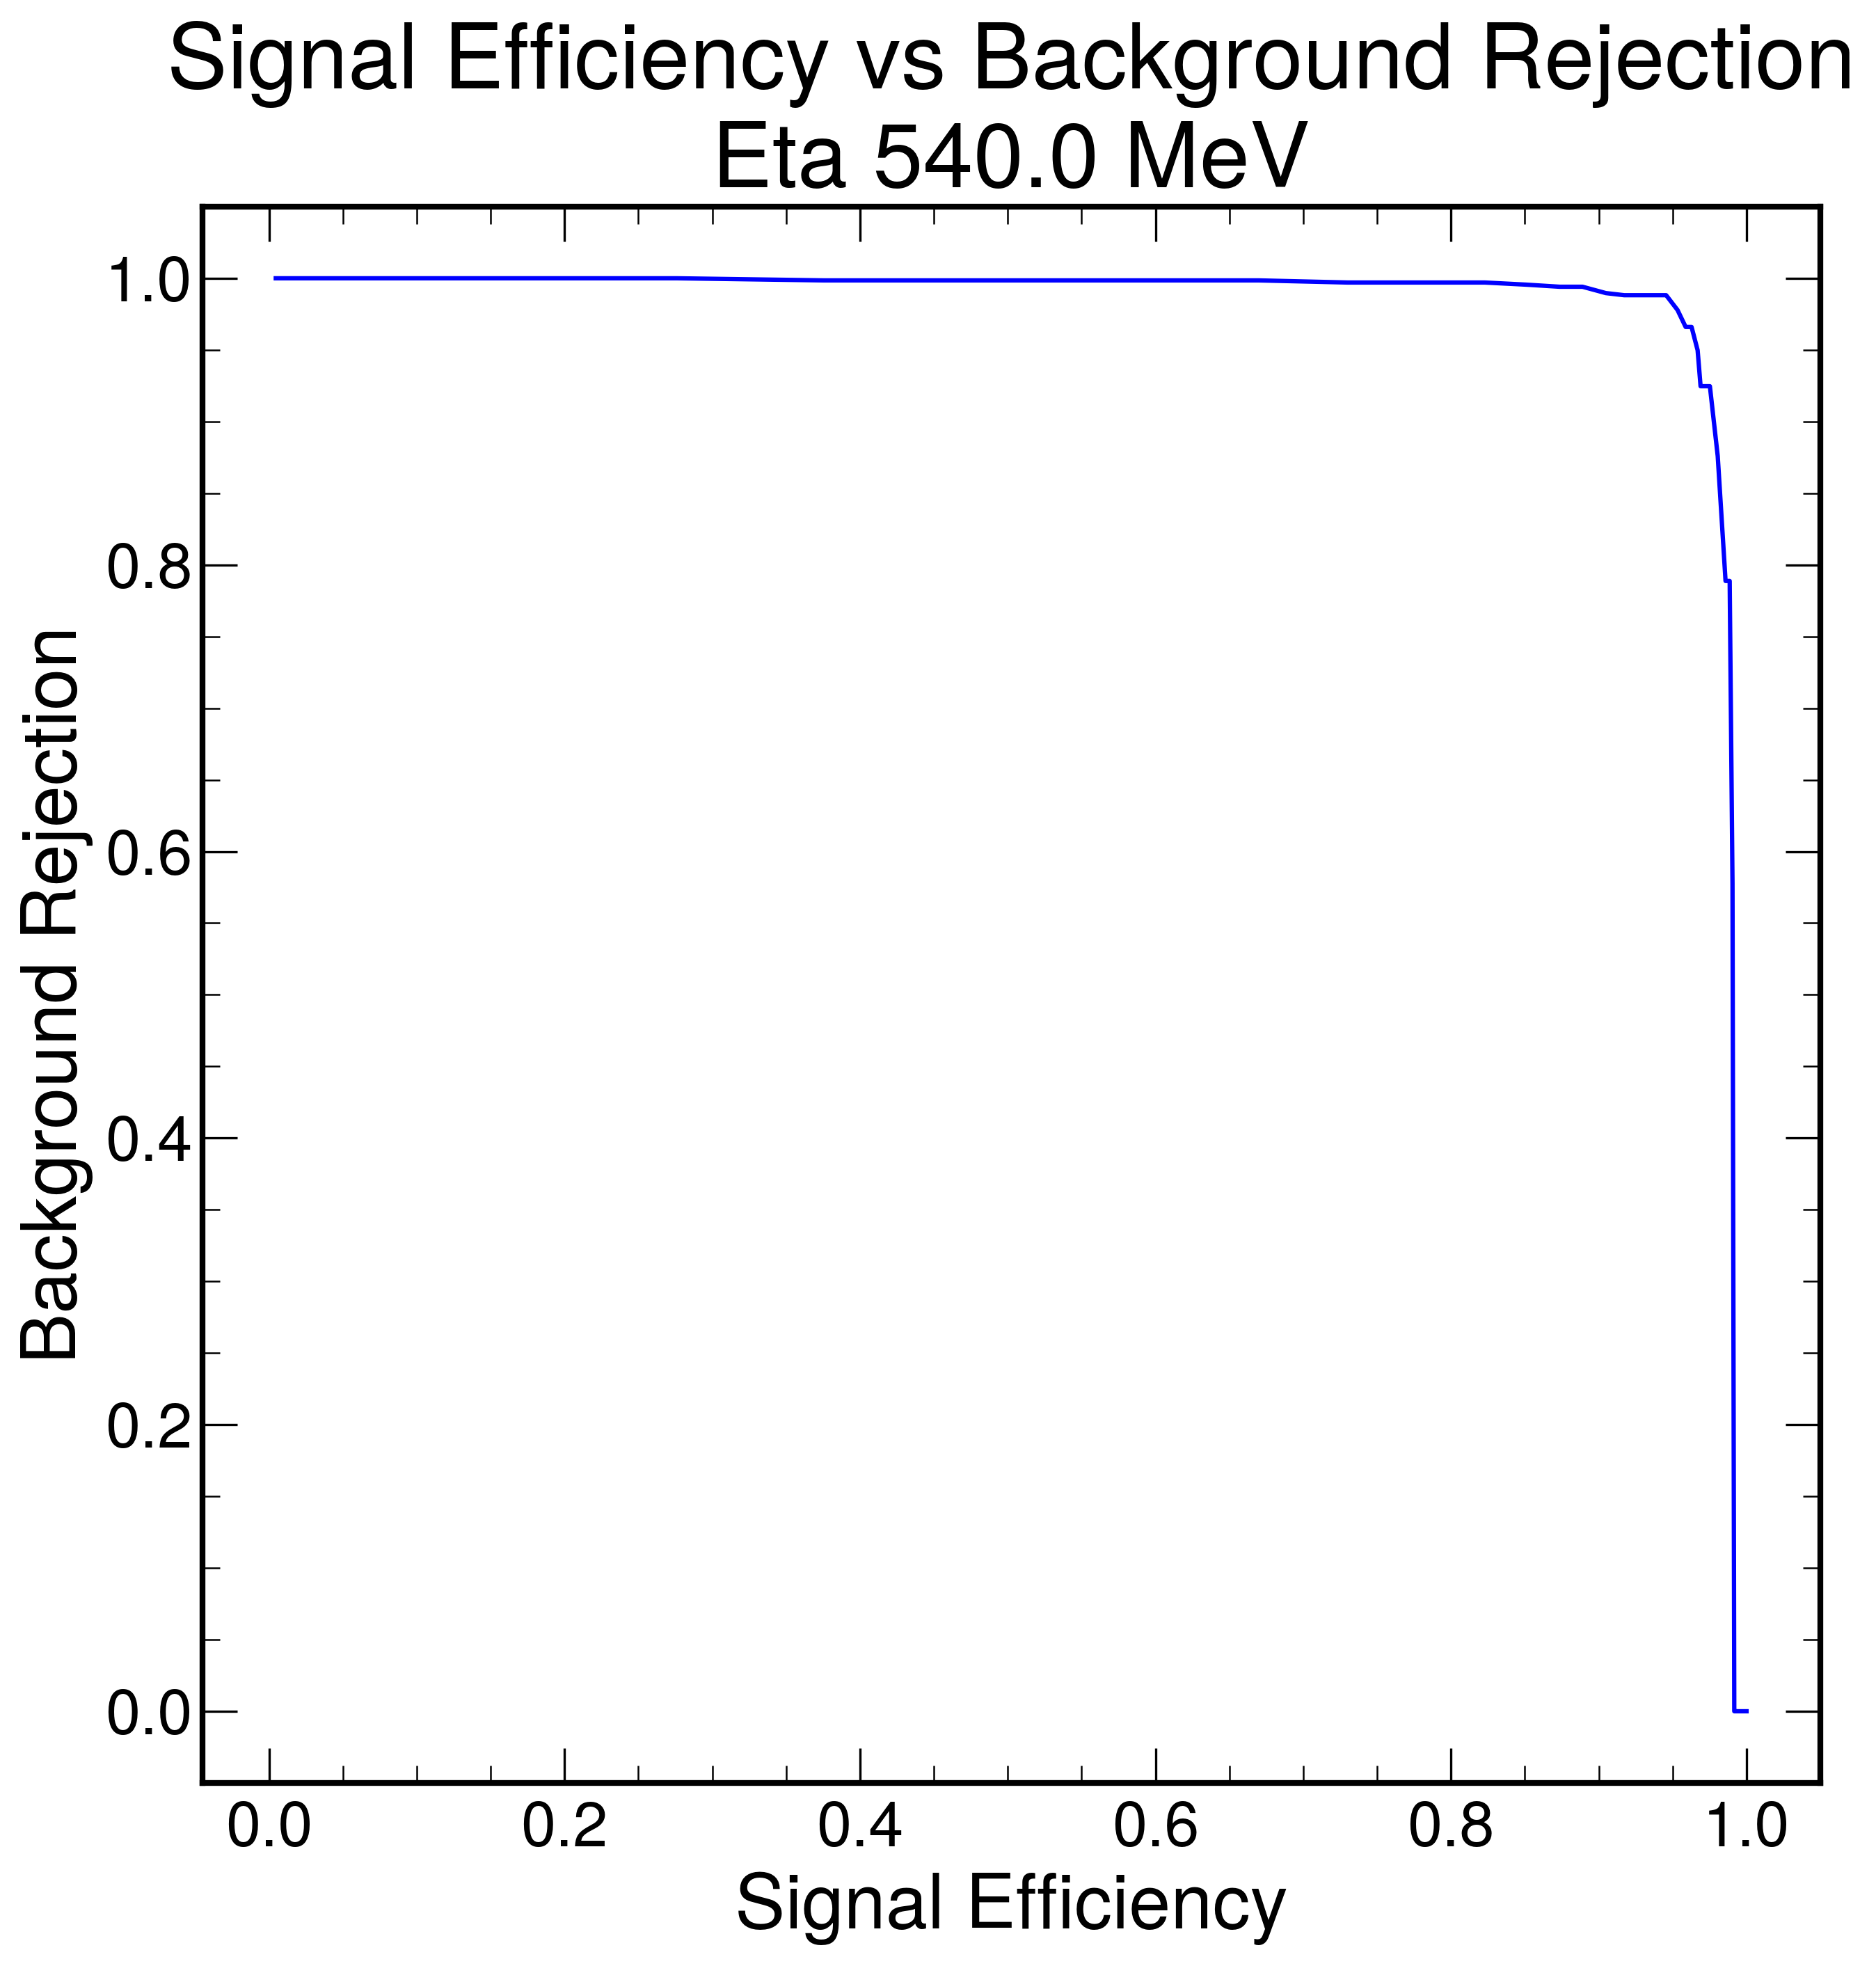

In [23]:
st1,st2,st4 = efficiencies(root,Truth054,num=100,layer=[1],cut1=(-100,100))
plot_efficiencies(st1,st2,st4,Eta054,layer=[1])